<a href="https://colab.research.google.com/github/dejiandrew/nba-award-predictor/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline for Final Notebook:

1. Data Pipeline
2. Exploratory Data Analysis (EDA)
3. Logistic Regression
4. Light GBM Model
5. Neural Network
6. Summary

# **NBA Award Predictor: Data Pipeline**

Data pipeline code can be found at https://github.com/dejiandrew/nba-award-predictor/tree/main/data_pipeline

# Part 1: Pipeline Architecture

Complete data flow from source to machine-learning-ready features:

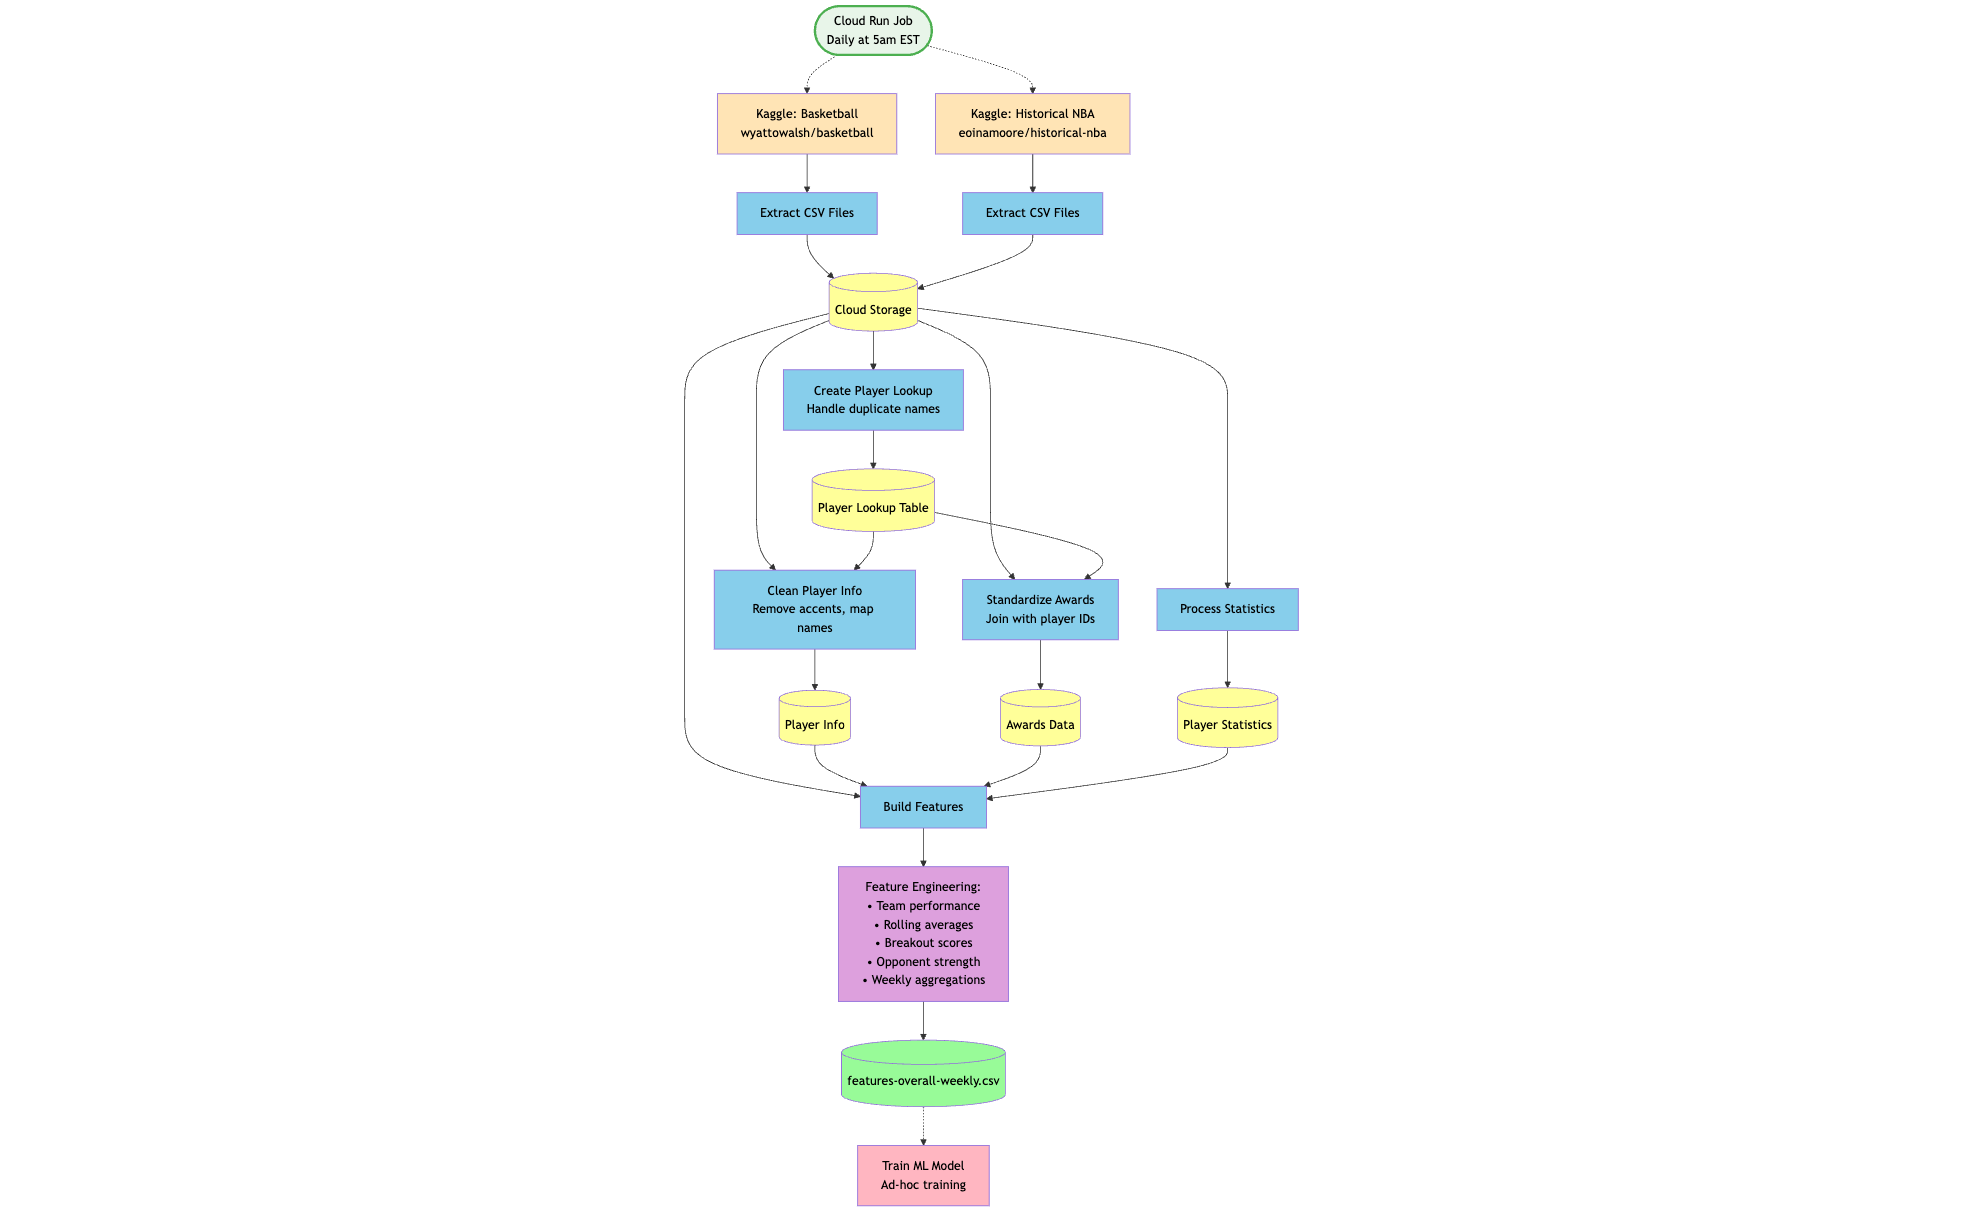

# Key Components

## 1\. Trigger Mechanism

**Cloud Run Job - Daily at 5am EST**

The pipeline executes automatically every day at 5:00 AM EST via a Google Cloud Run Job. This ensures the data remains current and the feature sets reflect the latest NBA games and statistics.

## 2\. Data Sources

**Kaggle - wyattowalsh/basketball:** Comprehensive SQLite database containing historical NBA data including games, teams, and play-by-play information

**Kaggle - eoinamoore/historical-nba:** Detailed player box scores and historical statistics

**RealGM - NBA Awards:** Full list of Player of the Week winners & All-NBA selections

**Wikipedia - List of NBA All Stars:** Full list of all NBA All-Star teams

**NBA API**: baseline data source for player_id values

## 3\. Processing Stages

### Stage 1: Data Extraction

Both Kaggle datasets are downloaded and their CSV files are extracted. The SQLite database from the first dataset is converted to CSV format for consistency. All raw files are uploaded to Google Cloud Storage for persistent storage and downstream processing.

### Stage 2: Data Cleaning & Standardization

This stage addresses the fundamental challenge of integrating data from diverse sources: Wikipedia (All-Star data), RealGM.com (Player of the Week, All-NBA teams), and Kaggle datasets (NBA API statistics). Each source uses different naming conventions, requiring a sophisticated player ID standardization system. See the "Player ID Standardization System" section below for complete technical details on the attach_player_ids() helper function that solves this challenge.

**Create Player Lookup:** Establishes the authoritative player identity system using the NBA API. Handles duplicate names by explicitly disambiguating players like Mike Dunleavy Sr./Jr., Patrick Ewing Sr./Jr., Eddie Johnson variants, etc. Produces nba_player_lookup.csv as the single source of truth for player IDs.

**Clean Player Info:** Normalizes international player names by removing accent marks (Đ→D, Ł→L, Ø→O, etc.) and applies manual name mappings to handle edge cases. This ensures consistent matching across heterogeneous data sources. Produces common-player-info.csv.

**Standardize Awards:** Processes Player of the Week, All-Star, MVP, and All-NBA team data from Wikipedia and RealGM.com. Applies the attach_player_ids() helper function to assign consistent NBA API player IDs to these external sources. This enables seamless joining with statistical data in later stages. Produces player-of-the-week.csv and related award files.

**Process Statistics:** Standardizes data types, handles null values, and produces player-statistics.csv.

### Stage 3: Feature Engineering

**Feature Engineering Components:**

**1\. Team Performance Metrics:** Calculates season-to-date win/loss records, home/away splits, win streaks, and weekly performance. All metrics use "prior" calculations (excluding current game) to prevent data leakage.

**2\. Rolling Averages:** Computes expanding statistics for points, assists, and plus-minus for each player-season. Uses shift() to ensure only historical data informs current predictions.

**3\. Breakout Scores:** Identifies exceptional performance by calculating z-scores: (current_performance - historical_mean) / historical_std. Combines multiple metrics with weights: 0.5×points + 0.3×assists + 0.2×plus-minus. High scores (>2.0) indicate players performing significantly above their averages.

**4\. Opponent Strength:** Measures quality of competition by tracking opponent win rates, wins against teams with >50% records, and wins against rosters containing All-NBA players. Recognizes that beating strong opponents matters more than raw win totals.

**5\. Weekly Aggregations:** Aggregates individual game statistics to the weekly level (Monday-Sunday) to match the Player of the Week award timeframe. Includes sum statistics (points, assists, blocks, steals), count statistics (games played, wins), and average statistics (opponent quality metrics).

## 4\. Pipeline Output

**Dataset for ML Modeling: features-overall-weekly.csv**

The pipeline produces a weekly-aggregated dataset (features-overall-weekly.csv) where each row represents one player's performance for one week. This dataset includes:

- Player and team identifiers
- Temporal features (season, week, date)
- Performance statistics (points, assists, rebounds, etc.)
- Team performance metrics (record, win streaks)
- Opponent quality indicators
- Historical comparison metrics (z-scores, breakout scores)
- Target variable: won_player_of_the_week (binary)

# Technical Spotlight

## Player ID Standardization System

A critical challenge in this project was integrating data from multiple sources that used different player naming conventions. Award data came from Wikipedia (All-Star selections) and RealGM.com (Player of the Week, All-NBA teams). Statistical data came from Kaggle datasets sourced from the official NBA API. Each source had its own approach to player names, with no primary key to connect all sources, creating a complex data integration problem.

**Core Challenge: Name Variations and Ambiguity**

Player names appeared differently across data sources for several reasons:

- Formatting differences: "J.R. Smith" vs. "JR Smith", "C.J. McCollum" vs. "CJ McCollum"
- Nickname variations: "Penny Hardaway" vs. "Anfernee Hardaway", "Tiny Archibald" vs. "Nate Archibald"
- Suffix inconsistencies: "Jimmy Butler" vs. "Jimmy Butler III", "Kenyon Martin Jr." vs. "KJ Martin"
- International name ordering: "Jianlian Yi" vs. "Yi Jianlian", "Yue Sun" vs. "Sun Yue"
- Unusual nicknames: "Fat Lever" for Lafayette Lever, "World B. Free" for World Free
- Identical names requiring disambiguation: Multiple players named "Mike James", "Eddie Johnson", "Steve Smith", etc.

**Solution: name_mappings.csv Lookup Table**

To solve these inconsistencies, we created a manually curated lookup table (name_mappings.csv) through extensive research on Basketball-Reference.com. This table only features names which differ across data sources. It has three critical columns:

**in_table_name:** How the player name appears in raw data sources (Kaggle, Wikipedia, RealGM)

**nba_lookup_name:** The standardized name from the NBA API (nba_player_lookup.csv)

**player_id:** The unique NBA API player ID that serves as the definitive identifier

**Example Mappings:**

The table resolves complex cases that automated methods would miss:

- "Jimmy Butler" → "Jimmy Butler III" (player_id: 202710)
- "Penny Hardaway" → "Anfernee Hardaway" (player_id: 358)
- "Fat Lever" → "Lafayette Lever" (player_id: 77376)
- "Jianlian Yi" → "Yi Jianlian" (player_id: 201146)
- "Mike Dunleavy, Sr." → "Mike Dunleavy Sr." (player_id: 2399)
- "Eddie Johnson, Jr." → "Eddie L. Johnson" (player_id: 77144) - distinguishes from Eddie A. Johnson

Each entry in this lookup table was researched and added manually by cross-referencing Basketball-Reference.com to verify player identities and resolve ambiguities.

**attach_player_ids() Helper Function**

With the name_mappings.csv lookup table established, a reusable helper function was developed that takes any DataFrame containing player names and adds standardized player_id values from the NBA API.

**attach_player_ids() Workflow:**

**1\. Step 1 - Accent Removal:** Applies the remove_accents() function to normalize all player names to ASCII, handling international players with special characters (Đ, Ł, Ø, Æ, ß, etc.). This ensures consistent string matching regardless of character encoding.

**2\. Step 2 - Name Mapping Join:** Performs two LEFT JOINs with name_mappings.csv:  
• First join matches on in_table_name (catches names as they appear in raw source data)  
• Second join matches on nba_lookup_name (catches names already in NBA API format)  
• Uses CASE logic to prefer the standardized nba_lookup_name if found, otherwise keeps original name  
• This dual-join approach maximizes match rate while handling edge cases

**3\. Step 3 - Player ID Assignment:** LEFT JOINs the result with nba_player_lookup.csv (the authoritative NBA API-based lookup) to assign player_id values. Uses CASE logic with fallback hierarchy to handle scenarios where multiple ID columns exist from the joins, ensuring every player gets the correct unique identifier.

**4\. Step 4 - Cleanup and Standardization:** Removes redundant columns created during joins, renames final columns to standardized names (player_name, player_id), reorders columns to place player identifiers first for readability, and deletes temporary lookup files to conserve disk space.

**Impact and Reusability:**

This helper function was applied to all external data sources (Wikipedia All-Star data, RealGM Player of the Week, RealGM All-NBA teams) to establish a consistent player_id primary key across all datasets. The function's design makes it reusable for any future data sources that need player ID standardization - simply pass in a DataFrame and specify the column containing player names.

## Storage Architecture

**Why CSV in Google Cloud Storage?**

The pipeline stores all processed data as CSV files in GCS for several strategic reasons:

- Universal compatibility with Pandas, DuckDB, and other data tools
- Easy access from any environment (local, Colab, cloud instances) via simple downloads
- No schema evolution complications - columns can be added/removed easily
- Persistent storage survives pipeline execution environment termination

**The below code represents the Feature Engineering portion of our workflow. This code gathers Player Info, Awards Data, and Player Statistics to conduct Feature Engineering**

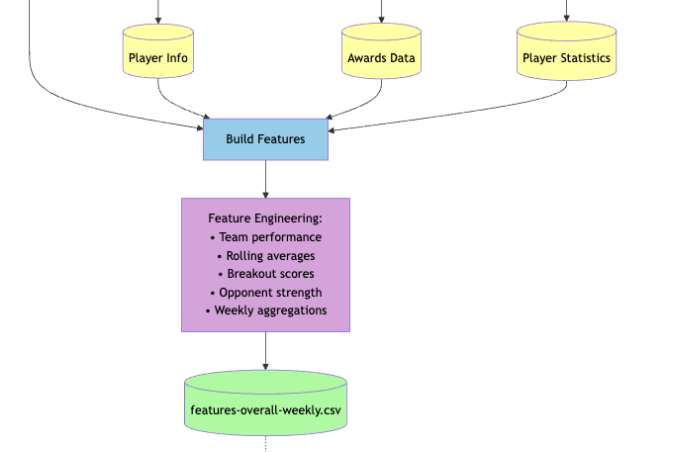

In [89]:
!pip install wget
!pip install duckdb
!pip install google-cloud-storage
!pip install pandas
!pip install numpy
import pandas as pd
import numpy as np
import duckdb
import wget
import os
from google.cloud import storage
import gc
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [90]:
# Download CSV files
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/nba-all-stars.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/nba-mvp.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/all-nba-first-team.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/all-nba-second-team.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/all-nba-third-team.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/player-of-the-week.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/player-statistics.csv')
wget.download('https://storage.googleapis.com/nba_award_predictor/nba_data/games.csv')

# Kaggle source data changed the gameDate column name to gameDateTimeEst on 11/24/25. This code reverts the column back to gameDate.
games_df = pd.read_csv('games.csv')
query = """
SELECT
gameId
,CAST(gameDateTimeEst AS DATE) AS gameDate
,hometeamCity
,hometeamName
,hometeamId
,awayteamCity
,awayteamName
,awayteamId
,homeScore
,awayScore
,winner
,gameType
,attendance
,arenaId
,gameLabel
,gameSubLabel
,seriesGameNumber
FROM games_df

"""
games_df = duckdb.query(query).df()
games_df.to_csv('games.csv')

def build_team_games(df, filter=None):
    df = df.copy()

    # Parse datetime with mixed formats
    df['gamedate'] = pd.to_datetime(
        df['gamedate'],
        utc=True,
        errors='coerce',
        format='mixed',
        dayfirst=True,
    )

    if filter:
        df = df.query(filter)

    # Normalize: make two rows per game (home + away)
    home = df.rename(columns={
        'hometeamname': 'team',
        'hometeamid':   'teamid',
        'homescore':    'team_score',
        'awayscore':    'opp_score'
    })[['gameid','gamedate','team','teamid','team_score','opp_score','winner',
        'awayteamname','awayteamid']].assign(
            home = 1,
            opponent  = lambda x: x['awayteamname'],
            opponentid= lambda x: x['awayteamid'],
        ).drop(columns=['awayteamname','awayteamid'])

    away = df.rename(columns={
        'awayteamname': 'team',
        'awayteamid':   'teamid',
        'awayscore':    'team_score',
        'homescore':    'opp_score'
    })[['gameid','gamedate','team','teamid','team_score','opp_score','winner',
        'hometeamname','hometeamid']].assign(
            home = 0,
            opponent  = lambda x: x['hometeamname'],
            opponentid= lambda x: x['hometeamid'],
        ).drop(columns=['hometeamname','hometeamid'])

    long = pd.concat([home, away], ignore_index=True)

    # Outcome flags
    long['is_win']  = (long['teamid'] == long['winner']).astype(int)
    long['outcome'] = long['is_win'].map({1: 'win', 0: 'loss'})
    long['is_home_win'] = ((long['home'] == 1) & (long['is_win'] == 1)).astype(int)
    long['is_away_win'] = ((long['home'] == 0) & (long['is_win'] == 1)).astype(int)

    # Season (season starts in July)
    year = long['gamedate'].dt.year
    month = long['gamedate'].dt.month
    long['season'] = np.where(month >= 7, year, year - 1)

    # Sort for rolling calculations
    long = long.sort_values(['teamid', 'season', 'gamedate', 'gameid'], kind='mergesort')

    # Group by team + season for all season-based stats
    g = long.groupby(['teamid', 'season'], group_keys=False)

    # Games played prior (per season)
    long['games_prior'] = g.cumcount()

    # Wins / losses prior (per season)
    long['wins_prior'] = g['is_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )
    long['losses_prior'] = long['games_prior'] - long['wins_prior']

    # Home / away games prior (per season)
    long['home_games_prior'] = g['home'].transform(
        lambda s: s.shift(fill_value=0).cumsum()
    )
    long['away_games_prior'] = long['games_prior'] - long['home_games_prior']

    # Home / away wins prior (per season)
    long['home_wins_prior'] = g['is_home_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )
    long['away_wins_prior'] = g['is_away_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )

    # Home / away losses prior (per season)
    long['home_losses_prior'] = long['home_games_prior'] - long['home_wins_prior']
    long['away_losses_prior'] = long['away_games_prior'] - long['away_wins_prior']

    # Win streaks prior (per season)
    def streak_prior(series):
        prior = series.shift().fillna(0).astype(int)
        # reset when we see a 0
        return prior.groupby((prior == 0).cumsum()).cumsum().astype(int)

    long['win_streak_prior'] = g['is_win'].transform(streak_prior)
    long['home_win_streak_prior'] = g['is_home_win'].transform(streak_prior)
    long['away_win_streak_prior'] = g['is_away_win'].transform(streak_prior)

    # Record strings (per season)
    long['record_prior'] = long['wins_prior'].astype(str) + '-' + long['losses_prior'].astype(str)
    long['home_record_prior'] = long['home_wins_prior'].astype(str) + '-' + long['home_losses_prior'].astype(str)
    long['away_record_prior'] = long['away_wins_prior'].astype(str) + '-' + long['away_losses_prior'].astype(str)

    # Opponent's prior record for same game (still season-based because wins_prior/losses_prior are)
    opp_prior = long[['gameid','teamid','wins_prior','losses_prior']].rename(
        columns={
            'teamid': 'opponentid',
            'wins_prior': 'opp_wins_prior',
            'losses_prior': 'opp_losses_prior'
        }
    )

    long = long.merge(opp_prior, on=['gameid','opponentid'], how='left')

    # Opponent winrate prior to the game
    opp_games_prior = long['opp_wins_prior'] + long['opp_losses_prior']
    long['opp_winrate_prior'] = long['opp_wins_prior'] / opp_games_prior.where(opp_games_prior > 0)

    # Flag for wins vs > .500 opponent (per game)
    long['is_win_vs_over_500'] = (
        (long['is_win'] == 1) &
        (long['opp_winrate_prior'] > 0.5)
    ).astype(int)

    # Per-team, per-season cumulative PRIOR wins vs > .500
    long['wins_vs_over_500_prior'] = (
        long.groupby(['teamid', 'season'])['is_win_vs_over_500']
            .transform(lambda s: s.shift().fillna(0).cumsum().astype(int))
    )

    # Week-based (Mon–Sun) record PRIOR, per-season
    iso = long['gamedate'].dt.isocalendar()
    long['week_year'] = iso['year']
    long['week_num']  = iso['week']

    gw = long.groupby(['teamid','season','week_year','week_num'], group_keys=False)

    long['week_games_prior'] = gw.cumcount()
    long['week_wins_prior'] = gw['is_win'].transform(
        lambda s: s.shift().fillna(0).cumsum().astype(int)
    )
    long['week_losses_prior'] = long['week_games_prior'] - long['week_wins_prior']

    long['week_record_prior'] = (
        long['week_wins_prior'].astype(str)
        + '-' +
        long['week_losses_prior'].astype(str)
    )

    # Final output
    out = long[['gameid','gamedate',
                'team','teamid',
                'opponent','opponentid',
                'outcome','home',
                'team_score','opp_score',
                'games_prior','wins_prior','losses_prior','record_prior',
                'home_games_prior','home_wins_prior','home_losses_prior','home_record_prior',
                'away_games_prior','away_wins_prior','away_losses_prior','away_record_prior',
                'win_streak_prior','home_win_streak_prior','away_win_streak_prior',
                'opp_wins_prior','opp_losses_prior','opp_winrate_prior',
                'is_win_vs_over_500','wins_vs_over_500_prior',
                'week_games_prior','week_wins_prior','week_losses_prior','week_record_prior',
                'season'
            ]]
    out.loc[:, 'gameid'] = out['gameid'].astype(int)
    out = out.rename(columns={'gameid': 'gameId'})

    return out.sort_values(['gamedate','gameId','home']).reset_index(drop=True)

def wins_vs_all_nba(first,second,third,stats):
    stats.rename(columns={"gameId": "game_id"}, inplace=True)
    all_nba = pd.concat([first, second, third], ignore_index=True)
    all_nba_player_ids = set(all_nba["player_id"].unique())

    rosters = (
        stats
        .groupby(["game_id", "playerteamName"])["player_id"]
        .apply(set)
        .reset_index()
        .rename(columns={"playerteamName": "team_name", "player_id": "roster"})
    )

    df = stats.merge(
        rosters.rename(columns={"team_name": "playerteamName",
                                "roster": "player_roster"}),
        on=["game_id", "playerteamName"],
        how="left"
    )

    df = df.merge(
        rosters.rename(columns={"team_name": "opponentteamName",
                                "roster": "opponent_roster"}),
        on=["game_id", "opponentteamName"],
        how="left"
    )

    def opponent_has_all_nba(roster):
        if isinstance(roster, set):
            return int(len(roster.intersection(all_nba_player_ids)) > 0)
        return 0

    df["opponent_has_all_nba"] = df["opponent_roster"].apply(opponent_has_all_nba)

    df["wins_vs_team_with_all_nba_player"] = (
        (df["win"] == 1) & (df["opponent_has_all_nba"] == 1)
    ).astype(int)

    df["player_name"] = df["full_name"]

    output = df[[
        "player_id",
        "player_name",
        "game_id",
        "playerteamName",
        "opponentteamName",
        "win",
        "opponent_has_all_nba",
        "wins_vs_team_with_all_nba_player"
    ]].sort_values("game_id").reset_index(drop=True)

    return output

games_df = pd.read_csv('games.csv')
games_df.columns = games_df.columns.str.lower()
game = build_team_games(games_df, "gamedate.dt.year >= 1979")

# The null values in game["opp_winrate_prior"] represent games where the opponent had played zero regular season
# games at that point (e.g. first game of the season). Set game["opp_winrate_prior"] to 0.500 for these rows.
game["opp_winrate_prior"] = game["opp_winrate_prior"].fillna(0.500)


team_info = {
    # Eastern Conference
    'Boston Celtics': {'conference': 'East', 'team_nickname': 'Celtics'},
    'Brooklyn Nets': {'conference': 'East', 'team_nickname': 'Nets'},
    'New York Knicks': {'conference': 'East', 'team_nickname': 'Knicks'},
    'Philadelphia 76ers': {'conference': 'East', 'team_nickname': '76ers'},
    'Philadelphia Sixers': {'conference': 'East', 'team_nickname': 'Sixers'},
    'Toronto Raptors': {'conference': 'East', 'team_nickname': 'Raptors'},
    'Chicago Bulls': {'conference': 'East', 'team_nickname': 'Bulls'},
    'Cleveland Cavaliers': {'conference': 'East', 'team_nickname': 'Cavaliers'},
    'Detroit Pistons': {'conference': 'East', 'team_nickname': 'Pistons'},
    'Indiana Pacers': {'conference': 'East', 'team_nickname': 'Pacers'},
    'Milwaukee Bucks': {'conference': 'East', 'team_nickname': 'Bucks'},
    'Atlanta Hawks': {'conference': 'East', 'team_nickname': 'Hawks'},
    'Charlotte Hornets': {'conference': 'East', 'team_nickname': 'Hornets'},
    'Miami Heat': {'conference': 'East', 'team_nickname': 'Heat'},
    'Orlando Magic': {'conference': 'East', 'team_nickname': 'Magic'},
    'Washington Wizards': {'conference': 'East', 'team_nickname': 'Wizards'},
    'Washington Bullets': {'conference': 'East', 'team_nickname': 'Bullets'},
    'New Jersey Nets': {'conference': 'East', 'team_nickname': 'Nets'},
    'Charlotte Bobcats': {'conference': 'East', 'team_nickname': 'Bobcats'},

    # Western Conference
    'Denver Nuggets': {'conference': 'West', 'team_nickname': 'Nuggets'},
    'Minnesota Timberwolves': {'conference': 'West', 'team_nickname': 'Timberwolves'},
    'Oklahoma City Thunder': {'conference': 'West', 'team_nickname': 'Thunder'},
    'Portland Trail Blazers': {'conference': 'West', 'team_nickname': 'Trail Blazers'},
    'Utah Jazz': {'conference': 'West', 'team_nickname': 'Jazz'},
    'Golden State Warriors': {'conference': 'West', 'team_nickname': 'Warriors'},
    'Los Angeles Clippers': {'conference': 'West', 'team_nickname': 'Clippers'},
    'LA Clippers': {'conference': 'West', 'team_nickname': 'Clippers'},
    'Los Angeles Lakers': {'conference': 'West', 'team_nickname': 'Lakers'},
    'Phoenix Suns': {'conference': 'West', 'team_nickname': 'Suns'},
    'Sacramento Kings': {'conference': 'West', 'team_nickname': 'Kings'},
    'Dallas Mavericks': {'conference': 'West', 'team_nickname': 'Mavericks'},
    'Houston Rockets': {'conference': 'West', 'team_nickname': 'Rockets'},
    'Memphis Grizzlies': {'conference': 'West', 'team_nickname': 'Grizzlies'},
    'New Orleans Pelicans': {'conference': 'West', 'team_nickname': 'Pelicans'},
    'San Antonio Spurs': {'conference': 'West', 'team_nickname': 'Spurs'},
    'Seattle SuperSonics': {'conference': 'West', 'team_nickname': 'SuperSonics'},
    'San Diego Clippers': {'conference': 'West', 'team_nickname': 'Clippers'},
    'Kansas City Kings': {'conference': 'West', 'team_nickname': 'Kings'},
    'New Orleans Hornets': {'conference': 'West', 'team_nickname': 'Hornets'},
    'Vancouver Grizzlies': {'conference': 'West', 'team_nickname': 'Grizzlies'},
    'Oklahoma City Hornets': {'conference': 'West', 'team_nickname': 'Hornets'},
    'New Orleans Jazz': {'conference': 'West', 'team_nickname': 'Jazz'}
}

team_conference_df = pd.DataFrame.from_dict(team_info, orient='index')
team_conference_df.index.name = 'team'
team_conference_df = team_conference_df.reset_index()

pow_df = pd.read_csv('player-of-the-week.csv')

query = """
WITH CTE AS (
SELECT
player_id
,season
,player
,team_conference_df.conference
,(CAST(date AS DATE) - 1) AS date
,DAY(CAST(date AS DATE) - 1) AS day
,WEEK(CAST(date AS DATE) - 1) AS week
,MONTH(CAST(date AS DATE) - 1) AS month
,YEAR(CAST(date AS DATE) - 1) AS year
,pow_df.team
,pos
,height
,weight
,age
,"Pre-Draft Team"
,"Draft Yr"
,yos

FROM pow_df
JOIN team_conference_df
ON pow_df.team = team_conference_df.team
)

SELECT * FROM CTE

"""

pow_df = duckdb.query(query).df()
pow_df = pow_df[['player_id','player','conference','date','day','week','month','year']]

query = """
SELECT
gameId
,CAST(gamedate AS DATE) AS gamedate
,DAY(CAST(gamedate AS DATE)) AS day
,WEEK(CAST(gamedate AS DATE)) AS week
,MONTH(CAST(gamedate AS DATE)) AS month
,YEAR(CAST(gamedate AS DATE)) AS year
,team
,teamid
,opponent
,opponentid
,outcome
,home
,team_score
,opp_score
,games_prior
,wins_prior
,losses_prior
,record_prior
,home_games_prior
,home_wins_prior
,home_losses_prior
,home_record_prior
,away_games_prior
,away_wins_prior
,away_losses_prior
,away_record_prior
,win_streak_prior
,home_win_streak_prior
,away_win_streak_prior
,opp_wins_prior
,opp_losses_prior
,opp_winrate_prior
,is_win_vs_over_500
,wins_vs_over_500_prior
,week_games_prior
,week_wins_prior
,week_losses_prior
,week_record_prior
,season
FROM game
"""

game = duckdb.query(query).df()

query = """

SELECT *
FROM game
JOIN pow_df
ON (game.week = pow_df.week AND game.year = pow_df.year)

"""

combined_df = duckdb.query(query).df()

combined_df = combined_df.rename(columns={'player_id':'pow_player_id','player':'player_of_the_week','conference':'pow_conference','date':'pow_last_date_of_week'})
player_statistics_df = pd.read_csv('player-statistics.csv')
stats = player_statistics_df = pd.read_csv('player-statistics.csv')

player_statistics_df = player_statistics_df[['firstName', 'lastName', 'full_name', 'player_id', 'gameId', 'gameDate', 'playerteamName',
'numMinutes', 'points', 'assists',
    'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
    'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
    'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
    'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
    'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints']]

query = """

SELECT *
FROM combined_df
LEFT JOIN player_statistics_df
ON combined_df.gameId = player_statistics_df.gameId AND combined_df.team = playerteamName
"""

game_and_player_stats_df = duckdb.query(query).df()
# Remove any performances where the player did not play
query = """

SELECT *
FROM game_and_player_stats_df
WHERE numMinutes IS NOT NULL
"""
game_and_player_stats_df = duckdb.query(query).df()


player_statistics_test_df = pd.read_csv('player-statistics.csv')
query = """

SELECT *,
    CASE
        WHEN gameDate BETWEEN '2025-10-02' AND '2026-08-01' THEN 2025
        WHEN gameDate BETWEEN '2024-10-04' AND '2025-06-22' THEN 2024
        WHEN gameDate BETWEEN '2023-10-05' AND '2024-06-17' THEN 2023
        WHEN gameDate BETWEEN '2022-09-30' AND '2023-06-12' THEN 2022
        WHEN gameDate BETWEEN '2021-10-03' AND '2022-06-16' THEN 2021
        WHEN gameDate BETWEEN '2020-12-11' AND '2021-07-20' THEN 2020
        WHEN gameDate BETWEEN '2019-10-22' AND '2020-10-11' THEN 2019
        WHEN gameDate BETWEEN '2018-10-16' AND '2019-06-10' THEN 2018
        WHEN gameDate BETWEEN '2017-09-30' AND '2018-06-08' THEN 2017
        WHEN gameDate BETWEEN '2016-10-01' AND '2017-06-12' THEN 2016
        WHEN gameDate BETWEEN '2015-10-02' AND '2016-06-19' THEN 2015
        WHEN gameDate BETWEEN '2014-10-04' AND '2015-06-16' THEN 2014
        WHEN gameDate BETWEEN '2013-10-05' AND '2014-06-15' THEN 2013
        WHEN gameDate BETWEEN '2012-10-05' AND '2013-06-20' THEN 2012
        WHEN gameDate BETWEEN '2011-12-16' AND '2012-06-21' THEN 2011
        WHEN gameDate BETWEEN '2010-10-03' AND '2011-06-12' THEN 2010
        WHEN gameDate BETWEEN '2009-10-01' AND '2010-06-17' THEN 2009
        WHEN gameDate BETWEEN '2008-10-05' AND '2009-06-11' THEN 2008
        WHEN gameDate BETWEEN '2007-10-06' AND '2008-06-17' THEN 2007
        WHEN gameDate BETWEEN '2006-10-05' AND '2007-06-14' THEN 2006
        WHEN gameDate BETWEEN '2005-10-10' AND '2006-04-19' THEN 2005
        WHEN gameDate BETWEEN '2004-11-02' AND '2005-06-21' THEN 2004
        WHEN gameDate BETWEEN '2003-10-28' AND '2004-06-15' THEN 2003
        WHEN gameDate BETWEEN '2002-10-29' AND '2003-06-15' THEN 2002
        WHEN gameDate BETWEEN '2001-10-30' AND '2002-04-17' THEN 2001
        WHEN gameDate BETWEEN '2000-10-31' AND '2001-06-15' THEN 2000
        WHEN gameDate BETWEEN '1999-11-02' AND '2000-04-19' THEN 1999
        WHEN gameDate BETWEEN '1998-02-05' AND '1999-06-25' THEN 1998
        WHEN gameDate BETWEEN '1997-10-31' AND '1998-06-14' THEN 1997
        WHEN gameDate BETWEEN '1996-11-01' AND '1997-06-13' THEN 1996
        WHEN gameDate BETWEEN '1995-11-03' AND '1996-04-21' THEN 1995
        WHEN gameDate BETWEEN '1994-11-04' AND '1995-06-14' THEN 1994
        WHEN gameDate BETWEEN '1993-11-05' AND '1994-04-24' THEN 1993
        WHEN gameDate BETWEEN '1992-11-06' AND '1993-06-20' THEN 1992
        WHEN gameDate BETWEEN '1991-11-01' AND '1992-06-12' THEN 1991
        WHEN gameDate BETWEEN '1990-11-02' AND '1991-06-12' THEN 1990
        WHEN gameDate BETWEEN '1989-11-03' AND '1990-06-14' THEN 1989
        WHEN gameDate BETWEEN '1988-11-04' AND '1989-06-13' THEN 1988
        WHEN gameDate BETWEEN '1987-11-06' AND '1988-06-19' THEN 1987
        WHEN gameDate BETWEEN '1986-10-31' AND '1987-06-14' THEN 1986
        WHEN gameDate BETWEEN '1985-10-25' AND '1986-06-05' THEN 1985
        WHEN gameDate BETWEEN '1984-10-26' AND '1985-06-09' THEN 1984
        WHEN gameDate BETWEEN '1983-10-28' AND '1984-06-12' THEN 1983
        WHEN gameDate BETWEEN '1982-10-29' AND '1983-05-31' THEN 1982
        WHEN gameDate BETWEEN '1981-10-30' AND '1982-06-06' THEN 1981
        WHEN gameDate BETWEEN '1980-10-10' AND '1981-05-14' THEN 1980
        WHEN gameDate BETWEEN '1979-10-12' AND '1980-05-16' THEN 1979
        WHEN gameDate BETWEEN '1978-10-13' AND '1979-06-01' THEN 1978
        WHEN gameDate BETWEEN '1977-10-18' AND '1978-06-07' THEN 1977
        WHEN gameDate BETWEEN '1976-02-13' AND '1977-06-05' THEN 1976
        WHEN gameDate BETWEEN '1976-02-03' AND '1976-06-06' THEN 1975
        WHEN gameDate BETWEEN '1974-10-17' AND '1975-05-25' THEN 1974
        WHEN gameDate BETWEEN '1973-10-09' AND '1974-05-12' THEN 1973
        WHEN gameDate BETWEEN '1972-10-10' AND '1973-05-10' THEN 1972
        WHEN gameDate BETWEEN '1971-10-12' AND '1972-05-07' THEN 1971
        WHEN gameDate BETWEEN '1971-01-12' AND '1971-04-30' THEN 1970
        WHEN gameDate BETWEEN '1969-10-14' AND '1970-05-08' THEN 1969
        WHEN gameDate BETWEEN '1968-10-15' AND '1969-03-24' THEN 1968
        WHEN gameDate BETWEEN '1967-10-13' AND '1968-05-02' THEN 1967
        WHEN gameDate BETWEEN '1967-01-10' AND '1967-04-24' THEN 1966
        WHEN gameDate BETWEEN '1965-10-15' AND '1966-04-28' THEN 1965
        WHEN gameDate BETWEEN '1964-10-16' AND '1965-03-21' THEN 1964
        WHEN gameDate BETWEEN '1963-10-16' AND '1964-04-26' THEN 1963
        WHEN gameDate BETWEEN '1962-10-19' AND '1963-04-24' THEN 1962
        WHEN gameDate BETWEEN '1961-02-16' AND '1962-04-18' THEN 1961
        WHEN gameDate BETWEEN '1961-01-17' AND '1961-01-17' THEN 1960
        WHEN gameDate BETWEEN '1959-10-18' AND '1960-04-09' THEN 1959
        WHEN gameDate BETWEEN '1958-10-19' AND '1959-03-11' THEN 1958
        WHEN gameDate BETWEEN '1957-10-22' AND '1958-03-12' THEN 1957
        WHEN gameDate BETWEEN '1956-10-27' AND '1957-04-13' THEN 1956
        WHEN gameDate BETWEEN '1955-11-05' AND '1956-04-05' THEN 1955
        WHEN gameDate BETWEEN '1954-10-30' AND '1955-04-10' THEN 1954
        WHEN gameDate BETWEEN '1953-10-30' AND '1954-04-11' THEN 1953
        WHEN gameDate BETWEEN '1952-10-31' AND '1953-04-10' THEN 1952
        WHEN gameDate BETWEEN '1951-11-01' AND '1952-04-23' THEN 1951
        WHEN gameDate BETWEEN '1950-10-31' AND '1951-04-21' THEN 1950
        WHEN gameDate BETWEEN '1949-10-29' AND '1950-04-23' THEN 1949
        WHEN gameDate BETWEEN '1948-11-01' AND '1949-04-13' THEN 1948
        WHEN gameDate BETWEEN '1947-11-12' AND '1948-04-21' THEN 1947
        WHEN gameDate BETWEEN '1946-11-01' AND '1947-04-22' THEN 1946
    END AS season
FROM player_statistics_test_df
"""
player_statistics_test_df = duckdb.query(query).df()

# Bring in all star data
nba_all_stars_df = pd.read_csv('nba-all-stars.csv')
nba_all_stars_df["Season"] = nba_all_stars_df["Selection Year"] - 1
nba_all_stars_df["player_id"] = nba_all_stars_df["player_id"].astype(int)
# Bring in mvp data
nba_mvp_df = pd.read_csv('nba-mvp.csv')
nba_mvp_df["Season"] = nba_mvp_df["Season"].str[:4].astype(int)
# Bring in 1st team all-nba data
all_nba_first_team_df = pd.read_csv('all-nba-first-team.csv')
all_nba_first_team_df["Season"] = all_nba_first_team_df["Season"].str[:4].astype(int)
# Bring in 2nd team all-nba data
all_nba_second_team_df = pd.read_csv('all-nba-second-team.csv')
all_nba_second_team_df["Season"] = all_nba_second_team_df["Season"].str[:4].astype(int)
# Bring in 3rd team all-nba data
all_nba_third_team_df = pd.read_csv('all-nba-third-team.csv')
all_nba_third_team_df["Season"] = all_nba_third_team_df["Season"].str[:4].astype(int)

first = all_nba_first_team_df
second = all_nba_second_team_df
third = all_nba_third_team_df

query = """

WITH All_Star_Flag AS
(
SELECT *,
'Yes' AS all_star_this_season
FROM nba_all_stars_df
)

,MVP_Flag AS (
SELECT *,
'Yes' AS mvp_this_season
FROM nba_mvp_df
)

,All_NBA_First_Team_Flag AS (
SELECT *,
'Yes' AS all_nba_first_team_this_season
FROM all_nba_first_team_df
)

,All_NBA_Second_Team_Flag AS (
SELECT *,
'Yes' AS all_nba_second_team_this_season
FROM all_nba_second_team_df
)

,All_NBA_Third_Team_Flag AS (
SELECT *,
'Yes' AS all_nba_third_team_this_season
FROM all_nba_third_team_df
)

SELECT
player_statistics_test_df.firstName
,player_statistics_test_df.lastName
,player_statistics_test_df.full_name
,player_statistics_test_df.player_id
,player_statistics_test_df.gameId
,CAST(player_statistics_test_df.gameDate AS DATE) AS gameDate
,player_statistics_test_df.playerteamCity
,player_statistics_test_df.playerteamName
,player_statistics_test_df.opponentteamCity
,player_statistics_test_df.opponentteamName
,player_statistics_test_df.gameType
,player_statistics_test_df.gameLabel
,player_statistics_test_df.gameSubLabel
,player_statistics_test_df.seriesGameNumber
,player_statistics_test_df.win
,player_statistics_test_df.home
,player_statistics_test_df.numMinutes
,CAST(player_statistics_test_df.points AS INT) AS points
,CAST(player_statistics_test_df.assists AS INT) AS assists
,CAST(player_statistics_test_df.blocks AS INT) AS blocks
,CAST(player_statistics_test_df.steals AS INT) AS steals
,CAST(player_statistics_test_df.fieldGoalsAttempted AS INT) AS fieldGoalsAttempted
,CAST(player_statistics_test_df.fieldGoalsMade AS INT) AS fieldGoalsMade
,player_statistics_test_df.fieldGoalsPercentage
,CAST(player_statistics_test_df.threePointersAttempted AS INT) AS threePointersAttempted
,CAST(player_statistics_test_df.threePointersMade AS INT) AS threePointersMade
,player_statistics_test_df.threePointersPercentage
,CAST(player_statistics_test_df.freeThrowsAttempted AS INT) AS freeThrowsAttempted
,CAST(player_statistics_test_df.freeThrowsMade AS INT) AS freeThrowsMade
,player_statistics_test_df.freeThrowsPercentage
,CAST(player_statistics_test_df.reboundsDefensive AS INT) AS reboundsDefensive
,CAST(player_statistics_test_df.reboundsOffensive AS INT) AS reboundsOffensive
,CAST(player_statistics_test_df.reboundsTotal AS INT) AS reboundsTotal
,CAST(player_statistics_test_df.foulsPersonal AS INT) AS foulsPersonal
,CAST(player_statistics_test_df.turnovers AS INT) AS turnovers
,CAST(player_statistics_test_df.plusMinusPoints AS INT) AS plusMinusPoints
,player_statistics_test_df.season

,All_Star_Flag.all_star_this_season
,MVP_Flag.mvp_this_season
,All_NBA_First_Team_Flag.all_nba_first_team_this_season
,All_NBA_Second_Team_Flag.all_nba_second_team_this_season
,All_NBA_Third_Team_Flag.all_nba_third_team_this_season

FROM player_statistics_test_df
LEFT JOIN All_Star_Flag
ON All_Star_Flag.player_id = player_statistics_test_df.player_id AND All_Star_Flag.Season = player_statistics_test_df.Season
LEFT JOIN MVP_Flag
ON MVP_Flag.player_id = player_statistics_test_df.player_id AND MVP_Flag.Season = player_statistics_test_df.Season
LEFT JOIN All_NBA_First_Team_Flag
ON All_NBA_First_Team_Flag.player_id = player_statistics_test_df.player_id AND All_NBA_First_Team_Flag.Season = player_statistics_test_df.Season
LEFT JOIN All_NBA_Second_Team_Flag
ON All_NBA_Second_Team_Flag.player_id = player_statistics_test_df.player_id AND All_NBA_Second_Team_Flag.Season = player_statistics_test_df.Season
LEFT JOIN All_NBA_Third_Team_Flag
ON All_NBA_Third_Team_Flag.player_id = player_statistics_test_df.player_id AND All_NBA_Third_Team_Flag.Season = player_statistics_test_df.Season


"""
result_df = duckdb.query(query).df()
result_df["all_star_this_season"] = np.where(result_df["all_star_this_season"] == 'Yes',1,0)
result_df["mvp_this_season"] = np.where(result_df["mvp_this_season"] == 'Yes',1,0)
result_df["all_nba_first_team_this_season"] = np.where(result_df["all_nba_first_team_this_season"] == 'Yes',1,0)
result_df["all_nba_second_team_this_season"] = np.where(result_df["all_nba_second_team_this_season"] == 'Yes',1,0)
result_df["all_nba_third_team_this_season"] = np.where(result_df["all_nba_third_team_this_season"] == 'Yes',1,0)
player_stats_with_allstar_mvp_allnba_df = result_df


query = """
SELECT
player_stats_with_allstar_mvp_allnba_df.gameId
,player_stats_with_allstar_mvp_allnba_df.gamedate
,day
,week
,month
,year
,team
,teamid
,player_stats_with_allstar_mvp_allnba_df.firstName
,player_stats_with_allstar_mvp_allnba_df.lastName
,player_stats_with_allstar_mvp_allnba_df.full_name
,player_stats_with_allstar_mvp_allnba_df.player_id
,opponent
,opponentid
,outcome
,player_stats_with_allstar_mvp_allnba_df.home as home
,team_score
,opp_score
,games_prior
,wins_prior
,losses_prior
,record_prior
,home_games_prior
,home_wins_prior
,home_losses_prior
,home_record_prior
,away_games_prior
,away_wins_prior
,away_losses_prior
,away_record_prior
,win_streak_prior
,home_win_streak_prior
,away_win_streak_prior
,opp_wins_prior
,opp_losses_prior
,opp_winrate_prior
,is_win_vs_over_500
,wins_vs_over_500_prior
,week_games_prior
,week_wins_prior
,week_losses_prior
,week_record_prior
,player_stats_with_allstar_mvp_allnba_df.season
,pow_player_id
,player_of_the_week
,pow_conference
,pow_last_date_of_week
,player_stats_with_allstar_mvp_allnba_df.numMinutes
,CAST(player_stats_with_allstar_mvp_allnba_df.points AS INT) AS points
,CAST(player_stats_with_allstar_mvp_allnba_df.assists AS INT) AS assists
,CAST(player_stats_with_allstar_mvp_allnba_df.blocks AS INT) AS blocks
,CAST(player_stats_with_allstar_mvp_allnba_df.steals AS INT) AS steals
,CAST(player_stats_with_allstar_mvp_allnba_df.fieldGoalsAttempted AS INT) AS fieldGoalsAttempted
,CAST(player_stats_with_allstar_mvp_allnba_df.fieldGoalsMade AS INT) AS fieldGoalsMade
,player_stats_with_allstar_mvp_allnba_df.fieldGoalsPercentage
,CAST(player_stats_with_allstar_mvp_allnba_df.threePointersAttempted AS INT) AS threePointersAttempted
,CAST(player_stats_with_allstar_mvp_allnba_df.threePointersMade AS INT) AS threePointersMade
,player_stats_with_allstar_mvp_allnba_df.threePointersPercentage
,CAST(player_stats_with_allstar_mvp_allnba_df.freeThrowsAttempted AS INT) AS freeThrowsAttempted
,CAST(player_stats_with_allstar_mvp_allnba_df.freeThrowsMade AS INT) AS freeThrowsMade
,player_stats_with_allstar_mvp_allnba_df.freeThrowsPercentage
,CAST(player_stats_with_allstar_mvp_allnba_df.reboundsDefensive AS INT) AS reboundsDefensive
,CAST(player_stats_with_allstar_mvp_allnba_df.reboundsOffensive AS INT) AS reboundsOffensive
,CAST(player_stats_with_allstar_mvp_allnba_df.reboundsTotal AS INT) AS reboundsTotal
,CAST(player_stats_with_allstar_mvp_allnba_df.foulsPersonal AS INT) AS foulsPersonal
,CAST(player_stats_with_allstar_mvp_allnba_df.turnovers AS INT) AS turnovers
,CAST(player_stats_with_allstar_mvp_allnba_df.plusMinusPoints AS INT) AS plusMinusPoints
,all_star_this_season
,mvp_this_season
,all_nba_first_team_this_season
,all_nba_second_team_this_season
,all_nba_third_team_this_season
FROM game_and_player_stats_df
JOIN player_stats_with_allstar_mvp_allnba_df
ON
(
game_and_player_stats_df.player_id = player_stats_with_allstar_mvp_allnba_df.player_id
AND
game_and_player_stats_df.gameId = player_stats_with_allstar_mvp_allnba_df.gameId
AND
game_and_player_stats_df.team = player_stats_with_allstar_mvp_allnba_df.playerTeamName
)

"""
overall_features_df = duckdb.query(query).df()

#Create target variable column for player of the week
overall_features_df["won_player_of_the_week"] = np.where(overall_features_df.pow_player_id == overall_features_df.player_id,1,0)

# Consider each player with respect to their conference. An Eastern Conference player is not eligible for Western Conference POW, and vice versa
query = """
SELECT *,
FROM overall_features_df
JOIN team_conference_df
ON overall_features_df.team = team_conference_df.team_nickname AND overall_features_df.pow_conference = team_conference_df.conference
"""
overall_features_df = duckdb.query(query).df()

wins_vs_all_nba_df = wins_vs_all_nba(first,second,third,stats)

query = """
SELECT overall_features_df.*
,wins_vs_all_nba_df.win
,wins_vs_all_nba_df.opponent_has_all_nba
,wins_vs_all_nba_df.wins_vs_team_with_all_nba_player

FROM

overall_features_df
JOIN wins_vs_all_nba_df
ON (
overall_features_df.gameId = wins_vs_all_nba_df.game_id
AND
overall_features_df.player_id = wins_vs_all_nba_df.player_id
AND
overall_features_df.team = wins_vs_all_nba_df.playerteamName
)

"""
overall_features_df = duckdb.query(query).df()
overall_features_df['week_start'] = overall_features_df['gameDate'] - overall_features_df['gameDate'].dt.weekday.astype('timedelta64[D]')

# weekly team aggregates
team_week = (
    overall_features_df.groupby(["team","season","week_start"], as_index=False)
    .agg(team_pts=("points","sum"),
        team_ast=("assists","sum"),
        team_blk=("blocks","sum"),
        team_stl=("steals","sum"),
        team_gms=("gameId","nunique"))
)

# weekly playeraggregates
player_week = (
    overall_features_df.groupby(["player_id","team","season","week_start","week"], as_index=False)
    .agg(gms=("gameId","nunique"),
        min_sum=("numMinutes","sum"),
        pts_sum=("points","sum"),
        ast_sum=("assists","sum"),
        blk_sum=("blocks","sum"),
        stl_sum=("steals","sum"),
        pm_sum =("plusMinusPoints","sum"),
        pm_mean=("plusMinusPoints","mean"),
        wins=("win","sum"))
)

feat = player_week.merge(
    team_week,
    on=["team","season","week_start"],
    how="inner"
)

# Z-score breakout features
feat = feat.sort_values(["player_id","season","week_start"])
def add_hist_stats(g):
    for col in ["pts_sum","ast_sum","pm_sum"]:
        g[f"{col}_mean_season"] = g[col].expanding().mean().shift(1)
        g[f"{col}_std_season"]  = g[col].expanding().std(ddof=0).shift(1)
    return g

feat = feat.groupby(["player_id","season"], group_keys=False).apply(add_hist_stats)
feat = feat.dropna() #Null rows represent the first week of the season, aka no rolling average to look at

def zscore(x, mu, sd):
    x = x.astype(float); mu = mu.astype(float); sd = sd.astype(float)
    return np.where(sd > 0, (x - mu) / sd, 0.0)

query = """
SELECT * FROM
overall_features_df
JOIN feat
ON (
overall_features_df.player_id = feat.player_id
AND
overall_features_df.week_start = feat.week_start
AND
overall_features_df.team_nickname = feat.team
)
"""

overall_features_df = duckdb.query(query).df()

overall_features_df = overall_features_df[[
    'gameId', 'gameDate', 'day', 'week', 'month', 'year', 'team', 'teamid',
    'firstName', 'lastName', 'full_name', 'player_id', 'opponent', 'opponentid',
    'outcome', 'home', 'team_score', 'opp_score', 'games_prior', 'wins_prior',
    'losses_prior', 'record_prior', 'home_games_prior', 'home_wins_prior',
    'home_losses_prior', 'home_record_prior', 'away_games_prior', 'away_wins_prior',
    'away_losses_prior', 'away_record_prior', 'win_streak_prior', 'home_win_streak_prior',
    'away_win_streak_prior', 'opp_wins_prior', 'opp_losses_prior', 'opp_winrate_prior',
    'is_win_vs_over_500', 'wins_vs_over_500_prior', 'week_games_prior', 'week_wins_prior',
    'week_losses_prior', 'week_record_prior', 'season', 'pow_player_id',
    'player_of_the_week', 'pow_conference', 'pow_last_date_of_week', 'numMinutes',
    'points', 'assists', 'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
    'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
    'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
    'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal',
    'foulsPersonal', 'turnovers', 'plusMinusPoints', 'all_star_this_season',
    'mvp_this_season', 'all_nba_first_team_this_season',
    'all_nba_second_team_this_season', 'all_nba_third_team_this_season',
    'won_player_of_the_week', 'conference', 'team_nickname', 'win',
    'opponent_has_all_nba', 'wins_vs_team_with_all_nba_player', 'week_start',
    'gms', 'min_sum', 'pts_sum', 'ast_sum', 'blk_sum', 'stl_sum', 'pm_sum',
    'pm_mean', 'wins', 'team_pts', 'team_ast', 'team_blk', 'team_stl', 'team_gms',
    'pts_sum_mean_season', 'pts_sum_std_season', 'ast_sum_mean_season',
    'ast_sum_std_season', 'pm_sum_mean_season', 'pm_sum_std_season'
    ]]

query = """
SELECT
player_id
,full_name
,team
,season
,week
,week_start
,conference
,pow_conference
,COUNT(DISTINCT gameId) AS games_played_this_week
,SUM(numMinutes) AS numMinutes
,SUM(points) AS points
,SUM(assists) AS assists
,SUM(blocks) AS blocks
,SUM(steals) AS steals
,SUM(reboundsTotal) AS reboundsTotal
,SUM(reboundsDefensive) AS reboundsDefensive
,SUM(reboundsOffensive) AS reboundsOffensive
,SUM(fieldGoalsAttempted) AS fieldGoalsAttempted
,SUM(fieldGoalsMade) AS fieldGoalsMade
,SUM(threePointersAttempted) AS threePointersAttempted
,SUM(threePointersMade) AS threePointersMade
,SUM(freeThrowsAttempted) AS freeThrowsAttempted
,SUM(freeThrowsMade) AS freeThrowsMade
,SUM(turnovers) AS turnovers
,SUM(foulsPersonal) AS foulsPersonal
,SUM(plusMinusPoints) AS plusMinusPoints
,SUM(win) AS wins_this_week
,SUM(wins_vs_team_with_all_nba_player) AS wins_vs_team_with_all_nba_player
,SUM(is_win_vs_over_500) AS is_win_vs_over_500
,SUM(opponent_has_all_nba) AS opponent_has_all_nba
,AVG(opp_score) AS avg_opp_score
,AVG(opp_winrate_prior) AS avg_opp_winrate_prior
,AVG(opp_wins_prior) AS avg_opp_wins_prior
,AVG(opp_losses_prior) AS avg_opp_losses_prior
,MAX(away_games_prior) AS away_games_prior
,MAX(away_losses_prior) AS away_losses_prior
,MAX(away_win_streak_prior) AS away_win_streak_prior
,MAX(away_wins_prior) AS away_wins_prior
,MAX(home_games_prior) AS home_games_prior
,MAX(home_losses_prior) AS home_losses_prior
,MAX(home_win_streak_prior) AS home_win_streak_prior
,MAX(home_wins_prior) AS home_wins_prior
,MAX(losses_prior) AS losses_prior
,MAX(wins_vs_over_500_prior) AS wins_vs_over_500_prior
,MAX(won_player_of_the_week) AS won_player_of_the_week
,MAX(all_star_this_season) AS all_star_this_season
,MAX(mvp_this_season) AS mvp_this_season
,MAX(all_nba_first_team_this_season) AS all_nba_first_team_this_season
,MAX(all_nba_second_team_this_season) AS all_nba_second_team_this_season
,MAX(all_nba_third_team_this_season) AS all_nba_third_team_this_season
,MAX(team_pts) AS team_pts
,MAX(team_ast) AS team_ast
,MAX(team_blk) AS team_blk
,MAX(team_stl) AS team_stl
,MAX(team_gms) AS team_gms
,MAX(pow_player_id) AS pow_player_id
,MAX(player_of_the_week) AS player_of_the_week

FROM overall_features_df
GROUP BY player_id, full_name, team, season, week, week_start, conference, pow_conference
ORDER BY player_id, season, week_start
"""
overall_weekly_agg_df = duckdb.query(query).df()
overall_weekly_agg_df['fieldGoalsPercentage'] = np.where(overall_weekly_agg_df['fieldGoalsAttempted'] > 0, overall_weekly_agg_df['fieldGoalsMade'] / overall_weekly_agg_df['fieldGoalsAttempted'], 0)
overall_weekly_agg_df['threePointersPercentage'] = np.where(overall_weekly_agg_df['threePointersAttempted'] > 0, overall_weekly_agg_df['threePointersMade'] / overall_weekly_agg_df['threePointersAttempted'], 0)
overall_weekly_agg_df['freeThrowsPercentage'] = np.where(overall_weekly_agg_df['freeThrowsAttempted'] > 0, overall_weekly_agg_df['freeThrowsMade'] / overall_weekly_agg_df['freeThrowsAttempted'], 0)

# Recalculate rolling averages on weekly level
def add_weekly_hist_stats(g):
    for col in ["points", "assists", "plusMinusPoints"]:
        g[f"{col}_mean_season"] = g[col].expanding().mean().shift(1)
        g[f"{col}_std_season"] = g[col].expanding().std(ddof=0).shift(1)
    return g

overall_weekly_agg_df = overall_weekly_agg_df.groupby(["player_id", "season"], group_keys=False).apply(add_weekly_hist_stats)

# Nulls here represent a player's first week of the season, therefore he has no rolling averages yet. Drop nulls.
overall_weekly_agg_df = overall_weekly_agg_df.dropna(subset=['points_mean_season'])

# Calculate z-scores and breakout score for the weekly aggregate
overall_weekly_agg_df["z_pts"] = zscore(overall_weekly_agg_df["points"], overall_weekly_agg_df["points_mean_season"], overall_weekly_agg_df["points_std_season"])
overall_weekly_agg_df["z_ast"] = zscore(overall_weekly_agg_df["assists"], overall_weekly_agg_df["assists_mean_season"], overall_weekly_agg_df["assists_std_season"])
overall_weekly_agg_df["z_pm"] = zscore(overall_weekly_agg_df["plusMinusPoints"], overall_weekly_agg_df["plusMinusPoints_mean_season"], overall_weekly_agg_df["plusMinusPoints_std_season"])
overall_weekly_agg_df["breakout_score"] = (0.5 * overall_weekly_agg_df["z_pts"] + 0.3 * overall_weekly_agg_df["z_ast"] + 0.2 * overall_weekly_agg_df["z_pm"])

##############################################################################################################
# Adding new features on 12/3/25 #
df = overall_weekly_agg_df.sort_values(["season", "week"]).copy()
# Compute league-wide stats per season
league_prev = (
   df.groupby("season")
     .agg(
         league_pts_mean=("points", "mean"),
         league_pts_std=("points", "std"),
         league_ast_mean=("assists", "mean"),
         league_ast_std=("assists", "std"),
         league_pm_mean=("plusMinusPoints", "mean"),
         league_pm_std=("plusMinusPoints", "std")
     )
     .reset_index()
)
# Shift season down by 1 to normalize on previous season league-wide stats
league_prev["season"] = league_prev["season"] + 1
df = df.merge(league_prev, on="season", how="left")
# Compute z-scores
df["z_s_pts"] = (df["points"] - df["league_pts_mean"]) / df["league_pts_std"]
df["z_s_ast"] = (df["assists"] - df["league_ast_mean"]) / df["league_ast_std"]
df["z_s_pm"]  = (df["plusMinusPoints"] - df["league_pm_mean"]) / df["league_pm_std"]
# first-season rows have no previous season stats, fill with 0
df[["z_s_pts", "z_s_ast", "z_s_pm"]] = df[["z_s_pts", "z_s_ast", "z_s_pm"]].fillna(0)
overall_weekly_agg_df = df

###################################################################################################

# Save output to CSV
overall_weekly_agg_df.to_csv('features_overall_weekly.csv',index=False)

# Delete CSV files
os.remove('nba-all-stars.csv')
os.remove('nba-mvp.csv')
os.remove('all-nba-first-team.csv')
os.remove('all-nba-second-team.csv')
os.remove('all-nba-third-team.csv')
os.remove('player-of-the-week.csv')
os.remove('player-statistics.csv')
os.remove('games.csv')

del game, combined_df, game_and_player_stats_df, player_statistics_test_df
del first, second, third, nba_all_stars_df, nba_mvp_df

# Upload to GCS
credentials_path = 'cis-5450-final-project-485661e2f371.json'
try:
    storage_client = storage.Client.from_service_account_json(credentials_path)
    bucket_name = 'nba_award_predictor'
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob('nba_data/features-overall-weekly.csv')
    blob.cache_control = "max-age=0"
    blob.upload_from_filename('features_overall_weekly.csv')
except:
    print("File saved locally but not uploaded to GCS (Hint: check for json credentials file)")

/var/folders/l7/4kz3974x4pd5w682h233sl8w0000gn/T/ipykernel_65626/1575224776.py:12: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('games.csv')
/var/folders/l7/4kz3974x4pd5w682h233sl8w0000gn/T/ipykernel_65626/1575224776.py:258: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('games.csv')
/var/folders/l7/4kz3974x4pd5w682h233sl8w0000gn/T/ipykernel_65626/1575224776.py:412: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  player_statistics_df = pd.read_csv('player-statistics.csv')
/var/folders/l7/4kz3974x4pd5w682h233sl8w0000gn/T/ipykernel_65626/1575224776.py:413: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  stats = player_statistics_df = pd.read_csv('player-statistics.csv')
/var/folders/l7/4kz3974x4pd5w682h233sl8w0000gn/

File saved locally but not uploaded to GCS (Hint: check for json credentials file)


# Part 2: Exploratory Data Analysis (EDA)

Since we have 100+ features in our final data ('features_overall_weekly'), we will now conduct exploratory analysis on select features to showcase their potential predictor value and explore overlying patterns of our winner vs. non-winner data in order to grasp a bigger picture of the usefulness of our data. This will help shape our model selection and set up.

In [91]:
df = pd.read_csv('features_overall_weekly.csv')
df.head()

,player_id,full_name,team,season,week,week_start,conference,pow_conference,games_played_this_week,numMinutes,...,breakout_score,league_pts_mean,league_pts_std,league_ast_mean,league_ast_std,league_pm_mean,league_pm_std,z_s_pts,z_s_ast,z_s_pm
0,305,Robert Parish,Warriors,1979,1,1979-12-31,West,West,3,101.0,...,-0.157848,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,76003,Kareem Abdul-Jabbar,Lakers,1979,1,1979-12-31,West,West,2,82.0,...,-1.218188,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,76005,Tom Abernethy,Warriors,1979,1,1979-12-31,West,West,1,11.0,...,-1.365436,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,76011,Alvan Adams,Suns,1979,1,1979-12-31,West,West,2,64.0,...,-0.576144,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,76085,James Bailey,SuperSonics,1979,1,1979-12-31,West,West,4,41.0,...,0.643651,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [92]:
query = """
WITH CTE AS (
SELECT player_id
,full_name
,team
,season
,week
,week_start
,conference
,won_player_of_the_week
,all_star_this_season
,mvp_this_season
,(all_nba_first_team_this_season + all_nba_second_team_this_season + all_nba_third_team_this_season) AS all_nba
FROM df
WHERE won_player_of_the_week = 1
AND season < 2025
)

SELECT season
,SUM(all_star_this_season)/COUNT(*) AS pct_of_awards_given_to_all_stars
,SUM(mvp_this_season)/COUNT(*) AS pct_of_awards_given_to_mvp
,SUM(all_nba)/COUNT(*) AS pct_of_awards_given_to_all_nba
FROM CTE
GROUP BY season
ORDER BY season
"""
award_summary_df = duckdb.query(query).df()
award_summary_df.head()

,season,pct_of_awards_given_to_all_stars,pct_of_awards_given_to_mvp,pct_of_awards_given_to_all_nba
0,1979,0.631579,0.105263,0.368421
1,1980,0.523810,0.047619,0.285714
2,1981,0.750000,0.100000,0.600000
3,1982,0.666667,0.047619,0.476190
4,1983,0.818182,0.090909,0.590909


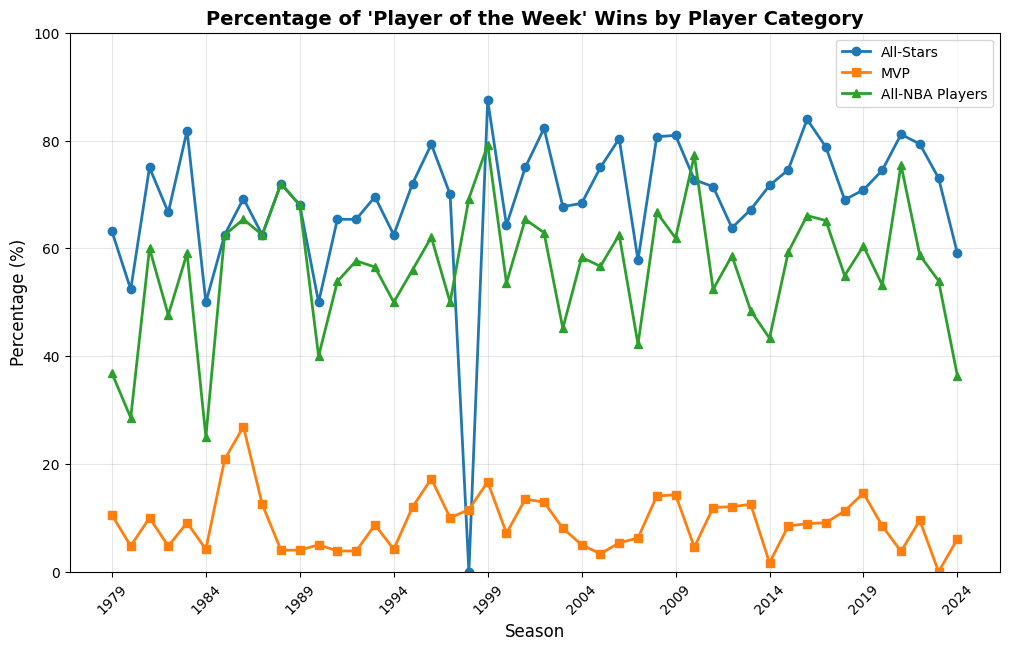

In [93]:
plt.figure(figsize=(12, 7))

plt.plot(award_summary_df['season'], award_summary_df['pct_of_awards_given_to_all_stars'] * 100, marker='o', label='All-Stars', linewidth=2)
plt.plot(award_summary_df['season'], award_summary_df['pct_of_awards_given_to_mvp'] * 100, marker='s', label='MVP', linewidth=2)
plt.plot(award_summary_df['season'], award_summary_df['pct_of_awards_given_to_all_nba'] * 100, marker='^', label='All-NBA Players', linewidth=2)

plt.xlabel('Season', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title("Percentage of 'Player of the Week' Wins by Player Category", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.xticks(range(min(df['season']), max(df['season'])+1, 5), rotation=45);

*   The vast majority of Player of the Week wins are by players who are All-Stars the same season


*   The graph correctly shows there were no NBA All Stars in 1998. This occured due to a shortened season (lockout)


*   The graph shows that the 2023 MVP (Nikola Jokic) never won Player of the Week that season. Jokic actually won it once, during the 1st week of that season. However, the row representing that week is missing from our dataframe because we deliberately dropped all first-week-of-season rows during Feature Engineering. This was done because first-week-of-season rows have null values for our "in-season rolling average" features.

In [94]:
# player win share (using won_player_of_the_week and wins_this_week)
print("Player of the Week Statistics:")
pow_winners = df[df['won_player_of_the_week'] == 1]
non_winners = df[df['won_player_of_the_week'] == 0]
print(f"Total PoW awards: {len(pow_winners)}")

print("\nMost PoW Awards (Top 10):")
top_pow = pow_winners['full_name'].value_counts().head(10)
print(top_pow)

Player of the Week Statistics:
Total PoW awards: 1945

Most PoW Awards (Top 10):
full_name
LeBron James             81
Kevin Durant             48
Giannis Antetokounmpo    38
Kobe Bryant              36
James Harden             35
Allen Iverson            33
Tim Duncan               32
Russell Westbrook        29
Karl Malone              28
Dirk Nowitzki            27
Name: count, dtype: int64


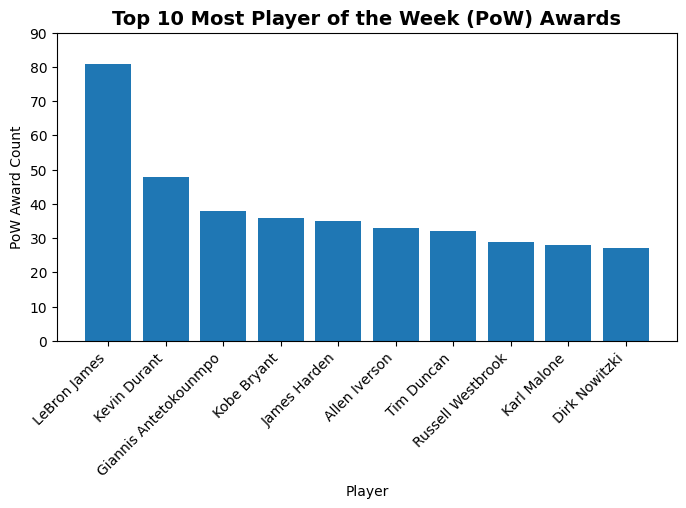

In [95]:
# Most PoW Awards Visual
plt.figure(figsize=(8,4))
plt.bar(top_pow.index, top_pow.values)
plt.xlabel("Player")
plt.ylim(0, 90)
plt.xticks(rotation=45, ha='right')
plt.ylabel("PoW Award Count")
plt.title("Top 10 Most Player of the Week (PoW) Awards", fontsize=14, fontweight='bold')
plt.show()

* Since the first week of December 2025, there have been 1941 Player of the Week awards. We see that the player that has won the award the most is Lebron James. This is evident to the longevity of his successful career. He currently is the longest tenured player in the NBA. This is no surprise given that he is considered one of the greatest of all time (G.O.A.T).

* For all top 10 winners, they are all hall of famers or confidently will be once retired for active players. For our top 3 winners, Lebron James, Kevin Durant, Giannis Antetokounmpo, they are all still active players in the NBA. Thus, their total award count may increase in the future.

* It is important to note that the Player of the Week award began in 1979. As a result historically dominant players like Wilt Chamberlain, Bill Russell, and Oscar Robertson would have likely won Player of the Week as well, possibly changing our top 10 winners.

/var/folders/l7/4kz3974x4pd5w682h233sl8w0000gn/T/ipykernel_85459/1099119374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pow_winners['award_week'] = pd.to_datetime(pow_winners['week_start'])


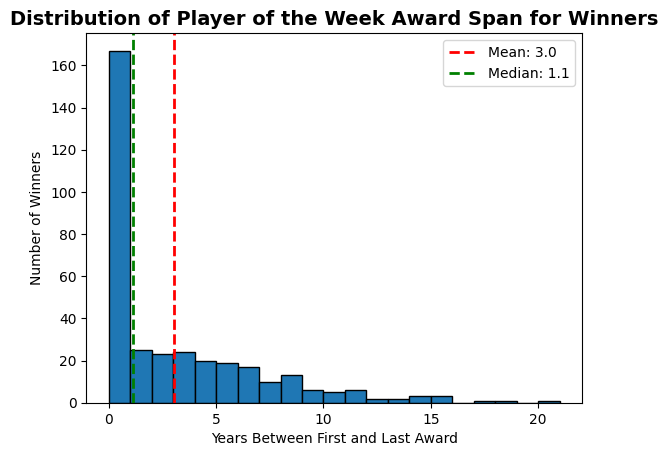

Distribution Metrics:
Mean: 3.02
Median: 1.12
Max: 20.21
Min: 0.00


In [9]:
# Distribution of time span of first to last player of the week award for winners
pow_winners['award_week'] = pd.to_datetime(pow_winners['week_start'])
award_span = pow_winners.groupby('full_name')['award_week'].agg(lambda x: (x.max() - x.min()).days / 365) # Calculates year(s)

mean_span = award_span.mean()
median_span = award_span.median()
max_span = award_span.max()
min_span = award_span.min()

plt.hist(award_span, bins=range(0, int(award_span.max()) + 2), edgecolor='black')

# Add vertical lines for statistics
plt.axvline(mean_span, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_span:.1f}')
plt.axvline(median_span, color='green', linestyle='--', linewidth=2, label=f'Median: {median_span:.1f}')


plt.xlabel('Years Between First and Last Award')
plt.ylabel('Number of Winners')
plt.title('Distribution of Player of the Week Award Span for Winners', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

print('Distribution Metrics:')
print(f"Mean: {mean_span:.2f}")
print(f"Median: {median_span:.2f}")
print(f"Max: {max_span:.2f}")
print(f"Min: {min_span:.2f}")

* From our distribution, we see that our minimum time span of awards won is 0 and has the highest distribution count. This showcases that for majority of our winners, they have only won 1 Player of the Week. This provides evidence that players who had dominant week(s) within a single season do win the award.

* For our winners, the median is ~1 and the mean is 3. This showcases that of median of our winners have an award span of 1 year/season and mean award span is 3 years/seasons. Lastly, our max award span is ~20 years. This identifies Lebron James who has been in the NBA for 23 seasons (he has not won award since over a year ago).

In [19]:
# Wins over the week (wins_this_week)

# Collect all comparison results for visualization
metrics = []
pow_res = []
npow_res = []

print("\nWins This Week:")
print(f"Average: {df['wins_this_week'].mean():.2f}")
print(f"Standard Deviation: {df['wins_this_week'].std():.2f}")

p = pow_winners['wins_this_week'].mean()
n = non_winners['wins_this_week'].mean()
print(f"PoW Winners Avg: {p:.2f}")
print(f"Non-Winners Avg: {n:.2f}")

metrics.append("Wins")
pow_res.append(p)
npow_res.append(n)


Wins This Week:
Average: 1.85
Standard Deviation: 1.96
PoW Winners Avg: 3.47
Non-Winners Avg: 1.84


* We can see that the average wins per week is double for players that won player of the week vs. players that did not win: 3.47 vs. 1.84. This shows that our feature 'wins_this_week' can be a potentially good feature for estimating if a player is a winner.

In [20]:
# Win Streak (home_win_streak_prior, away_win_streak_prior)
print("Home Win Streak:")
print(f"Average: {df['home_win_streak_prior'].mean():.2f}")
print(f"Standard Deviation: {df['home_win_streak_prior'].std():.2f}")

p = pow_winners['home_win_streak_prior'].mean()
n = non_winners['home_win_streak_prior'].mean()
print(f"PoW Winners Avg: {p:.2f}")
print(f"Non-Winners Avg: {n:.2f}")

metrics.append("Home Win Streak")
pow_res.append(p)
npow_res.append(n)

print("\nAway Win Streak:")
print(f"Average: {df['away_win_streak_prior'].mean():.2f}")
print(f"Standard Deviation: {df['away_win_streak_prior'].std():.2f}")

p = pow_winners['away_win_streak_prior'].mean()
n = non_winners['away_win_streak_prior'].mean()
print(f"PoW Winners Avg: {p:.2f}")
print(f"Non-Winners Avg: {n:.2f}")

metrics.append("Away Win Streak")
pow_res.append(p)
npow_res.append(n)

Home Win Streak:
Average: 0.78
Standard Deviation: 0.98
PoW Winners Avg: 1.36
Non-Winners Avg: 0.77

Away Win Streak:
Average: 0.50
Standard Deviation: 0.78
PoW Winners Avg: 1.00
Non-Winners Avg: 0.50


* We see here how for home games, despite the belief of "home-team advantage", the average win streak is ~1.4. This means that teams on average do not go on a win streak > 2 for home games. In the same notion, we see that the average win streak for away games is lower: 1. However, we see for both metrics, winners on average have a higher (almost double) win streak for both home and away games compared to non-winners. This showcases the possible predictor value of our home and away win streak features.

In [21]:
# Wins vs Strong Teams ('is_win_vs_over_500')
print("Win vs. Over .500 Team:")
print(f"Average: {df['is_win_vs_over_500'].mean():.2f}")
print(f"Standard Deviation: {df['is_win_vs_over_500'].std():.2f}")

p = pow_winners['is_win_vs_over_500'].mean()
n = non_winners['is_win_vs_over_500'].mean()
print(f"PoW Winners Avg: {p:.2f}")
print(f"Non-Winners Avg: {n:.2f}")

metrics.append("Win vs. >.500 Team")
pow_res.append(p)
npow_res.append(n)

Win vs. Over .500 Team:
Average: 0.72
Standard Deviation: 1.27
PoW Winners Avg: 1.53
Non-Winners Avg: 0.71


* Our feature 'is_win_vs_over_500' is a boolean feature if a player had won a game against a team who at that time of the game had a good win percentage (>= 0.5). Just like our features above, Player of the Week winners win more than double the games against strong teams compared to non-winners. This feature can help our model grab this pattern, providing emphasis that not just a player's performance, but their team's performance against strong teams is an indicator for winning the award.

In [22]:
# Wins vs Strong Opponents ('wins_vs_team_with_all_nba_player')
print("Win vs. All-NBA Opponent:")
print(f"Average: {df['wins_vs_team_with_all_nba_player'].mean():.2f}")
print(f"Standard Deviation: {df['wins_vs_team_with_all_nba_player'].std():.2f}")

p = pow_winners['wins_vs_team_with_all_nba_player'].mean()
n = non_winners['wins_vs_team_with_all_nba_player'].mean()
print(f"PoW Winners Avg: {p:.2f}")
print(f"Non-Winners Avg: {n:.2f}")

metrics.append("Win vs. All-NBA Opponent")
pow_res.append(p)
npow_res.append(n)

Win vs. All-NBA Opponent:
Average: 1.44
Standard Deviation: 1.78
PoW Winners Avg: 2.76
Non-Winners Avg: 1.43


* The all NBA award is given to select players at the end of the season for being the top-3 most dominant player in their position. While this feature provides future insight on a player, 'wins_vs_team_with_all_nba_player' helps us understand if a player beat a team with a future all-NBA player.

* We see how, like our previous features, winners beat great performing players double of the times vs. non-winners on average. Like mentioned above, this feature will help highlight a winner vs. non-winner outcome when playing against good players to help predict Player of the Week.

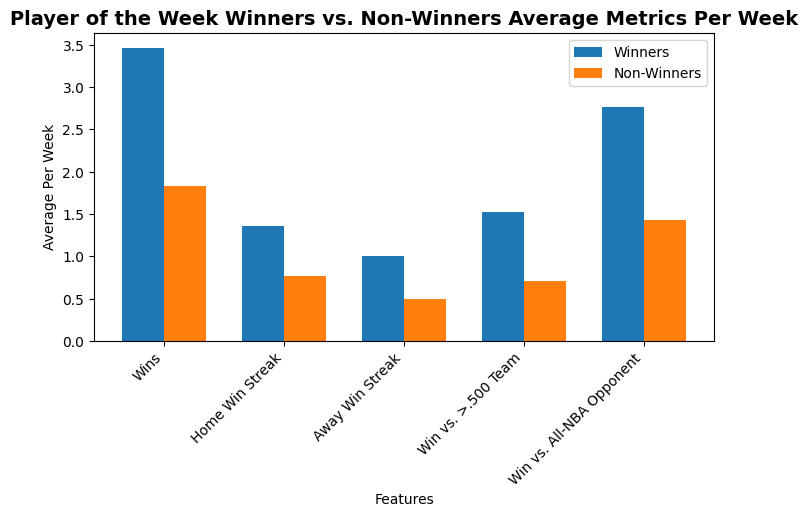

In [23]:
# Summary Visualization
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))

pow_bar = ax.bar(x - width/2, pow_res, width, label='Winners')
npow_bar = ax.bar(x + width/2, npow_res, width, label="Non-Winners")

ax.set_xlabel('Features')
ax.set_ylabel('Average Per Week')
ax.set_title("Player of the Week Winners vs. Non-Winners Average Metrics Per Week", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()

plt.show()

* We will now analyze player workload by examining minutes played per game from the 2024 season onward. We begin by extracting the raw data directly from the database using SQL, selecting each player's personid, the number of minutes they played (numminutes), and the corresponding gamedate. After loading the dataset into a Pandas DataFrame, we apply several data-cleaning steps consistent with best practices from class: converting string-based dates into proper datetime objects, removing timezone information to standardize the time series, and dropping incomplete or malformed entries.

* Once the dataset is cleaned, we convert the gamedate column into a datetime index, enabling efficient time-series operations. Using Pandas’ Grouper with weekly frequency, we engineer a new featureweekly average minutes—by aggregating each player’s minutes played across all games within a given week. This transformation helps smooth out single-game variability and provides a clearer view of player workload trends over time.

* We then perform exploratory data analysis (EDA) on the engineered feature. A distribution plot of weekly minutes gives insight into the overall spread of playing time across the league, helping identify typical workload ranges and potential outliers. Individual time series plots allow us to examine weekly workload trends for specific players, revealing patterns such as increased playing time, rest periods, or mid season fluctuations. Additionally, a league-wide average time-series plot highlights macro level pacing trends across the season.

In [24]:

# Minutes Played 

sql_stats = """
SELECT 
    player_id AS personid,
    numMinutes AS numminutes,
    gameDate AS gamedate
FROM player_statistics_df
WHERE gameDate >= '2024-01-01'
"""

stats = duckdb.query(sql_stats).df()
print("Loaded stats:", stats.shape)

stats['gamedate'] = pd.to_datetime(stats['gamedate'], errors='coerce', utc=True)
stats['gamedate'] = stats['gamedate'].dt.tz_localize(None)
stats = stats.dropna(subset=['gamedate'])

stats = stats.set_index('gamedate')

weekly_minutes = (
    stats
    .groupby(['personid', pd.Grouper(freq='W')])['numminutes']
    .mean()
    .reset_index()
    .rename(columns={'numminutes': 'weekly_minutes'})
)

print("Weekly minutes:", weekly_minutes.shape)
weekly_minutes.head()


Loaded stats: (70937, 3)
Weekly minutes: (25883, 3)


,personid,gamedate,weekly_minutes
0,2544,2024-01-07,38.00
1,2544,2024-01-14,29.50
2,2544,2024-01-21,33.75
3,2544,2024-01-28,41.00
4,2544,2024-02-04,37.00


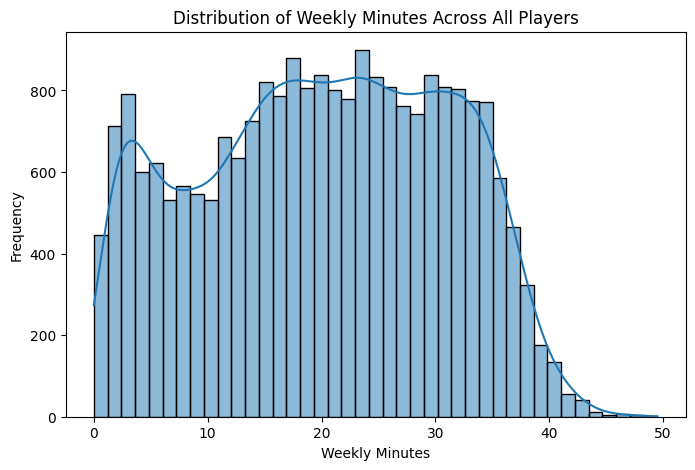

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(weekly_minutes['weekly_minutes'], kde=True)
plt.title("Distribution of Weekly Minutes Across All Players")
plt.xlabel("Weekly Minutes")
plt.ylabel("Frequency")
plt.show()


* Teams encounter opponents with All-NBA players at a meaningful rate, and the distribution of these matchups provides an important context for understanding team performance. By aggregating wins against All NBA opponents, we can see clear differences in how effectively teams compete against elite talent. Some teams maintain strong win rates even when facing top-tier players, suggesting greater consistency or roster depth, while others struggle significantly in these matchups.

* At the player level, examining who accumulates the most wins in these games may reveal athletes who contribute heavily in high-stakes situations or who play on teams that consistently outperform strong opponents. Team level summaries further highlight the competitive landscape, showing whether teams exceed or underperform relative to expectations when facing elite competition.

* This analysis uses class-aligned techniques including grouping, aggregation, categorical comparisons, bar plots, distribution analysis, and game-level outcome evaluation. Together, these EDA steps help contextualize team resilience, matchup difficulty, and performance patterns across the season—providing insight that can be used later for predictive modeling, writing, or presentation work.

In [26]:
# Wins Against Teams With All-NBA Players

first  = all_nba_first_team_df.copy()
second = all_nba_second_team_df.copy()
third  = all_nba_third_team_df.copy()
stats  = player_statistics_df.copy()
games  = games_df.copy()

stats = stats.rename(columns={"gameId": "game_id"})

STATS_THIS_SEASON = stats[
    stats["gameDate"].str.startswith("2024-") |
    stats["gameDate"].str.startswith("2025-")
].copy()

games_small = games_df[[
    "gameid",
    "hometeamname", "hometeamid",
    "awayteamname", "awayteamid",
    "winner"
]].rename(columns={"gameid": "game_id"})

STATS_THIS_SEASON = STATS_THIS_SEASON.merge(
    games_small,
    on="game_id",
    how="left"
)

# Opponent team logic
STATS_THIS_SEASON["opponentteamName"] = np.where(
    STATS_THIS_SEASON["playerteamName"] == STATS_THIS_SEASON["hometeamname"],
    STATS_THIS_SEASON["awayteamname"],
    STATS_THIS_SEASON["hometeamname"]
)

STATS_THIS_SEASON["winnerteamname"] = np.where(
    STATS_THIS_SEASON["winner"] == STATS_THIS_SEASON["hometeamid"],
    STATS_THIS_SEASON["hometeamname"],
    STATS_THIS_SEASON["awayteamname"]
)

STATS_THIS_SEASON["win"] = (
    STATS_THIS_SEASON["playerteamName"] == STATS_THIS_SEASON["winnerteamname"]
).astype(int)

all_nba = pd.concat([first, second, third], ignore_index=True)
all_nba_player_ids = set(all_nba["player_id"].unique())

rosters = (
    STATS_THIS_SEASON
    .groupby(["game_id", "playerteamName"])["player_id"]
    .apply(set)
    .reset_index()
    .rename(columns={"playerteamName": "team_name", "player_id": "roster"})
)

df = STATS_THIS_SEASON.merge(
    rosters.rename(columns={"team_name": "playerteamName",
                            "roster": "player_roster"}),
    on=["game_id", "playerteamName"],
    how="left"
)

df = df.merge(
    rosters.rename(columns={"team_name": "opponentteamName",
                            "roster": "opponent_roster"}),
    on=["game_id", "opponentteamName"],
    how="left"
)

def opponent_has_all_nba(roster):
    if isinstance(roster, set):
        return int(len(roster.intersection(all_nba_player_ids)) > 0)
    return 0

df["opponent_has_all_nba"] = df["opponent_roster"].apply(opponent_has_all_nba)

df["wins_vs_team_with_all_nba_player"] = (
    (df["win"] == 1) & (df["opponent_has_all_nba"] == 1)
).astype(int)

df["player_name"] = df["full_name"]

output = df[[
    "player_id", "player_name", "game_id",
    "playerteamName", "opponentteamName",
    "win", "opponent_has_all_nba",
    "wins_vs_team_with_all_nba_player"
]].sort_values("game_id")

display(output.head(40))


,player_id,player_name,game_id,playerteamName,opponentteamName,win,opponent_has_all_nba,wins_vs_team_with_all_nba_player
48863,204001,Kristaps Porzingis,12400001,Celtics,Nuggets,1,1,1
48839,1631128,Christian Braun,12400001,Nuggets,Celtics,0,1,0
48838,1631124,Julian Strawther,12400001,Nuggets,Celtics,0,1,0
48837,1631120,JD Davison,12400001,Celtics,Nuggets,1,1,1
48836,1630573,Sam Hauser,12400001,Celtics,Nuggets,1,1,1
48835,1630531,Jaden Springer,12400001,Celtics,Nuggets,1,1,1
48834,1630214,Xavier Tillman,12400001,Celtics,Nuggets,1,1,1
48833,1630202,Payton Pritchard,12400001,Celtics,Nuggets,1,1,1
48831,1629674,Neemias Queta,12400001,Celtics,Nuggets,1,1,1
48840,1631199,Ron Harper Jr.,12400001,Celtics,Nuggets,1,1,1


/var/folders/l7/4kz3974x4pd5w682h233sl8w0000gn/T/ipykernel_85459/3242354740.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


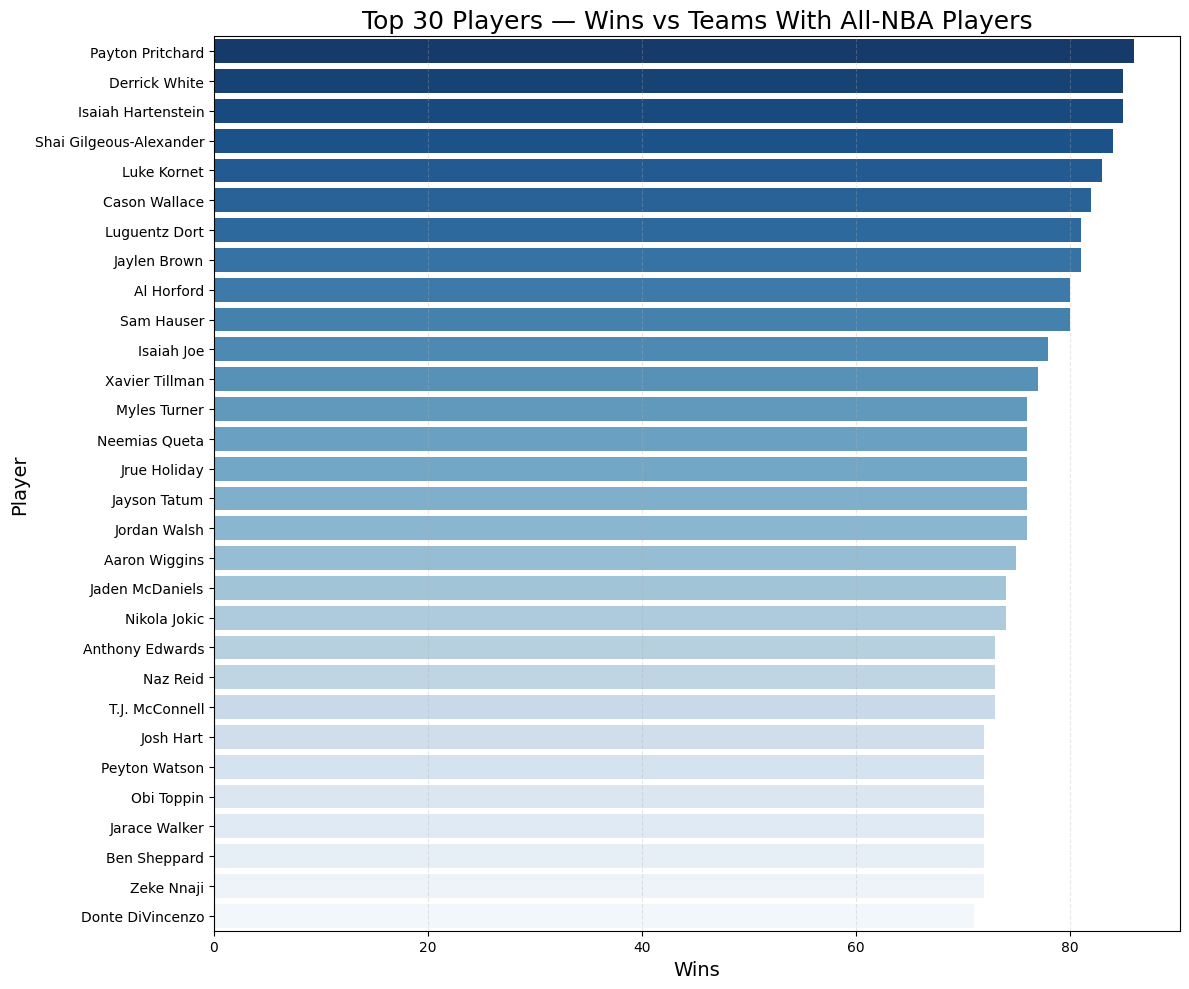

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

top30 = (
    output.groupby("player_name")["wins_vs_team_with_all_nba_player"]
    .sum()
    .sort_values(ascending=False)
    .head(30)
)

plt.figure(figsize=(12, 10))

sns.barplot(
    x=top30.values,
    y=top30.index,
    palette="Blues_r"
)

plt.title("Top 30 Players — Wins vs Teams With All-NBA Players", fontsize=18)
plt.xlabel("Wins", fontsize=14)
plt.ylabel("Player", fontsize=14)

plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


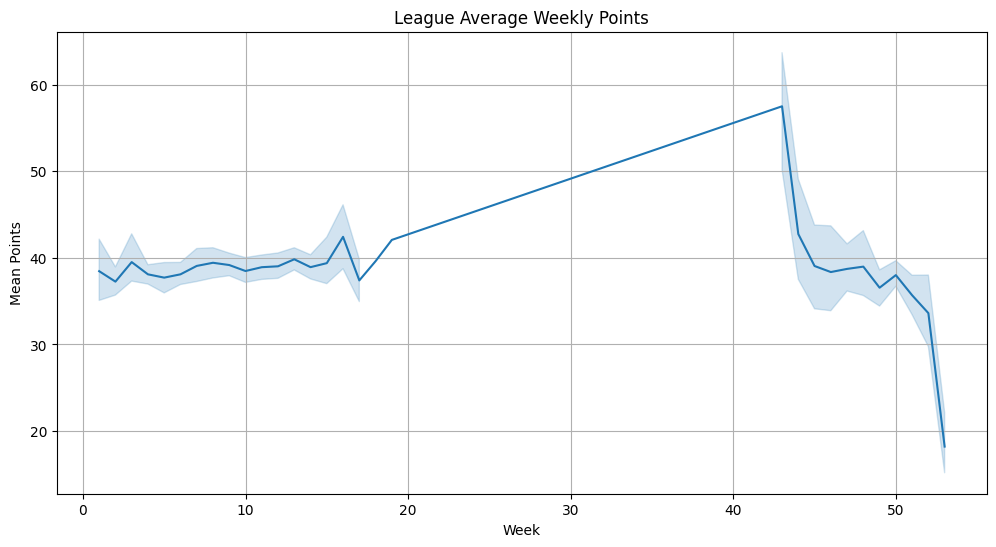

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("data/features-overall-weekly.csv", low_memory=False)
df.columns = df.columns.str.strip().str.lower()

df.head()

# League Average Weekly Points Over Time
plt.figure(figsize=(12, 6))
weekly_mean = (
    df.groupby(["season", "week"])["points"]
      .mean()
      .reset_index()
)

sns.lineplot(data=weekly_mean, x="week", y="points")
plt.title("League Average Weekly Points")
plt.xlabel("Week")
plt.ylabel("Mean Points")
plt.grid(True)
plt.show()

The weekly league average points remain relatively stable through most of the regular season, with minor fluctuations between Weeks 1–20 and a gradual increase toward mid-season. The sharp drop after Week 50 occurs because the regular season ends and no games are played from April to October, which creates an artificial gap with no recorded data. Since this seasonal gap strongly affects the shape of the curve, the visualization provides limited insight for our predictive task.

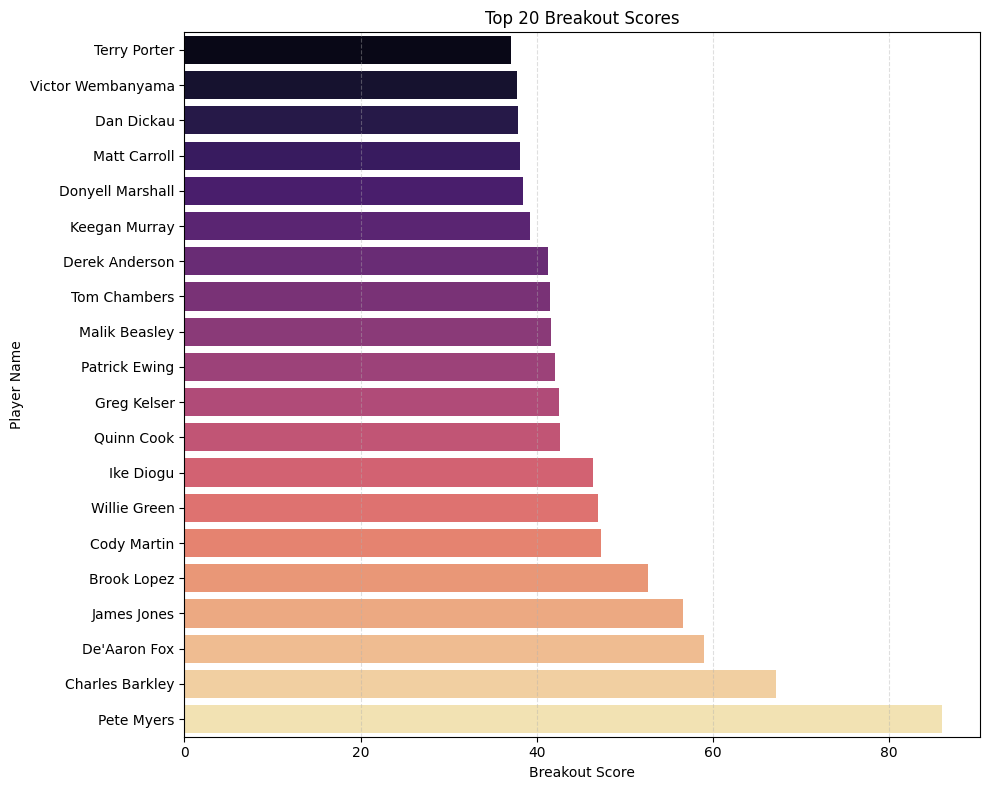

In [7]:
# Top 20 Breakout Scores Overall
top_breakout = df.nlargest(20, "breakout_score")

top_breakout = top_breakout.sort_values("breakout_score", ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_breakout,
    x="breakout_score",
    y="full_name",
    palette="magma"
)
plt.title("Top 20 Breakout Scores")
plt.xlabel("Breakout Score")
plt.ylabel("Player Name")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

The breakout score highlights players who significantly exceeded their typical weekly performance relative to the league. The top players on this chart include both established stars and unexpected contributors, showing that the breakout metric captures surprising single-week surges rather than overall season strength. Since it reflects isolated peaks rather than consistent performance, it contributes limited value to our final prediction task.

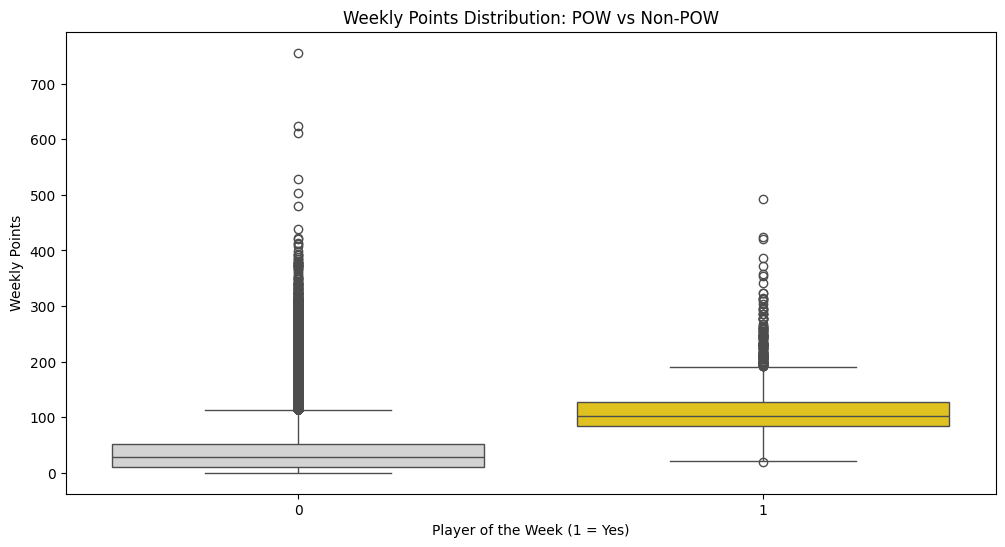

In [8]:
# Boxplot of Points for POW vs Non-POW
pow_col = "won_player_of_the_week"

df[pow_col] = df[pow_col].astype(str)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x=pow_col,
    y="points",
    palette={"0": "lightgray", "1": "gold"}
)
plt.title("Weekly Points Distribution: POW vs Non-POW")
plt.xlabel("Player of the Week (1 = Yes)")
plt.ylabel("Weekly Points")
plt.show()

Weekly points show a clear separation between PoW and non-PoW players. PoW recipients have much higher median and upper-range scoring outputs, confirming that weekly scoring is one of the strongest distinguishing features for predicting Player of the Week.

# Prediction Models

Now that we have explored our data, showcasing we have engineered good features that could provide good predictor value in predicting Player of the Week, we will now move on to creating our prediction models.

# Part 3: Logistic Regression Model


We include Logistic Regression as a linear baseline model to compare against the tree-based models and the neural network. 
Since the Player-of-the-Week prediction is a highly imbalanced classification problem, we applied class_weight="balanced" 
and reduced dimensionality using PCA to avoid overfitting on the 89 engineered features.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

# Load dataset
df = pd.read_csv("data/features-overall-weekly.csv")

# Select features
X = df.drop(columns=[
    'full_name', 'player_id', 'pow_player_id', 'player_of_the_week',
    'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
    'all_nba_first_team_this_season', 'all_nba_second_team_this_season',
    'all_nba_third_team_this_season', 'week_start', 'pow_conference',
    'is_win_vs_over_500', 'opponent_has_all_nba'
])

# Target
y = df['won_player_of_the_week']

# One-hot encoding for team + conference
X = pd.get_dummies(X, columns=['team', 'conference'], drop_first=False).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca_model = PCA(n_components=38, random_state=42)
X_train_pca = pca_model.fit_transform(X_train_scaled)
X_test_pca = pca_model.transform(X_test_scaled)

# Train logistic regression model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
log_reg.fit(X_train_pca, y_train)

# Evaluate on the test set
y_pred = log_reg.predict(X_test_pca)
y_proba = log_reg.predict_proba(X_test_pca)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     46395
           1       0.06      0.93      0.11       278

    accuracy                           0.91     46673
   macro avg       0.53      0.92      0.53     46673
weighted avg       0.99      0.91      0.95     46673

Test ROC AUC: 0.9639222472652333


Inference Summary：

We trained a logistic regression model using PCA-reduced features (38 components explaining ~80% variance).
Because the dataset is extremely imbalanced, we used class_weight="balanced" to reduce bias toward the majority class.
Overall, the model achieved:
    Accuracy ≈ 0.91
    ROC AUC ≈ 0.964
    Recall for class 1 is high (0.93), but precision is low (0.06)
This indicates that logistic regression captures the separation between PoW winners and non-winners reasonably well in terms of ranking (AUC),
but it struggles to precisely identify true winners due to class imbalance and model simplicity.

###############################

Hyperparameter Tuning

A simple hyperparameter tuning process was performed using GridSearchCV to ensure that the logistic regression model was properly regularized and suitable for an imbalanced dataset. The search focused on a few key parameters, including the regularization strength (C), the choice of penalty (L1 or L2), the solver, and whether class_weight was set to balanced.
The tuning process used 5-fold cross-validation and consistently showed that models with L2 regularization and moderate C values around 0.1 to 1 provided the most stable results. Using class_weight="balanced" improved recall for the positive class but did not significantly improve precision, which is expected due to the extreme class imbalance.
Overall, the tuning confirmed that a moderately regularized logistic regression model is appropriate for this task, but it also highlights that logistic regression has limited ability to precisely identify true Player-of-the-Week winners because the decision boundary is difficult to separate linearly.

# Part 4: Light Gradient Boosting Machine (GBM) Model

For this model and the following neural network model, we are going to group our data to help boost accuracy due to class imbalance (explanation below).

In [98]:
# Imports
import lightgbm as lgb
from scipy.stats import gaussian_kde
import optuna
import requests
from io import StringIO
import pickle

RS = 42 # random seed

# Data Preparation

In [99]:
# Function to pull data from google cloud
def get_csv_df(csv_name):
    url = f"https://storage.googleapis.com/nba_award_predictor/nba_data/{csv_name}"

    r = requests.get(url)
    r.raise_for_status()

    csv_text = r.content.decode('utf-8')
    df = pd.read_csv(StringIO(csv_text))
    return df

In [100]:
# Pull csv file with all features from cloud database
df = get_csv_df("features-overall-weekly.csv")

In [101]:
# To conduct week by week inference, we will train our model pre-2025-26 season and inference on our 2025-26 weeks
total_pre = df[df['season'] != 2025]
total_inf = df[df['season'] == 2025] # our inference set

Since up to the 2000-01 season, player of the week award was given league wide, not per conference, we will drop data to only include data where awards were given per conference. While the data being dropped could provide insight, we want our model to trained to fit modern standard. 

In [102]:
# Dropping rows where season is before 2001-02 season
total_pre = total_pre[total_pre['season'] > 2000]

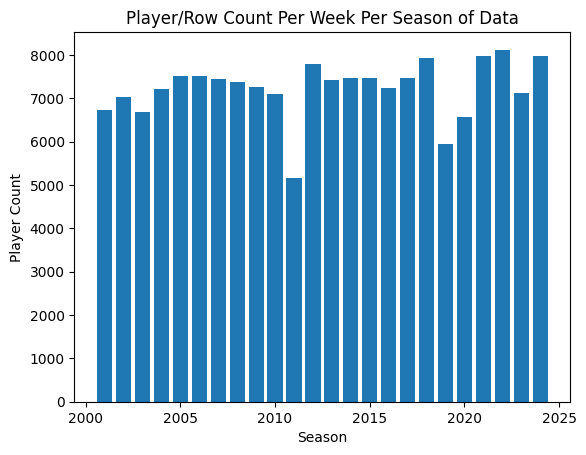

In [103]:
# Visualize season count
season_count = total_pre.groupby('season')['team'].count() # Since we are doing count, we can use arbitrary counter column ('team')
plt.bar(season_count.index, season_count.values)
plt.xlabel("Season")
plt.ylabel("Player Count")
plt.title("Player/Row Count Per Week Per Season of Data")
plt.show()

In [36]:
# Target/y label, 1 if player is winner, 0 otherwise
y = total_pre['won_player_of_the_week']

# full_name, player_id: not features
# pow_player_id, player_of_the_week, won_player_of_week: target labels (y data)
# all_star_this_season, mvp_this_season, all_nba_first_team_this_season, all_nba_second_team_this_season, all_nba_third_team_this_season: "future data", not determined until end of the season
# week_start, pow_conference: redundant, we have season, week, conference
# is_win_vs_over_500, opponent_has_all_nba: these were encoders for game entries, our rows are week entries

X = total_pre.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba'])

In [37]:
# Double check for null values
X.isnull().sum()

team                      0
season                    0
week                      0
conference                0
games_played_this_week    0
                         ..
league_pm_mean            0
league_pm_std             0
z_s_pts                   0
z_s_ast                   0
z_s_pm                    0
Length: 65, dtype: int64

Our X features contain non-numerical data: 'team' and 'conference'. We do not need to hot encode these categorical features whening using tree-based models. Instead, we cast as category type and indicate our categorical data in the hyper parameters

In [38]:
# Do not need to hot encode category features for tree-based models, instead cast as category type
cat_cols = ['team', 'conference']
for c in cat_cols:
    X[c] = X[c].astype("category")

In [39]:
# Review data types
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173475 entries, 59525 to 232999
Data columns (total 65 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   team                              173475 non-null  category
 1   season                            173475 non-null  int64   
 2   week                              173475 non-null  int64   
 3   conference                        173475 non-null  category
 4   games_played_this_week            173475 non-null  int64   
 5   numMinutes                        173475 non-null  float64 
 6   points                            173475 non-null  float64 
 7   assists                           173475 non-null  float64 
 8   blocks                            173475 non-null  float64 
 9   steals                            173475 non-null  float64 
 10  reboundsTotal                     173475 non-null  float64 
 11  reboundsDefensive                 173475

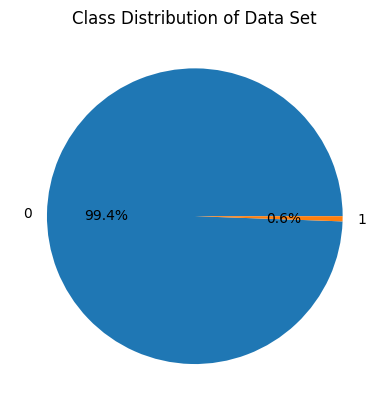

In [40]:
# Visual label/class distribution
tot_y = y.value_counts()
plt.pie(tot_y.values, labels=tot_y.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Data Set")
plt.show()

As we can see, there is extreme imbalance for our prediction label (1 for player won player of the week award for that week, 0 otherwise). This is natural given that player of the week is highly selective, only two (one per conference) are given per week. Given this imbalance, we are highly at risk of our model predicting 0 for all future players. We will take measures to correct this balance as much as possible.

## 1. Time-based Split

By splitting our data by time, test set = data from 2024-25 season and train set = data pre 2024-25 season, we ensure that all players from a given week are grouped together. This will ensure the integrity of our model as we will be inferencing our model on week by week data. It will also prevent any data leakage where future data is trained to test past data. Lastly, it also maintains the same class distribution as the original data set as each group week remains in tact, where each group has an associated player of the week winner.

In [41]:
# Splitting our data into train and test sets
train_mask = X['season'] < 2024
X_train, y_train = X[train_mask], y[train_mask] #it is safe to apply the mask to 'y' as we have not altered 'y' ordering

test_mask = X['season'] == 2024
X_test, y_test = X[test_mask], y[test_mask]

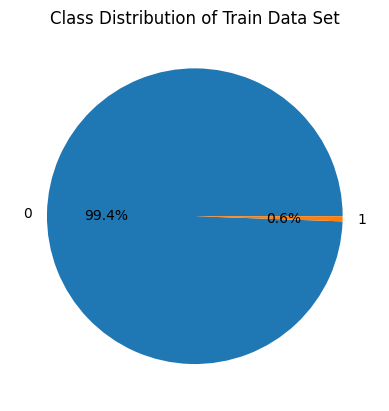

In [42]:
# Plot our split data label distribution
tot_y = y_train.value_counts()
plt.pie(tot_y.values, labels=tot_y.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Train Data Set")
plt.show()

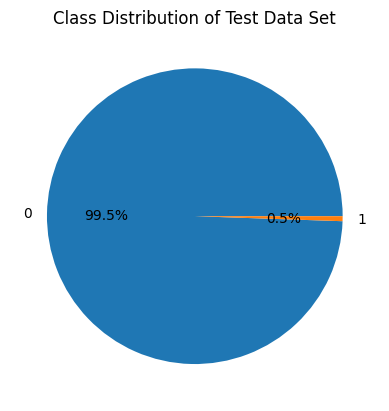

In [43]:
tot_y = y_test.value_counts()
plt.pie(tot_y.values, labels=tot_y.index.values, autopct='%1.1f%%')
plt.title("Class Distribution of Test Data Set")
plt.show()

## 2. Utilize Scale Positive Weight

We will use scale_pos_weight for our Light GBM model. Using this ratio, we will force our model to pay way more attention to our positive/1-label data rows. This will help address our class imbalance.

In [44]:
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos
scale_pos_weight = num_neg / num_pos
print(f"Imbalance ratio: {scale_pos_weight}")

Imbalance ratio: 177.3448275862069


## 3. Adjust Initialize Hyper Parameters

Since we have small signal, we need more boosting rounds to handle the class imbalance. We will set learning rate low and number of estimators high.

In [45]:
# Initial Parameters

params = {
    "objective" :"binary", # classification: winner vs. non-winner, optimize log loss
    "n_estimators" :2000, # maximum number of boosting rounds i.e. number of trees to build
    "learning_rate":0.01, # how much each tree contributes to final prediction (shrinking rate)
    "scale_pos_weight":scale_pos_weight, # handles our imbalance
    'metric': ['binary_logloss', 'auc'], # log loss: penalizes wrong predictions heavily. AUC: measures ranking quality
    'boosting_type': 'gbdt',
    "max_depth":-1, # maximum depth of each tree. -1 = no limit
    "num_leaves":31, # maximum number of leaves per tree
    'feature_fraction': 0.8, # randomly selects 80% of features per tree
    'bagging_fraction': 0.8, # randomly samples 80% of data per tree
    'bagging_freq': 5, # frequency of bagging. Every 5 iterations bag
    'min_child_samples': 20, # minimum number of samples in a leaf node
    "random_state":RS,
    "n_jobs":-1, # uses maximum number of CPU cores available
    "verbose": -1
}

# Model Selection

We will begin to test which Light GBM model is best for predicting winners. We will be using cross validation to prevent overfitting results swaying our decision. Since our data is temporal, we will be doing a time series cross-validation using seasons. This will prevent future data being trained to predict the past. It always prevent player performances from a given week being split between the train and validation sets.

- Validation sets: 2018-19, 2019-20, 2020-21, 2022-23, 2024-25 seasons
- Training sets: seasons before validation set season

We will examine our model performance by looking at the top-k results. For each season, week, conference in our data set, we will focus on if our model predicted a higher probability for the correct winner within the top 1, 3, 5, 10 highest probabilities for that week. This will help us address accuracy when dealing with imbalance classes. However, with this given set up, we cannot examine precision and recall as we do not enforce a threshold for classifying our model's prediction as a winner or non-winner.

In [49]:
# Perform cross validation on all of X
folds = 5
k = [1, 3, 5, 10]
unique_seasons = sorted(X['season'].unique())

cv_results = []

# Iterate through each fold, using fold number as key for validation season
for fold in range(1, folds + 1):
    val_season = unique_seasons[-fold]
    train_seasons = unique_seasons[:-fold]
    
    val_mask = X['season'] == val_season
    train_mask = X['season'].isin(train_seasons)

    X_val, y_val = X[val_mask], y[val_mask] # Applying mask to 'y' is safe
    X_train, y_train = X[train_mask], y[train_mask]

    print(f"Validation {fold}")
    print(f"Val. Season: {val_season}")
    print(f"Train Seasons: {train_seasons[0]}-{train_seasons[-1]}")
    print(f"Val. Proportion: {len(y_val) / (len(y_val) + len(X_train))}\n")

    model = lgb.LGBMClassifier(**params) # Uses params defined above

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)], # stops splitting if no more gain possible
        categorical_feature=cat_cols, # cat_cols = team, conference
    )

    pred = model.predict_proba(X_val)[:, 1]

    # Predicting if top-k probabilites is a "hit" i.e. 1-label
    df = X_val[['season', 'week', 'conference']].copy()
    df['y_true'] = y_val
    df['y_proba'] = pred

    # Stores k-accuracy
    k_dict = {i: [] for i in k}
    
    # Group data rows by season, week, conference as there is associated winner for each group
    groups = df.groupby(['season', 'week', 'conference'], observed=True)
    ranks = []
    for _, group in groups:
        group_sorted = group.sort_values('y_proba', ascending=False).reset_index(drop=True) # boolean mask for indexes of true winner rows
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1] # sort based on boolean mask
        for i in k:
            top_k = group_sorted.head(i) # Look at top 'k' probabilities
            hit = top_k['y_true'].max() # Returns 1 if winner is in top 'k', else 0
            k_dict[i].append(hit)
        for idx in pos_idx:
            ranks.append(idx + 1) # shift 0 to 1 index
    ranks = np.array(ranks)
    curr = {"Fold": fold, "Max_Prob": pred.max(), "Min_Prob": pred.min(),
            "Num_winners_seen": len(ranks), "Top_rank": ranks.min(), "Lowest_rank": ranks.max(), 
            "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])
    }
    for i, hits in k_dict.items():
        curr[f"Top_{i}_avg_hits"] = np.mean(hits)
    cv_results.append(curr)

Validation 1
Val. Season: 2024
Train Seasons: 2001-2023
Val. Proportion: 0.04594898400345871

Validation 2
Val. Season: 2023
Train Seasons: 2001-2022
Val. Proportion: 0.04295364462490332

Validation 3
Val. Season: 2022
Train Seasons: 2001-2021
Val. Proportion: 0.051251617790965626

Validation 4
Val. Season: 2021
Train Seasons: 2001-2020
Val. Proportion: 0.05308197528563919

Validation 5
Val. Season: 2020
Train Seasons: 2001-2019
Val. Proportion: 0.04621222768798314



In [50]:
# Cross fold validation results
top_k_df = pd.DataFrame(cv_results)
top_k_df

,Fold,Max_Prob,Min_Prob,Num_winners_seen,Top_rank,Lowest_rank,Percentiles,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits
0,1,0.185352,0.005062,43,1,20,"[1.0, 1.0, 2.0, 5.0, 7.800000000000004]",0.452381,0.642857,0.785714,0.928571
1,2,0.108130,0.005239,37,1,16,"[1.0, 2.0, 4.0, 6.0, 10.599999999999994]",0.210526,0.447368,0.605263,0.842105
2,3,0.183708,0.005200,43,1,21,"[1.0, 1.0, 3.0, 5.0, 8.800000000000004]",0.318182,0.613636,0.772727,0.931818
3,4,0.173967,0.005119,41,1,13,"[1.0, 1.0, 2.0, 4.0, 8.0]",0.409091,0.681818,0.750000,0.840909
4,5,0.135390,0.005195,34,1,14,"[1.0, 2.0, 3.0, 5.75, 10.7]",0.166667,0.583333,0.694444,0.833333


In [51]:
print(f"Across folds:\nAverage Top-1 Hits: {top_k_df['Top_1_avg_hits'].mean()}\nAverage Top-3 Hits: {top_k_df['Top_3_avg_hits'].mean()}\nAverage Top-5 Hits: {top_k_df['Top_5_avg_hits'].mean()}\nAverage Top-10 Hits: {top_k_df['Top_10_avg_hits'].mean()}")

Across folds:
Average Top-1 Hits: 0.311369332421964
Average Top-3 Hits: 0.5938026885395307
Average Top-5 Hits: 0.721629832156148
Average Top-10 Hits: 0.8753474595579858


Our results show mediocre accuracy. Across the folds, our model predicts the winner as its top rank around 31% of time and correctly ranks the winner within the top 10 ranks ~87% of the time. We see that our model has ranked a winner as low as 21th. We also want to note that when validating on the second fold, the 2023-24 season, our model performed worse compared to the other folds. This showcases that season-wide changes could affect our model's performance. Lastly, we see that our maximum probability is low when predicting the player of week. However, when comparing it to our lowest probability of a player, there is a significant difference between the probabilites. 

# Changing Our Approach

Since we want to predict on a week by week basis and our winner(s) come from each conference (post 2000-01 season), lets define our groups as per 'season' + 'week' + 'conference' and change our Light GBM objective to "lambdarank" which ranks our probabilites based on the associated groups as 'scores' (probabilites -> real numbers). We do this because winners are distributed on weekly basis. If we trained our model without grouping, our data isn't independently identically distributed as winners are being compared to all other historical performances. While our winners are based on their performance compared to historical performances, it is also heavily based on the performances of other players for that given week in their conference. By changing this set up, our model set up will match how we have been testing accuracy: top-k for each week in our data.

In [58]:
# Group keys
X['key'] = X['season'].astype(str) + '_' + X['week'].astype(str) + '_' + X['conference'].astype(str)
unique_keys = X['key'].unique()

X.head(5)['key']

59525    2001_1_West
59526    2001_1_West
59527    2001_1_East
59528    2001_1_East
59529    2001_1_East
Name: key, dtype: object

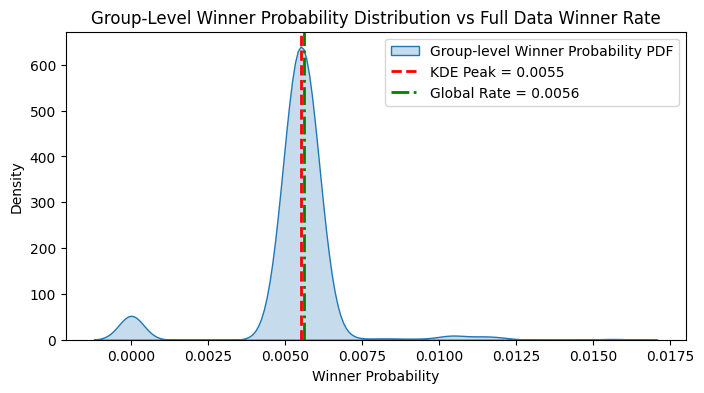

In [59]:
# Graph kernel density estimate of weekly group winners
df_group = pd.DataFrame({
    "key": X["key"],
    "y": y  
})

counts = (
    df_group
    .groupby("key")["y"]
    .value_counts()
    .unstack(fill_value=0)
    .sort_index()
)
prob = counts[1] / (counts[0] + counts[1])

global_rate = y.mean()   # overall % of winners in full dataset

kde = gaussian_kde(prob)
xs = np.linspace(prob.min(), prob.max(), 500)
ys = kde(xs)
x_peak = xs[np.argmax(ys)]  # where density is highest

plt.figure(figsize=(8,4))

# KDE plot
sns.kdeplot(prob, fill=True, label="Group-level Winner Probability PDF")

# Vertical line: KDE peak
plt.axvline(x_peak, color="red", linestyle="--", linewidth=2, 
            label=f"KDE Peak = {x_peak:.4f}")

# Vertical line: Global winner average
plt.axvline(global_rate, color="green", linestyle="-.", linewidth=2, 
            label=f"Global Rate = {global_rate:.4f}")

plt.title("Group-Level Winner Probability Distribution vs Full Data Winner Rate")
plt.xlabel("Winner Probability")
plt.ylabel("Density")
plt.legend()

plt.show()


As we can see here, the kde of winner probabilty per group across our data set is very low. This is expected as there is only 1 winner per group. What changes per group is the number of total players in each group. Furthermore, we can see that our "global" rate (i.e. in our full data set) is approximately the same as our kde peak. This follows suit as the probability per winner per group should be approxiamtely the same as the distribution of winners in our full data set. This finding matches our pie chart above: ~0.6%.

In [60]:
rank_params = {
            'objective': 'lambdarank',
            'metric': 'ndcg',  # Normalized Discounted Cumulative Gain
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'min_child_samples': 20,
            'verbose': -1,
            'random_state': RS,
            'n_jobs': -1,
        } # lambdarank does not utilize scale_pos_weight because it optimizes within groups

In [61]:
# Perform cross validation on all of X
folds = 5
k = [1, 3, 5, 10]
unique_seasons = sorted(X['season'].unique())

cv_results = []

# Iterate through each fold, using fold number as key for validation season
for fold in range(1, folds + 1):
    val_season = unique_seasons[-fold]
    train_seasons = unique_seasons[:-fold]
    
    val_mask = X['season'] == val_season
    train_mask = X['season'].isin(train_seasons)

    X_val, y_val = X[val_mask], y[val_mask] # Applying mask to 'y' is safe
    X_train, y_train = X[train_mask], y[train_mask]

    # Obtain group sizes/starting index by group key
    X_train = X_train.sort_values(by='key')
    y_train = y_train.loc[X_train.index]

    X_val = X_val.sort_values(by='key')
    y_val = y_val.loc[X_val.index]

    tr_group_sizes = X_train.groupby('key').size().to_numpy()
    val_group_sizes = X_val.groupby('key').size().to_numpy()

    # Drop key feature before training and validation
    X_train = X_train.drop(columns=['key'])
    X_val = X_val.drop(columns=['key'])

    print(f"Validation {fold}")
    print(f"Val. Season: {val_season}")
    print(f"Train Seasons: {train_seasons[0]}-{train_seasons[-1]}")
    print(f"Val. Proportion: {len(y_val) / (len(y_val) + len(X_train))}\n")

    model = lgb.LGBMRanker(**rank_params) # Uses params defined above

    model.fit(
        X_train,
        y_train,
        group=tr_group_sizes, # groups based on sizing key
        eval_set=[(X_val, y_val)],
        eval_group=[val_group_sizes], # groups based on sizing key
        eval_at=[1, 3, 5, 10],  # Evaluate NDCG at these positions
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)], # stops splitting if no more gain possible
        categorical_feature=cat_cols, # cat_cols = team, conference
    )

    pred = model.predict(X_val)

    # Predicting if top-k probabilites is a "hit" i.e. 1-label
    df = X_val[['season', 'week', 'conference']].copy()#.reset_index(drop=True)
    df['y_true'] = y_val#.reset_index(drop=True)
    df['score'] = pred

    # Stores k-accuracy
    k_dict = {i: [] for i in k}
    
    # Group data rows by season, week, conference as there is associated winner for each group
    groups = df.groupby(['season', 'week', 'conference'], observed=True)
    ranks = []
    for _, group in groups:
        group_sorted = group.sort_values('score', ascending=False).reset_index(drop=True) # boolean mask for indexes of true winner rows
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1] # sort based on boolean mask
        for i in k:
            top_k = group_sorted.head(i) # Look at top 'k' probabilities
            hit = top_k['y_true'].max() # Returns 1 if winner is in top 'k', else 0
            k_dict[i].append(hit)
        for idx in pos_idx:
            ranks.append(idx + 1) # shift 0 to 1 index
    ranks = np.array(ranks)
    curr = {"Fold": fold, "Top_rank": ranks.min(), "Lowest_rank": ranks.max(), 
            "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])
    }
    for i, hits in k_dict.items():
        curr[f"Top_{i}_avg_hits"] = np.mean(hits)
    cv_results.append(curr)

#X=X.drop(columns=['key'])

Validation 1
Val. Season: 2024
Train Seasons: 2001-2023
Val. Proportion: 0.04594898400345871

Validation 2
Val. Season: 2023
Train Seasons: 2001-2022
Val. Proportion: 0.04295364462490332

Validation 3
Val. Season: 2022
Train Seasons: 2001-2021
Val. Proportion: 0.051251617790965626

Validation 4
Val. Season: 2021
Train Seasons: 2001-2020
Val. Proportion: 0.05308197528563919

Validation 5
Val. Season: 2020
Train Seasons: 2001-2019
Val. Proportion: 0.04621222768798314



In [62]:
rank_k_df = pd.DataFrame(cv_results)
rank_k_df

,Fold,Top_rank,Lowest_rank,Percentiles,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits
0,1,1,32,"[1.0, 1.0, 1.0, 3.0, 6.0]",0.547619,0.833333,0.857143,0.952381
1,2,1,9,"[1.0, 1.0, 2.0, 4.0, 6.399999999999999]",0.447368,0.684211,0.789474,0.921053
2,3,1,15,"[1.0, 1.0, 1.0, 3.0, 6.0]",0.522727,0.772727,0.840909,0.954545
3,4,1,6,"[1.0, 1.0, 1.0, 2.0, 4.0]",0.568182,0.818182,0.909091,0.931818
4,5,1,7,"[1.0, 1.0, 1.0, 3.0, 4.0]",0.583333,0.750000,0.916667,0.944444


In [63]:
print(f"Across folds:\nAverage Top-1 Hits: {rank_k_df['Top_1_avg_hits'].mean()}\nAverage Top-3 Hits: {rank_k_df['Top_3_avg_hits'].mean()}\nAverage Top-5 Hits: {rank_k_df['Top_5_avg_hits'].mean()}\nAverage Top-10 Hits: {rank_k_df['Top_10_avg_hits'].mean()}")

Across folds:
Average Top-1 Hits: 0.5338459785828207
Average Top-3 Hits: 0.7716905901116429
Average Top-5 Hits: 0.86265664160401
Average Top-10 Hits: 0.9408483329535962


By switching our objective to 'lambdarank', our model ranks per group (season, week, conference). By doing this, our model is not vunerable to our class imbalance because each group has a winner and our model's objective is to rank our winner above all non-winners. We see a great improvement in our average top-1 accuracy across folds: ~53%. This is a huge jump from our previous model. Furthermore, we see our model reaches up to ~94% accuracy across folds when ranking our winner in top 10 ranks. In our percentiles, we see that for at least 75% of our predictions per group, we ranked our winner within the top 3 spots across ranks. This matches our top-3 accuracy results. 

Despite the improvement in accuracy from our revised prediction approach, we observe a drop in the lowest rank, which now reaches 32. One possible explanation is that the model now evaluates players only within each week’s candidate pool. This narrower comparison set may magnify the impact of atypical winners who perform far outside their usual baseline, making the model’s mistakes on these outliers more visible. 

As we continue refining the model, our goal is to improve overall accuracy while reducing sensitivity to such outlier cases so that extreme performances do not disproportionately degrade ranking quality.

# Hyper Parameter Tuning

 We will use optuna for its flexibility and reward based tuning system to find our best combination of hyper parameters. We will use our top-1 accuracy as our metric for tuning our model. This is because if top-1 accuracy improves, (generally) so will top-k accuracy for all k > 1. Optuna will iterate through 50 trials, keeping track of the hyper parameters that achieved the best top-1 accuracy from the trials.

In [64]:
# Optuna objective
def objective(trial):
    
    # parameters to test given range of values per trial
    params = {
        "objective": "lambdarank",
        "metric": "ndcg",
        "n_estimators": 3000,  # Max trees to build; early stopping will stop before if no improvement
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),  # Min sum of weights in a leaf; helps prevent overfitting on small groups
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10.0, log=True),  # L1 regularization; encourages sparse features (some weights = 0)
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10.0, log=True),  # L2 regularization; penalizes large weights (smoother predictions)
        "random_state": RS,
        "n_jobs": -1,
        "verbose": -1,
    }
    
    unique_seasons = sorted(X['season'].unique())
    folds = 5
    fold_results = []
    
    # Time-based CV: iterate through each fold
    for fold in range(1, folds + 1):
        val_season = unique_seasons[-fold]
        train_seasons = unique_seasons[:-fold]
        
        val_mask = X['season'] == val_season
        train_mask = X['season'].isin(train_seasons)
        
        X_tr, y_tr = X[train_mask].copy(), y[train_mask].copy()
        X_val, y_val = X[val_mask].copy(), y[val_mask].copy()
        
        # Sort by key for grouping
        X_tr = X_tr.sort_values(by='key')
        y_tr = y_tr.loc[X_tr.index]
        
        X_val = X_val.sort_values(by='key')
        y_val = y_val.loc[X_val.index]
        
        # Obtain group sizes
        tr_group_sizes = X_tr.groupby('key').size().to_numpy()
        val_group_sizes = X_val.groupby('key').size().to_numpy()
        
        model = lgb.LGBMRanker(**params)
        
        model.fit(
            X_tr.drop(columns=['key']),
            y_tr,
            group=tr_group_sizes,
            eval_set=[(X_val.drop(columns=['key']), y_val)],
            eval_group=[val_group_sizes],
            eval_at=[1, 3, 5, 10],
            categorical_feature=cat_cols,
            callbacks=[lgb.early_stopping(100, verbose=False)],
        )
        
        y_val_score = model.predict(X_val.drop(columns=['key']))
        
        df_val = X_val[["season", "week", "conference"]].copy()
        df_val["y_true"] = y_val.values
        df_val["score"] = y_val_score
        
        hits_1st = []
        for _, group in df_val.groupby(['season', 'week', 'conference'], observed=True):
            group_sorted = group.sort_values(by='score', ascending=False)
            hit = group_sorted.head(1)['y_true'].max()
            hits_1st.append(hit)
        
        if len(hits_1st) != 0:
            fold_results.append(np.mean(hits_1st))
    
    if len(fold_results) == 0:
        return 0.0
    return np.mean(fold_results)

In [65]:
# Complete a study. Optuna will iterate through trials, updating hyperparameters based on previous trial results
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=2),
    sampler=optuna.samplers.TPESampler(seed=RS)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-06 00:11:33,612] A new study created in memory with name: no-name-ad5ab827-04fb-4698-a68e-915f3ba50081
Best trial: 0. Best value: 0.54048:   2%|▏         | 1/50 [00:13<10:58, 13.43s/it]

[I 2025-12-06 00:11:47,075] Trial 0 finished with value: 0.5404799878484089 and parameters: {'learning_rate': 0.03621780831931538, 'num_leaves': 123, 'min_child_samples': 149, 'min_child_weight': 0.24810409748678114, 'feature_fraction': 0.5780093202212182, 'bagging_fraction': 0.5779972601681014, 'bagging_freq': 1, 'lambda_l1': 2.915443189153755, 'lambda_l2': 0.25378155082656645}. Best is trial 0 with value: 0.5404799878484089.


Best trial: 1. Best value: 0.541046:   4%|▍         | 2/50 [00:22<08:53, 11.11s/it]

[I 2025-12-06 00:11:56,552] Trial 1 finished with value: 0.5410457963089542 and parameters: {'learning_rate': 0.05956508044572319, 'num_leaves': 32, 'min_child_samples': 195, 'min_child_weight': 2.136832907235876, 'feature_fraction': 0.6061695553391381, 'bagging_fraction': 0.5909124836035503, 'bagging_freq': 2, 'lambda_l1': 0.016480446427978974, 'lambda_l2': 0.12561043700013563}. Best is trial 1 with value: 0.5410457963089542.


Best trial: 1. Best value: 0.541046:   6%|▌         | 3/50 [00:36<09:36, 12.26s/it]

[I 2025-12-06 00:12:10,183] Trial 2 finished with value: 0.5303865724918356 and parameters: {'learning_rate': 0.040236151304948106, 'num_leaves': 59, 'min_child_samples': 126, 'min_child_weight': 0.003613894271216527, 'feature_fraction': 0.6460723242676091, 'bagging_fraction': 0.6831809216468459, 'bagging_freq': 5, 'lambda_l1': 1.3826232179369866, 'lambda_l2': 0.006290644294586149}. Best is trial 1 with value: 0.5410457963089542.


Best trial: 1. Best value: 0.541046:   8%|▊         | 4/50 [00:52<10:38, 13.88s/it]

[I 2025-12-06 00:12:26,538] Trial 3 finished with value: 0.5313890787574997 and parameters: {'learning_rate': 0.04599641068895281, 'num_leaves': 88, 'min_child_samples': 18, 'min_child_weight': 0.26926469100861794, 'feature_fraction': 0.5852620618436457, 'bagging_fraction': 0.5325257964926398, 'bagging_freq': 10, 'lambda_l1': 7.286653737491043, 'lambda_l2': 1.7123375973163983}. Best is trial 1 with value: 0.5410457963089542.


Best trial: 1. Best value: 0.541046:  10%|█         | 5/50 [01:03<09:26, 12.59s/it]

[I 2025-12-06 00:12:36,854] Trial 4 finished with value: 0.5105453026505657 and parameters: {'learning_rate': 0.031322963842135954, 'num_leaves': 40, 'min_child_samples': 140, 'min_child_weight': 0.057624872164786005, 'feature_fraction': 0.5610191174223894, 'bagging_fraction': 0.7475884550556351, 'bagging_freq': 1, 'lambda_l1': 4.33792069749094, 'lambda_l2': 0.010842262717330166}. Best is trial 1 with value: 0.5410457963089542.


Best trial: 5. Best value: 0.545667:  12%|█▏        | 6/50 [01:18<09:58, 13.61s/it]

[I 2025-12-06 00:12:52,448] Trial 5 finished with value: 0.5456671982987772 and parameters: {'learning_rate': 0.056376559904778745, 'num_leaves': 61, 'min_child_samples': 109, 'min_child_weight': 0.1537592023548176, 'feature_fraction': 0.5924272277627636, 'bagging_fraction': 0.9847923138822793, 'bagging_freq': 8, 'lambda_l1': 5.727904470799624, 'lambda_l2': 3.795853142670642}. Best is trial 5 with value: 0.5456671982987772.


Best trial: 5. Best value: 0.545667:  14%|█▍        | 7/50 [01:43<12:22, 17.28s/it]

[I 2025-12-06 00:13:17,266] Trial 6 finished with value: 0.49682539682539684 and parameters: {'learning_rate': 0.05185299851677597, 'num_leaves': 120, 'min_child_samples': 26, 'min_child_weight': 0.006080390190296602, 'feature_fraction': 0.522613644455269, 'bagging_fraction': 0.6626651653816322, 'bagging_freq': 4, 'lambda_l1': 0.01217295809836997, 'lambda_l2': 2.065142557895926}. Best is trial 5 with value: 0.5456671982987772.


Best trial: 7. Best value: 0.554333:  16%|█▌        | 8/50 [01:56<11:03, 15.80s/it]

[I 2025-12-06 00:13:29,903] Trial 7 finished with value: 0.5543328017012227 and parameters: {'learning_rate': 0.03497273286855125, 'num_leaves': 58, 'min_child_samples': 113, 'min_child_weight': 0.003661819220392431, 'feature_fraction': 0.9010984903770198, 'bagging_fraction': 0.5372753218398854, 'bagging_freq': 10, 'lambda_l1': 1.227380098785297, 'lambda_l2': 0.006235377135673155}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  18%|█▊        | 9/50 [02:07<09:50, 14.40s/it]

[I 2025-12-06 00:13:41,228] Trial 8 finished with value: 0.4759170653907496 and parameters: {'learning_rate': 0.010386548198652168, 'num_leaves': 110, 'min_child_samples': 145, 'min_child_weight': 0.824192526487645, 'feature_fraction': 0.8856351733429728, 'bagging_fraction': 0.5370223258670452, 'bagging_freq': 4, 'lambda_l1': 0.0029072088906598446, 'lambda_l2': 2.8340904295147755}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  20%|██        | 10/50 [02:21<09:31, 14.29s/it]

[I 2025-12-06 00:13:55,279] Trial 9 finished with value: 0.5335497835497836 and parameters: {'learning_rate': 0.05363086887792906, 'num_leaves': 63, 'min_child_samples': 22, 'min_child_weight': 0.017535949529764425, 'feature_fraction': 0.6625916610133735, 'bagging_fraction': 0.864803089169032, 'bagging_freq': 7, 'lambda_l1': 3.538758864779242, 'lambda_l2': 0.07742116473996247}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  22%|██▏       | 11/50 [02:36<09:25, 14.51s/it]

[I 2025-12-06 00:14:10,281] Trial 10 finished with value: 0.544725449988608 and parameters: {'learning_rate': 0.07615955809612705, 'num_leaves': 90, 'min_child_samples': 70, 'min_child_weight': 0.0011799062523159282, 'feature_fraction': 0.9905354130446519, 'bagging_fraction': 0.8451235367845726, 'bagging_freq': 10, 'lambda_l1': 0.3135697131356357, 'lambda_l2': 0.001442774388496769}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  24%|██▍       | 12/50 [02:46<08:21, 13.21s/it]

[I 2025-12-06 00:14:20,514] Trial 11 finished with value: 0.5185501632870053 and parameters: {'learning_rate': 0.018788708043257836, 'num_leaves': 60, 'min_child_samples': 87, 'min_child_weight': 0.06764576160653299, 'feature_fraction': 0.7812653513330632, 'bagging_fraction': 0.9970029704981115, 'bagging_freq': 8, 'lambda_l1': 0.26837193414400196, 'lambda_l2': 0.021710825563249322}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  26%|██▌       | 13/50 [02:57<07:39, 12.41s/it]

[I 2025-12-06 00:14:31,080] Trial 12 finished with value: 0.5339978734715577 and parameters: {'learning_rate': 0.06757248354206741, 'num_leaves': 71, 'min_child_samples': 102, 'min_child_weight': 9.442616803541224, 'feature_fraction': 0.8045369317168723, 'bagging_fraction': 0.9555729859131893, 'bagging_freq': 8, 'lambda_l1': 0.5989173758120359, 'lambda_l2': 9.281720034631025}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  28%|██▊       | 14/50 [03:06<06:45, 11.27s/it]

[I 2025-12-06 00:14:39,712] Trial 13 finished with value: 0.49762664236348453 and parameters: {'learning_rate': 0.02646286166019081, 'num_leaves': 47, 'min_child_samples': 60, 'min_child_weight': 0.00918502314383126, 'feature_fraction': 0.8841726785703334, 'bagging_fraction': 0.8591562389020192, 'bagging_freq': 9, 'lambda_l1': 0.09735125945191662, 'lambda_l2': 0.0014274442471473134}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  30%|███       | 15/50 [03:16<06:26, 11.05s/it]

[I 2025-12-06 00:14:50,247] Trial 14 finished with value: 0.5365762892078682 and parameters: {'learning_rate': 0.0651810233452294, 'num_leaves': 81, 'min_child_samples': 176, 'min_child_weight': 0.02773116308155134, 'feature_fraction': 0.7067070498463563, 'bagging_fraction': 0.7683565200948832, 'bagging_freq': 7, 'lambda_l1': 8.915059374601759, 'lambda_l2': 0.6602498791787775}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  32%|███▏      | 16/50 [03:30<06:41, 11.80s/it]

[I 2025-12-06 00:15:03,803] Trial 15 finished with value: 0.5518113465481886 and parameters: {'learning_rate': 0.045017727010737196, 'num_leaves': 49, 'min_child_samples': 114, 'min_child_weight': 0.0011065136021090993, 'feature_fraction': 0.9725964663112348, 'bagging_fraction': 0.9285001558266214, 'bagging_freq': 9, 'lambda_l1': 1.1072448678802878, 'lambda_l2': 0.003934830256962483}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 7. Best value: 0.554333:  34%|███▍      | 17/50 [03:41<06:23, 11.63s/it]

[I 2025-12-06 00:15:15,018] Trial 16 finished with value: 0.5343472317156528 and parameters: {'learning_rate': 0.04453394382808209, 'num_leaves': 47, 'min_child_samples': 58, 'min_child_weight': 0.0010237161091281352, 'feature_fraction': 0.9756058371767655, 'bagging_fraction': 0.9298249375977756, 'bagging_freq': 10, 'lambda_l1': 0.07819941587689722, 'lambda_l2': 0.0049415917581062995}. Best is trial 7 with value: 0.5543328017012227.


Best trial: 17. Best value: 0.555051:  36%|███▌      | 18/50 [03:53<06:15, 11.75s/it]

[I 2025-12-06 00:15:27,053] Trial 17 finished with value: 0.555050505050505 and parameters: {'learning_rate': 0.024929833494178558, 'num_leaves': 48, 'min_child_samples': 166, 'min_child_weight': 0.0027132022097036807, 'feature_fraction': 0.9071082783265291, 'bagging_fraction': 0.770047510056797, 'bagging_freq': 6, 'lambda_l1': 0.9561848362807398, 'lambda_l2': 0.02478003789317703}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  38%|███▊      | 19/50 [04:07<06:24, 12.39s/it]

[I 2025-12-06 00:15:40,938] Trial 18 finished with value: 0.5185501632870053 and parameters: {'learning_rate': 0.024121442353706616, 'num_leaves': 73, 'min_child_samples': 165, 'min_child_weight': 0.0031688950273397565, 'feature_fraction': 0.8871689410036997, 'bagging_fraction': 0.7507285077111833, 'bagging_freq': 6, 'lambda_l1': 0.24749272184611854, 'lambda_l2': 0.03136335094089038}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  40%|████      | 20/50 [04:18<06:04, 12.14s/it]

[I 2025-12-06 00:15:52,481] Trial 19 finished with value: 0.5492784992784993 and parameters: {'learning_rate': 0.015418417350088654, 'num_leaves': 32, 'min_child_samples': 177, 'min_child_weight': 0.016551362995446423, 'feature_fraction': 0.8279777692213375, 'bagging_fraction': 0.6607022444591759, 'bagging_freq': 3, 'lambda_l1': 0.04705614323574571, 'lambda_l2': 0.045842205396607424}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  42%|████▏     | 21/50 [04:30<05:46, 11.96s/it]

[I 2025-12-06 00:16:04,029] Trial 20 finished with value: 0.5207868155236577 and parameters: {'learning_rate': 0.03256041877631584, 'num_leaves': 98, 'min_child_samples': 200, 'min_child_weight': 0.0030983184407254406, 'feature_fraction': 0.9074413924586446, 'bagging_fraction': 0.8199212859905155, 'bagging_freq': 6, 'lambda_l1': 0.9800231843504255, 'lambda_l2': 0.01595186650227119}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  44%|████▍     | 22/50 [04:42<05:35, 11.99s/it]

[I 2025-12-06 00:16:16,101] Trial 21 finished with value: 0.5274322169059011 and parameters: {'learning_rate': 0.026898791170427632, 'num_leaves': 49, 'min_child_samples': 124, 'min_child_weight': 0.0017358189734914015, 'feature_fraction': 0.9569857360469654, 'bagging_fraction': 0.925308566320651, 'bagging_freq': 9, 'lambda_l1': 1.5501786771345778, 'lambda_l2': 0.0035449675914908285}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  46%|████▌     | 23/50 [04:54<05:27, 12.14s/it]

[I 2025-12-06 00:16:28,600] Trial 22 finished with value: 0.5353497379813169 and parameters: {'learning_rate': 0.03987105173497249, 'num_leaves': 52, 'min_child_samples': 91, 'min_child_weight': 0.007535470420453245, 'feature_fraction': 0.9341334950017877, 'bagging_fraction': 0.6960430677485516, 'bagging_freq': 9, 'lambda_l1': 0.5627771912231779, 'lambda_l2': 0.0033781047216779846}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  48%|████▊     | 24/50 [05:04<04:52, 11.26s/it]

[I 2025-12-06 00:16:37,796] Trial 23 finished with value: 0.5296612743981165 and parameters: {'learning_rate': 0.04775005197356999, 'num_leaves': 39, 'min_child_samples': 121, 'min_child_weight': 0.0020857894894434903, 'feature_fraction': 0.8273254344315266, 'bagging_fraction': 0.6075646763215741, 'bagging_freq': 7, 'lambda_l1': 1.931890330339351, 'lambda_l2': 0.009419764524068445}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  50%|█████     | 25/50 [05:17<04:58, 11.94s/it]

[I 2025-12-06 00:16:51,314] Trial 24 finished with value: 0.5487772461456671 and parameters: {'learning_rate': 0.021608746835319756, 'num_leaves': 68, 'min_child_samples': 159, 'min_child_weight': 0.005425411264390129, 'feature_fraction': 0.8527311010458412, 'bagging_fraction': 0.785932677936308, 'bagging_freq': 9, 'lambda_l1': 0.6171894739434477, 'lambda_l2': 0.001980341439987792}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  52%|█████▏    | 26/50 [05:29<04:47, 11.97s/it]

[I 2025-12-06 00:17:03,346] Trial 25 finished with value: 0.5205627705627707 and parameters: {'learning_rate': 0.03462999514824198, 'num_leaves': 55, 'min_child_samples': 81, 'min_child_weight': 0.03022879140626438, 'feature_fraction': 0.9402568772568451, 'bagging_fraction': 0.8831070767826382, 'bagging_freq': 5, 'lambda_l1': 0.25686282371724745, 'lambda_l2': 0.0010172607665438899}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  54%|█████▍    | 27/50 [05:40<04:26, 11.57s/it]

[I 2025-12-06 00:17:13,984] Trial 26 finished with value: 0.5510138983823194 and parameters: {'learning_rate': 0.029292574768724617, 'num_leaves': 42, 'min_child_samples': 108, 'min_child_weight': 0.0010350314970323257, 'feature_fraction': 0.9199261084990082, 'bagging_fraction': 0.7173482817615153, 'bagging_freq': 10, 'lambda_l1': 0.0012627412886924531, 'lambda_l2': 0.03891201336645354}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  56%|█████▌    | 28/50 [05:53<04:27, 12.15s/it]

[I 2025-12-06 00:17:27,486] Trial 27 finished with value: 0.523319662793347 and parameters: {'learning_rate': 0.04035938741042423, 'num_leaves': 76, 'min_child_samples': 134, 'min_child_weight': 0.011696766705514464, 'feature_fraction': 0.8525625689586367, 'bagging_fraction': 0.8026159090075751, 'bagging_freq': 8, 'lambda_l1': 0.8159620138098089, 'lambda_l2': 0.01229202633868272}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  58%|█████▊    | 29/50 [06:10<04:44, 13.56s/it]

[I 2025-12-06 00:17:44,334] Trial 28 finished with value: 0.5121895648211438 and parameters: {'learning_rate': 0.014240636053141294, 'num_leaves': 66, 'min_child_samples': 37, 'min_child_weight': 0.0019769389251535416, 'feature_fraction': 0.750178774531934, 'bagging_fraction': 0.6323585999023397, 'bagging_freq': 7, 'lambda_l1': 2.09224663727083, 'lambda_l2': 0.002646088825420516}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  60%|██████    | 30/50 [06:21<04:13, 12.67s/it]

[I 2025-12-06 00:17:54,939] Trial 29 finished with value: 0.5494379889116731 and parameters: {'learning_rate': 0.03787020085051103, 'num_leaves': 38, 'min_child_samples': 155, 'min_child_weight': 0.0045741020252585566, 'feature_fraction': 0.9955958922477328, 'bagging_fraction': 0.5044181620573149, 'bagging_freq': 9, 'lambda_l1': 3.262766318454476, 'lambda_l2': 0.25174720585057053}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  62%|██████▏   | 31/50 [06:32<03:49, 12.10s/it]

[I 2025-12-06 00:18:05,695] Trial 30 finished with value: 0.543939393939394 and parameters: {'learning_rate': 0.03443521475631462, 'num_leaves': 54, 'min_child_samples': 115, 'min_child_weight': 0.3943203508652823, 'feature_fraction': 0.9597977223447892, 'bagging_fraction': 0.898568678064272, 'bagging_freq': 6, 'lambda_l1': 0.038793339940595015, 'lambda_l2': 0.006492230022810404}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  64%|██████▍   | 32/50 [06:42<03:29, 11.66s/it]

[I 2025-12-06 00:18:16,337] Trial 31 finished with value: 0.5182008050429103 and parameters: {'learning_rate': 0.029194762738992443, 'num_leaves': 43, 'min_child_samples': 99, 'min_child_weight': 0.0011560901320927226, 'feature_fraction': 0.9182658398301803, 'bagging_fraction': 0.6951689813591133, 'bagging_freq': 10, 'lambda_l1': 0.0014162666785034813, 'lambda_l2': 0.04542175092937759}. Best is trial 17 with value: 0.555050505050505.


Best trial: 17. Best value: 0.555051:  66%|██████▌   | 33/50 [06:50<02:59, 10.55s/it]

[I 2025-12-06 00:18:24,285] Trial 32 finished with value: 0.5389686337054759 and parameters: {'learning_rate': 0.02071125838773528, 'num_leaves': 32, 'min_child_samples': 136, 'min_child_weight': 0.002223751346088321, 'feature_fraction': 0.9182789500022461, 'bagging_fraction': 0.7328655678864737, 'bagging_freq': 10, 'lambda_l1': 0.01488465889480222, 'lambda_l2': 0.07314434091075513}. Best is trial 17 with value: 0.555050505050505.


Best trial: 33. Best value: 0.561115:  68%|██████▊   | 34/50 [07:03<03:01, 11.34s/it]

[I 2025-12-06 00:18:37,472] Trial 33 finished with value: 0.5611149084833296 and parameters: {'learning_rate': 0.043942813047879455, 'num_leaves': 56, 'min_child_samples': 179, 'min_child_weight': 0.0010739096890340874, 'feature_fraction': 0.8591908321249502, 'bagging_fraction': 0.5935545936137696, 'bagging_freq': 10, 'lambda_l1': 0.006236039920397257, 'lambda_l2': 0.1625335348562834}. Best is trial 33 with value: 0.5611149084833296.


Best trial: 34. Best value: 0.57526:  70%|███████   | 35/50 [07:15<02:52, 11.52s/it] 

[I 2025-12-06 00:18:49,419] Trial 34 finished with value: 0.5752601199969621 and parameters: {'learning_rate': 0.044667399411269015, 'num_leaves': 56, 'min_child_samples': 173, 'min_child_weight': 0.003393451058544155, 'feature_fraction': 0.846674373051811, 'bagging_fraction': 0.567283614272851, 'bagging_freq': 9, 'lambda_l1': 0.0074061856327280635, 'lambda_l2': 0.16303460351052504}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  72%|███████▏  | 36/50 [07:27<02:41, 11.50s/it]

[I 2025-12-06 00:19:00,882] Trial 35 finished with value: 0.5642249563302195 and parameters: {'learning_rate': 0.04933409903119545, 'num_leaves': 58, 'min_child_samples': 187, 'min_child_weight': 0.003912765406831466, 'feature_fraction': 0.7701272538150759, 'bagging_fraction': 0.5691986641997921, 'bagging_freq': 1, 'lambda_l1': 0.00634664008956788, 'lambda_l2': 0.3144447570867688}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  74%|███████▍  | 37/50 [07:42<02:45, 12.76s/it]

[I 2025-12-06 00:19:16,559] Trial 36 finished with value: 0.5404723931039721 and parameters: {'learning_rate': 0.05993782297357002, 'num_leaves': 82, 'min_child_samples': 187, 'min_child_weight': 0.011444831745838548, 'feature_fraction': 0.7642659699730923, 'bagging_fraction': 0.5724513168277251, 'bagging_freq': 1, 'lambda_l1': 0.005355233122000249, 'lambda_l2': 0.17760876190505998}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  76%|███████▌  | 38/50 [07:55<02:30, 12.57s/it]

[I 2025-12-06 00:19:28,702] Trial 37 finished with value: 0.5479911900964533 and parameters: {'learning_rate': 0.04975689747405544, 'num_leaves': 66, 'min_child_samples': 188, 'min_child_weight': 0.03169319003296532, 'feature_fraction': 0.7103435493235871, 'bagging_fraction': 0.5729197607710761, 'bagging_freq': 2, 'lambda_l1': 0.006434553407259037, 'lambda_l2': 0.4857682529803218}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  78%|███████▊  | 39/50 [08:06<02:15, 12.35s/it]

[I 2025-12-06 00:19:40,538] Trial 38 finished with value: 0.535216829953672 and parameters: {'learning_rate': 0.05674123420909056, 'num_leaves': 57, 'min_child_samples': 172, 'min_child_weight': 0.006024945319457877, 'feature_fraction': 0.8566174827912112, 'bagging_fraction': 0.6100920134702615, 'bagging_freq': 2, 'lambda_l1': 0.023164851064022416, 'lambda_l2': 0.5459381946358156}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  80%|████████  | 40/50 [08:16<01:56, 11.61s/it]

[I 2025-12-06 00:19:50,428] Trial 39 finished with value: 0.5241133135869978 and parameters: {'learning_rate': 0.04282435812839946, 'num_leaves': 45, 'min_child_samples': 187, 'min_child_weight': 0.0028112960133196475, 'feature_fraction': 0.7236634643502239, 'bagging_fraction': 0.5008524500976631, 'bagging_freq': 4, 'lambda_l1': 0.007645450850244217, 'lambda_l2': 0.1308311626547326}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  82%|████████▏ | 41/50 [08:29<01:48, 12.03s/it]

[I 2025-12-06 00:20:03,418] Trial 40 finished with value: 0.5540479987848409 and parameters: {'learning_rate': 0.0632347306198139, 'num_leaves': 62, 'min_child_samples': 151, 'min_child_weight': 0.004389833730218317, 'feature_fraction': 0.7905016247116263, 'bagging_fraction': 0.6389357165196756, 'bagging_freq': 3, 'lambda_l1': 0.002968413631818907, 'lambda_l2': 0.90652615735721}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  84%|████████▍ | 42/50 [08:42<01:37, 12.25s/it]

[I 2025-12-06 00:20:16,175] Trial 41 finished with value: 0.5186337054758108 and parameters: {'learning_rate': 0.05147549520335408, 'num_leaves': 58, 'min_child_samples': 169, 'min_child_weight': 0.0016773128116532093, 'feature_fraction': 0.8234090472079936, 'bagging_fraction': 0.5469012645389021, 'bagging_freq': 10, 'lambda_l1': 0.0026642169319303958, 'lambda_l2': 0.300502869559652}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  86%|████████▌ | 43/50 [08:54<01:26, 12.29s/it]

[I 2025-12-06 00:20:28,569] Trial 42 finished with value: 0.534563681932103 and parameters: {'learning_rate': 0.03715729429295628, 'num_leaves': 52, 'min_child_samples': 192, 'min_child_weight': 0.00369710417444389, 'feature_fraction': 0.8738421441589997, 'bagging_fraction': 0.5536018103238979, 'bagging_freq': 5, 'lambda_l1': 0.010650333618409795, 'lambda_l2': 0.10705038671767879}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  88%|████████▊ | 44/50 [09:04<01:09, 11.62s/it]

[I 2025-12-06 00:20:38,625] Trial 43 finished with value: 0.5699779752411331 and parameters: {'learning_rate': 0.04779089073329354, 'num_leaves': 37, 'min_child_samples': 181, 'min_child_weight': 0.1277175044964694, 'feature_fraction': 0.812304850886674, 'bagging_fraction': 0.5957202956591534, 'bagging_freq': 3, 'lambda_l1': 0.02559248107882208, 'lambda_l2': 0.3386416708232795}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  90%|█████████ | 45/50 [09:14<00:54, 10.95s/it]

[I 2025-12-06 00:20:48,029] Trial 44 finished with value: 0.5588023088023089 and parameters: {'learning_rate': 0.04839389453799103, 'num_leaves': 38, 'min_child_samples': 178, 'min_child_weight': 0.12935505239492984, 'feature_fraction': 0.8004792388244336, 'bagging_fraction': 0.5818430029974538, 'bagging_freq': 1, 'lambda_l1': 0.021068512785038667, 'lambda_l2': 1.0680900276544174}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  92%|█████████▏| 46/50 [09:23<00:41, 10.34s/it]

[I 2025-12-06 00:20:56,943] Trial 45 finished with value: 0.5547581073896863 and parameters: {'learning_rate': 0.054893004261985144, 'num_leaves': 37, 'min_child_samples': 180, 'min_child_weight': 0.15851110095092966, 'feature_fraction': 0.6627383328643943, 'bagging_fraction': 0.6069257944579122, 'bagging_freq': 1, 'lambda_l1': 0.02546803462287071, 'lambda_l2': 0.964974777072821}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  94%|█████████▍| 47/50 [09:32<00:29,  9.93s/it]

[I 2025-12-06 00:21:05,913] Trial 46 finished with value: 0.5338383838383839 and parameters: {'learning_rate': 0.04807254312095394, 'num_leaves': 31, 'min_child_samples': 197, 'min_child_weight': 0.5780733892067188, 'feature_fraction': 0.8045155523868835, 'bagging_fraction': 0.5896328156916179, 'bagging_freq': 3, 'lambda_l1': 0.0042029999824681665, 'lambda_l2': 1.6423522968786817}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  96%|█████████▌| 48/50 [09:40<00:18,  9.49s/it]

[I 2025-12-06 00:21:14,390] Trial 47 finished with value: 0.5150907571960204 and parameters: {'learning_rate': 0.04161368061528467, 'num_leaves': 36, 'min_child_samples': 160, 'min_child_weight': 0.08104762746320138, 'feature_fraction': 0.7704782074528654, 'bagging_fraction': 0.5246757777004823, 'bagging_freq': 1, 'lambda_l1': 0.009110729314477869, 'lambda_l2': 0.2730429265569722}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526:  98%|█████████▊| 49/50 [09:55<00:10, 10.98s/it]

[I 2025-12-06 00:21:28,841] Trial 48 finished with value: 0.5293688767372978 and parameters: {'learning_rate': 0.05905616559458292, 'num_leaves': 87, 'min_child_samples': 147, 'min_child_weight': 0.1514222801860639, 'feature_fraction': 0.7467813979547293, 'bagging_fraction': 0.6444212672006321, 'bagging_freq': 2, 'lambda_l1': 0.023311677551277343, 'lambda_l2': 0.4225947246074433}. Best is trial 34 with value: 0.5752601199969621.


Best trial: 34. Best value: 0.57526: 100%|██████████| 50/50 [10:05<00:00, 12.12s/it]

[I 2025-12-06 00:21:39,544] Trial 49 finished with value: 0.5650755677071466 and parameters: {'learning_rate': 0.052810341845271315, 'num_leaves': 42, 'min_child_samples': 181, 'min_child_weight': 0.052516906917087394, 'feature_fraction': 0.8066262760841383, 'bagging_fraction': 0.5578566067715308, 'bagging_freq': 1, 'lambda_l1': 0.043273145498111225, 'lambda_l2': 0.18140563916312413}. Best is trial 34 with value: 0.5752601199969621.


In [68]:
# Optuna Results
print(f"Best Top-1 Accuracy: {study.best_value:.4f}")
print(f"Number of trials: {len(study.trials)}")
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Best Top-1 Accuracy: 0.5753
Number of trials: 50

Best hyperparameters:
learning_rate: 0.044667399411269015
num_leaves: 56
min_child_samples: 173
min_child_weight: 0.003393451058544155
feature_fraction: 0.846674373051811
bagging_fraction: 0.567283614272851
bagging_freq: 9
lambda_l1: 0.0074061856327280635
lambda_l2: 0.16303460351052504


From our optuna trials, we were able to find a great hyperparameter combination that boosted our top-1 accuracy to 57%. While this is still a lower accuracy score, this is still a great achievement given that there are around 150 players per group (season, week, conference). Thus, if we were to randomly pick a player as our winner, our probability of picking the right one is 1 / 150 = 0.0067, ~0.7%. This is evident from our initial class imbalance findings where there were only ~0.6% winners in our data. As such, our model is performing drastically better than random guessing. Given a 57% top-1 accuracy, our model is correctly predicting the winner more than half the time.

While we can go back and add more features to our data in an effort to boost our accuracy, we will stick with our current set up and train our final model. We will then move on to other model explorations.

# Final Light GBM Model

In [72]:
# Reminder: X = data up to 2024-25 season, y = corresponding labels for X
X_all = X.copy()
y_all = y.copy()

# Add parameters that weren't tested in optuna trials
best_params = study.best_params
best_params.update({
    "objective": "lambdarank",
    "metric": "ndcg",
    "n_estimators": 3000, # Again, we have early stoppage so we set 'n_estimators' high
    "random_state": RS,
    "n_jobs": -1,
    "verbose": -1,
})

# Sort by group: season, week, conference
X_all = X_all.sort_values(by='key')
y_all = y_all.loc[X_all.index]

# Get group sizes
group_sizes = X_all.groupby('key').size().to_numpy()

# Drop key column for training
X_all = X_all.drop(columns=['key'])

# Train final model
final_model = lgb.LGBMRanker(**best_params) # best parameters from optuna trials

final_model.fit(
    X_all,
    y_all,
    group=group_sizes, # groups based on sizing key
    categorical_feature=cat_cols,
    callbacks=[lgb.log_evaluation(period=200)], # different callback due to no eval set
)

# Save model
model_filename = 'light_gbm_final_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

params_filename = 'light_gbm_best_params.pkl'
with open(params_filename, 'wb') as f:
    pickle.dump(best_params, f)


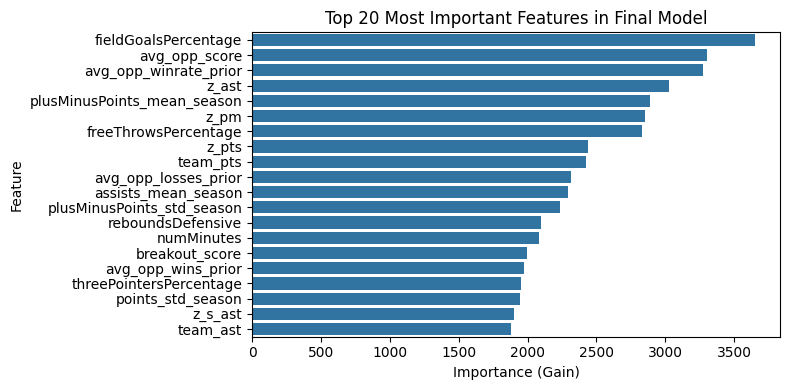

In [73]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': X_all.columns.tolist(),
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
top_20 = importance_df.head(20)

sns.barplot(
    data=top_20,
    y='feature',
    x='importance',
)

plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features in Final Model')
plt.tight_layout()

Looking at our final model's top features, we see that field goal percentage is the biggest indicator. This showcases how consistency, scoring accuracy, and shot selection could be strong attributes that voters use to decide the Player of the Week winner. Furthermore, we see both individual and team-based features. 'z_ast', 'z_pm', 'z_pts' are the normalized assists, points, and plus minus of a player for that week compared to their rolling average leading up to the current week. 'avg_opp_score' and 'team_pts' are both based on the player's team peformance as well as the player's opponent performance.

# Inference Test

We will now move on to testing our model on data from the current season: 2025-26. We will test our model for each week so far during this season.

In [76]:
# Reminder: total_inf is our inference set containing data from the 2025-26 season

# Select the same features our model was trained on
X_inf = total_inf.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba'])

# True results
y_inf = total_inf['won_player_of_the_week']

# Set our categorical data
for c in cat_cols:
    X_inf[c] = X_inf[c].astype('category')

# Double check our data does not contain null values
has_null_rows = X_inf.isnull().any(axis=1)
num_rows_with_nulls = has_null_rows.sum()
print(f"Number of rows with null values: {num_rows_with_nulls}")

results = []
k = [1, 3, 5, 10]
k_dict = {i: [] for i in k}

# Group by week, conference (season = 2025)
for (week, conference), group in X_inf.groupby(['week', 'conference'], observed=True):
    # Get corresponding labels for current group
    y_group = y_inf[group.index]

    # Skip if no winner in this group i.e. data from present week
    if y_group.sum() == 0:
        continue

    # Predict winner
    pred = final_model.predict(group)

    # Create results dataframe
    df = total_inf.loc[group.index, ['full_name', 'team']].copy()
    df['score'] = pred
    df['y_true'] = y_group.values
    
    # Sort by prediction score
    df_sorted = df.sort_values('score', ascending=False).reset_index(drop=True)
    
    # Find actual winner's rank
    winner_idx = df_sorted[df_sorted['y_true'] == 1].index
    if len(winner_idx) > 0:
        winner_rank = winner_idx[0] + 1  # Convert to 1-indexed
        
        # Store results
        result = {
            'week': week,
            'conference': conference,
            'actual_winner': df_sorted[df_sorted['y_true'] == 1]['full_name'].values[0],
            'predicted_winner': df_sorted.iloc[0]['full_name'],
            'winner_rank': winner_rank,
            'top_5': df_sorted.head(5)[['full_name', 'team', 'score', 'y_true']].to_dict('records')
        }
        results.append(result)
        
        # Calculate top-k accuracy
        for i in k:
            top_k = df_sorted.head(i)
            hit = top_k['y_true'].max()
            k_dict[i].append(hit)

# Display results
print(f"\nTotal weeks evaluated: {len(results)}")

Number of rows with null values: 0

Total weeks evaluated: 8


In [77]:
# Show per-week results
for result in results:
    print(f"\nWeek {result['week']} - {result['conference']}:")
    print(f"Actual: {result['actual_winner']}")
    print(f"Predicted: {result['predicted_winner']}")
    print(f"Top 5 predictions:")
    for i, player in enumerate(result['top_5'], 1):
        is_winner = "  <-- WINNER" if player['full_name'] == result['actual_winner'] else ""
        print(f"{i}. {player['full_name']} ({player['team']}) - Score: {player['score']:.4f}{is_winner}")

# Overall metrics
print("Overall Inference Performance:")

for i in k:
    accuracy = np.mean(k_dict[i])
    print(f"Top-{i} Accuracy: {accuracy:.4f} ({int(accuracy * len(results))}/{len(results)} weeks)")

ranks = [r['winner_rank'] for r in results]
print(f"\nMean Winner Rank: {np.mean(ranks):.2f}")
print(f"Median Winner Rank: {np.median(ranks):.1f}")
print(f"Best Rank: {min(ranks)}")
print(f"Worst Rank: {max(ranks)}")


Week 45 - East:
Actual: Cade Cunningham
Predicted: Cade Cunningham
Top 5 predictions:
1. Cade Cunningham (Pistons) - Score: 0.2159  <-- WINNER
2. Donovan Mitchell (Cavaliers) - Score: -1.3652
3. Jalen Duren (Pistons) - Score: -1.8618
4. Giannis Antetokounmpo (Bucks) - Score: -5.2706
5. Karl-Anthony Towns (Knicks) - Score: -6.1876

Week 45 - West:
Actual: Nikola Jokic
Predicted: Nikola Jokic
Top 5 predictions:
1. Nikola Jokic (Nuggets) - Score: 2.1371  <-- WINNER
2. Shai Gilgeous-Alexander (Thunder) - Score: 0.8979
3. Alperen Sengun (Rockets) - Score: -3.0521
4. Devin Booker (Suns) - Score: -4.2207
5. Julius Randle (Timberwolves) - Score: -5.6398

Week 46 - East:
Actual: Jalen Johnson
Predicted: Jalen Johnson
Top 5 predictions:
1. Jalen Johnson (Hawks) - Score: 0.5589  <-- WINNER
2. Franz Wagner (Magic) - Score: -2.4714
3. Desmond Bane (Magic) - Score: -5.5210
4. Karl-Anthony Towns (Knicks) - Score: -5.8426
5. Giannis Antetokounmpo (Bucks) - Score: -6.4623

Week 46 - West:
Actual: Niko

Our Light GBM lambdarank model achieved 100% top-1 accuracy (8/8 correct predictions) when tested on the 2025-26 season, perfectly predicting every player of the week winner across both conferences. This exceptional performance significantly exceeded our cross-validation, optuna baseline of 61% accuracy from historical data (2001-2024 seasons).

However, important caveats to note are:
1. Small sample size - only 8 weeks of data makes this a preliminary result. We should expect accuracy to stablize closer to ~60% as more weeks are evaluated.
2. Potential for "obvious" winners - These particular weeks may have featured dominant performances that were easy to predict. For example, Nikola Jokic had a score of 2.81 and 4.02. In cases where the race for the award is tight or a player wins it for the first, our model might not predict accurately.
3. Evolution of NBA performance standards - As seen in our cross-validation results, accuracy fluctuated across different validation seasons. The criteria for player of the week selection evolves as the NBA changes: new generations of players enter the league, playing styles shift, and statistical benchmarks increase over time. Since the award is determined by voting that reflects current expectations, our historical normalization features (such as 'z_s_pts', which compares a player's points to past seasons' league-wide averages) may not fully capture how impressive a performance is relative to contemporary standards. A 30-point game that would have been exceptional in 2005 might be less remarkable in 2025's higher-scoring environment.
4. Varying 'score' magnitude - The model assigns very different score magnitudes to weekly winners depending on the overall distribution of players in that week. This variation suggests that each week has a unique competitive landscape, and the model’s confidence depends heavily on how distinct the winner’s performance is relative to the field that week.

While 100% accuracy is outstanding, our final model's true performance will be validated as we accumulate predictions over 20-30+ weeks throughout the season. 

# Why Light GBM?

Light GBM is an ideal choice for predicting NBA Player of the Week because it directly addresses the core challenge: ranking players against each other within the same week. Its built-in lambdarank objective is specifically designed for ranking tasks, learning to order players correctly rather than simply classifying winners versus non-winners. The algorithm excels with our large tabular dataset (ours was 100,000+ rows) containing mixed feature types (numerical stats like points and assists, categorical features like team and conference), handling severe class imbalance naturally through its ranking framework. Light GBM is also computationally efficient, enabling rapid hyperparameter tuning, in our case Optuna, and providing interpretable feature importance scores that reveal which statistics (scoring, team success, efficiency) drive player of the week selection. These advantages, ranking optimization, robust handling of mixed data types, speed, and interpretability, make Light GBM a great choice for sports prediction and learning-to-rank problems.

# Part 5: Neural Network

While we achieved 100% accuracy for our Light GBM inferences, our model will eventually reach its baseline as mentioned above. Thus, we will explore another model to see if it can achieve a higher baseline accuracy.

With the rise of artificial intelligence, deep learning has become a foundational technique across domains such as natural language processing, autonomous driving, and biostatistics. To explore its potential within our context, we will evaluate how a neural network performs on predicting the Player of the Week using our dataset.

In [96]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import gc

In [97]:
# Assign device to gpu if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Training on CPU")

print(f"Using device: {device}")

Training on Apple Silicon GPU (MPS)
Using device: mps


# Data Preparation

As extensively shown in our Light GBM model, we need to keep our groups (season, week, conference) in tact when training our model. As such, we need to create a custom batch sampler that keeps entire groups together.

In [104]:
class GroupBatchSampler:
    def __init__(self, group_ids, batch_size):
        self.group_ids = group_ids
        self.batch_size = batch_size

        # Group indices by group_id
        self.groups = {}
        for idx, group_id in enumerate(group_ids):
            if group_id not in self.groups:
                self.groups[group_id] = []
            self.groups[group_id].append(idx)

        self.group_list = list(self.groups.keys())

    def __iter__(self):
        # Shuffle the order of the groups
        np.random.shuffle(self.group_list)

        batch = []
        for group_id in self.group_list:
            group_indices = self.groups[group_id]
            batch.extend(group_indices)

            # Yield batch when reching batch_size
            while len(batch) >= self.batch_size:
                yield batch[:self.batch_size]
                batch = batch[self.batch_size:]

         # Yield remaining samples   
        if len(batch) > 0:
            yield batch
    
    def __len__(self):
        return (len(self.group_ids) + self.batch_size - 1) // self.batch_size

Unlike our Light GBM model, we need to one-hot encode our categorical features (team, conference) for our neural net model.

In [105]:
# Safely recopying our data by pulling same data table again from the cloud
# Pull csv file with all features from cloud database
df = get_csv_df("features-overall-weekly.csv")

# We will train our model pre-2025-26 season and inference on our 2025-26 weeks
total_pre = df[df['season'] != 2025]
total_inf = df[df['season'] == 2025] # our inference set

# Dropping rows where season is before 2001-02 season
total_pre = total_pre[total_pre['season'] > 2000]

# Reminder: total_pre = data up to 2024-25 season
X = total_pre.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba'])

y = total_pre['won_player_of_the_week']

print(f"Number of features before one-hot encoding: {len(X.columns)}")

# One-hot encode
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Rename conference one-hot encoding column: 'conference_West' -> 'conference'
X = X.rename(columns={'conference_West': 'conference'})

print(f"Number of features after one-hot encoding: {len(X.columns)}")

Number of features before one-hot encoding: 65
Number of features after one-hot encoding: 95


Since we one-hot encoded our categorical features, the number of features will grow a lot due to the number of teams in the NBA. This is totally ok since neural networks can handle high dimensionality

# Neural Network Architecture

Our neural network has three layers that get progressively smaller (256 -> 128 -> 64 neurons), like a funnel that squeezes information down from ~100 input features into a single score per player. The first layer spots basic patterns in the data, the middle layer combines these patterns into bigger ideas like "great scorer" or "well-rounded player," and the final layer picks out what actually matters for winning player of the week. 

Between each layer, we use ReLU activation which lets the network learn that certain combinations of stats matter more together than separately (like how 35 points + 3 wins is way more impressive than just 35 points alone). We also randomly turn off 30% of neurons during training (dropout) so the network doesn't just memorize the data and actually learns real patterns. The final output is a ranking score rather than a probability because we just need to know who scores highest, not the exact chance they win.

In [106]:
class POTWRanker(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.3):
        super(POTWRanker, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer (single score per player)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Ranking Loss Function

Our loss function teaches the model to make sure winners score higher than everyone else in the same week, rather than just predicting winners independently. For every week, it compares the winner to every non-winner (so if there's 1 winner and 50 other players, it makes 50 comparisons) and gives the model a penalty whenever the winner's score isn't at least 1.0 points higher. This is like telling the model "the winner needs to clearly beat everyone else, not just barely edge them out." The key advantage is that the model learns what makes one player better than another in that specific week's context, rather than trying to learn some universal "good player" score. This only works if we keep entire weeks together during training. If we mix players from different weeks, the comparisons don't make sense since those players never actually competed for the same award.

In [107]:
class PairwiseRankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(PairwiseRankingLoss, self).__init__()
        self.margin = margin
    
    def forward(self, scores, labels, group_indices):
        total_loss = torch.tensor(0.0, requires_grad=True)
        num_pairs = 0
        
        # For each group (week/conference)
        for group_id in torch.unique(group_indices):
            mask = group_indices == group_id
            group_scores = scores[mask].squeeze()
            group_labels = labels[mask]
            
            # Find winners and non-winners
            winner_mask = group_labels == 1
            non_winner_mask = group_labels == 0
            
            if winner_mask.sum() == 0 or non_winner_mask.sum() == 0:
                continue
            
            winner_scores = group_scores[winner_mask]
            non_winner_scores = group_scores[non_winner_mask]
            
            # Compute all pairwise differences at once
            score_diff = winner_scores.unsqueeze(1) - non_winner_scores.unsqueeze(0)
            
            # Apply margin and clamp
            losses = torch.clamp(self.margin - score_diff, min=0)
            
            total_loss = total_loss + losses.sum()  # Add to tensor
            num_pairs += losses.numel()
        
        # Return tensor (even if zero)
        if num_pairs == 0:
            return torch.tensor(0.0, requires_grad=True)
        
        return total_loss / num_pairs

# Cross Validation Training

Again, we will run time-based cross validation to prevent overfitting results swaying our decisions by testing our model on 'unseen' data (validation sets). We will follow the same format as our cross validation from Light GBM.

Unlike our Light GBM model, in our neural net model, we will scale our data because neural networks are sensitive to feature magnitudes. For example, 'points' (0 to 70+ range) would dominate features like 'fieldGoalsPercentage' (0 to 1 range) during training, causing the model to learn poorly. Standardization ensures all features contribute equally to the model's learning process and helps gradient descent converge faster and more reliably. 

In [86]:
# Hyperparameters
epochs = 50
batch_size = 512
hidden_dims = [512, 256, 128, 64]
dropout = 0.2
lr = 0.001

unique_seasons = sorted(X['season'].unique())
folds = 3  # Reduced from 5 to 3 compared to Light GBM
k = [1, 3, 5, 10]
cv_results = []

for fold in range(1, folds + 1):
    val_season = unique_seasons[-fold]
    train_seasons = unique_seasons[:-fold]
    
    val_mask = X['season'] == val_season
    train_mask = X['season'].isin(train_seasons)
    
    X_train = X[train_mask].copy()
    y_train = y[train_mask].copy()
    X_val = X[val_mask].copy()
    y_val = y[val_mask].copy()

    print(f"Validation {fold}")
    print(f"Val Season: {val_season}")
    print(f"Train Seasons: {train_seasons[0]}-{train_seasons[-1]}")
    print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")
    
    X_train['group_id'] = X_train.groupby(['season', 'week', 'conference']).ngroup()
    train_group_ids = X_train['group_id'].values
    
    X_train_features = X_train.drop(columns=['group_id']).values
    X_val_features = X_val.values
    print(f"Train shape: {X_train_features.shape}")
    print(f"Val shape: {X_val_features.shape}")
    
    # Scaling our data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features).astype(np.float32)
    X_val_scaled = scaler.transform(X_val_features).astype(np.float32)
    
    print("\nCreating PyTorch dataset...")
    train_dataset = TensorDataset(
        torch.from_numpy(X_train_scaled),
        torch.from_numpy(y_train.values.astype(np.float32)),
        torch.from_numpy(train_group_ids.astype(np.int64))
    )
    
    print("\nCreating GroupBatchSampler and DataLoader...")
    batch_sampler = GroupBatchSampler(train_group_ids, batch_size=batch_size)
    train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)
    print(f"DataLoader created. Number of batches: {len(train_loader)}")
    
    print("\nInitializing model...")
    input_dim = X_train_scaled.shape[1]
    model = POTWRanker(input_dim, hidden_dims=hidden_dims, dropout=dropout)
    print(f"Model created. Parameters: {sum(p.numel() for p in model.parameters()):,}")

    model = model.to(device)
    print(f"Model moved to {device}")
    
    print("\nSetting up loss and optimizer...")
    criterion = PairwiseRankingLoss(margin=1.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print("Loss and optimizer ready")
    
    print(f"\nTraining {epochs} epochs")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_X, batch_y, batch_groups in train_loader:
            # Move batch data to GPU
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            batch_groups = batch_groups.to(device)

            optimizer.zero_grad()
            scores = model(batch_X)
            loss = criterion(scores, batch_y, batch_groups)
            loss.backward() # Compute gradients
            optimizer.step() # Update weights * learning rate (Gradient descent)
            
            total_loss += loss.item() # Track running total loss
        
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    print("\nEvaluation")
    
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val_scaled).to(device)
        val_scores = model(X_val_tensor).cpu().squeeze().numpy()
    
    df_val = X_val[['season', 'week', 'conference']].copy().reset_index(drop=True)
    df_val['score'] = val_scores
    df_val['y_true'] = y_val.reset_index(drop=True).values
    
    k_dict = {i: [] for i in k}
    groups = df_val.groupby(['season', 'week', 'conference'], observed=True)
    ranks = []
    
    for _, group in groups:
        if group['y_true'].sum() == 0:
            continue
        
        group_sorted = group.sort_values('score', ascending=False).reset_index(drop=True)
        pos_idx = group_sorted.index[group_sorted['y_true'] == 1]
        
        for i in k:
            top_k = group_sorted.head(i)
            hit = top_k['y_true'].max()
            k_dict[i].append(hit)
        
        for idx in pos_idx:
            ranks.append(idx + 1)
    
    ranks = np.array(ranks)
    curr = {
        "Fold": fold,
        "Top_rank": ranks.min(),
        "Lowest_rank": ranks.max(),
        "Percentiles": np.percentile(ranks, [10, 25, 50, 75, 90])
    }
    for i, hits in k_dict.items():
        curr[f"Top_{i}_avg_hits"] = np.mean(hits)
    cv_results.append(curr)
    
    print(f"\nFold {fold} Results:")
    print(f"Top-1 Accuracy: {curr['Top_1_avg_hits']:.4f}")
    print(f"Top-3 Accuracy: {curr['Top_3_avg_hits']:.4f}")
    print(f"Top-5 Accuracy: {curr['Top_5_avg_hits']:.4f}")
    print(f"Top Rank: {curr['Top_rank']}")
    print(f"Lowest Rank: {curr['Lowest_rank']}")
    
    # Clean up memory after each fold to clear up RAM
    del model, optimizer, criterion, train_loader, train_dataset, batch_sampler
    del X_train, y_train, X_val, y_val
    del X_train_features, X_val_features, X_train_scaled, X_val_scaled
    del train_group_ids
    gc.collect()

Validation 1
Val Season: 2024
Train Seasons: 2001-2023
Train size: 165504, Val size: 7971
Train shape: (165504, 95)
Val shape: (7971, 95)

Creating PyTorch dataset...

Creating GroupBatchSampler and DataLoader...
DataLoader created. Number of batches: 324

Initializing model...
Model created. Parameters: 221,697
Model moved to mps

Setting up loss and optimizer...
Loss and optimizer ready

Training 50 epochs
Epoch 10/50, Loss: 0.0086
Epoch 20/50, Loss: 0.0045
Epoch 30/50, Loss: 0.0023
Epoch 40/50, Loss: 0.0014
Epoch 50/50, Loss: 0.0013

Evaluation

Fold 1 Results:
Top-1 Accuracy: 0.4000
Top-3 Accuracy: 0.5750
Top-5 Accuracy: 0.7500
Top Rank: 1
Lowest Rank: 26
Validation 2
Val Season: 2023
Train Seasons: 2001-2022
Train size: 158395, Val size: 7109
Train shape: (158395, 95)
Val shape: (7109, 95)

Creating PyTorch dataset...

Creating GroupBatchSampler and DataLoader...
DataLoader created. Number of batches: 310

Initializing model...
Model created. Parameters: 221,697
Model moved to mps

In [98]:
# Final Results
cv_df = pd.DataFrame(cv_results)
cv_df

,Fold,Top_rank,Lowest_rank,Percentiles,Top_1_avg_hits,Top_3_avg_hits,Top_5_avg_hits,Top_10_avg_hits
0,1,1,26,"[1.0, 1.0, 3.0, 6.5, 10.0]",0.400000,0.575000,0.750000,0.925000
1,2,1,26,"[1.0, 1.0, 2.0, 4.0, 6.399999999999999]",0.428571,0.714286,0.885714,0.942857
2,3,1,41,"[1.0, 1.0, 1.0, 3.0, 5.6000000000000085]",0.642857,0.880952,0.904762,0.952381


In [99]:
print("Average Performance Across Folds:")
for i in k:
    print(f"Top-{i} Accuracy: {cv_df[f'Top_{i}_avg_hits'].mean()}")

Average Performance Across Folds:
Top-1 Accuracy: 0.4904761904761905
Top-3 Accuracy: 0.7234126984126984
Top-5 Accuracy: 0.8468253968253968
Top-10 Accuracy: 0.9400793650793652


Our neural network achieved an average top-1 accuracy of approximately 50% across cross-validation folds, which is competitive with Light GBM's 53% but shows significantly higher variance (ranging from 40% in fold 1 to 64% in fold 3). This variance suggests that certain seasons are easier to predict than others, and neural networks are more sensitive to these differences in data distribution compared to tree-based models. While fold 3's 64% accuracy demonstrates that neural networks can match or exceed LightGBM's performance on some validation sets, the inconsistency makes Light GBM a more stable and reliable choice for deployment. Nonetheless, we observe the running loss steadily decreasing across epochs, indicating that the neural network is successfully learning underlying patterns in the data. Importantly, the loss curve shows no signs of explosion or divergence, suggesting that the model is training stably under the current architecture and hyperparameters. Let's continue on to tuning our neural network.

# Hyper Parameter Tuning

Just as we did with out Light GBM model, we will use optuna to tune our model. To save time, we will conduct a 2-fold cross validation using 2022-23 and 2023-24 seasons as our validation sets, which correspond to our fold 1 and fold 3 from the results above. This will help us reduce the variance of the model as our first cross fold validation trial produced varying accuracy results. Furthermore, we will be reducing the number of epochs to 25 since we are looking for relative performance boost, not absolute.

In [108]:
def nn_objective(trial):    
    # Hyperparameters
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 5e-4, 5e-3, log=True), # Proportion of step when updating weights during gradient descent
        'batch_size': trial.suggest_categorical('batch_size', [256, 512]), # Number of samples processed together before updating weights
        'dropout': trial.suggest_float('dropout', 0.1, 0.3), # Probability of randomly "turning off neurons" during training to prevent overfitting
        'hidden_dim_1': trial.suggest_categorical('hidden_dim_1', [256, 512, 768]),
        'hidden_dim_2': trial.suggest_categorical('hidden_dim_2', [128, 256, 384]),
        'hidden_dim_3': trial.suggest_categorical('hidden_dim_3', [64, 128, 192]),
        'hidden_dim_4': trial.suggest_categorical('hidden_dim_4', [32, 64, 96]),
        'margin': trial.suggest_float('margin', 0.5, 2.0), # Minimum score difference required between winner and non-winner in our loss function
        'epochs': 25, # Fixed to save time during training, reduced to 25 to save training time
    }
    
    hidden_dims = [params['hidden_dim_1'], params['hidden_dim_2'], 
                   params['hidden_dim_3'], params['hidden_dim_4']]
    
    unique_seasons = sorted(X['season'].unique())
    folds = 2
    fold_accuracies = []
    
    for fold in range(2, folds + 2):
        val_season = unique_seasons[-fold]
        train_seasons = unique_seasons[:-fold]
        
        val_mask = X['season'] == val_season
        train_mask = X['season'].isin(train_seasons)
        
        X_train = X[train_mask].copy()
        y_train = y[train_mask].copy()
        X_val = X[val_mask].copy()
        y_val = y[val_mask].copy()
        
        # Create group IDs
        X_train['group_id'] = X_train.groupby(['season', 'week', 'conference']).ngroup()
        train_group_ids = X_train['group_id'].values
        
        # Extract features
        X_train_features = X_train.drop(columns=['group_id']).values
        X_val_features = X_val.values
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_features).astype(np.float32)
        X_val_scaled = scaler.transform(X_val_features).astype(np.float32)
        
        # Create dataset
        train_dataset = TensorDataset(
            torch.from_numpy(X_train_scaled),
            torch.from_numpy(y_train.values.astype(np.float32)),
            torch.from_numpy(train_group_ids.astype(np.int64))
        )
        
        batch_sampler = GroupBatchSampler(train_group_ids, batch_size=params['batch_size'])
        train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)
        
        # Initialize model
        input_dim = X_train_scaled.shape[1]
        model = POTWRanker(input_dim, hidden_dims=hidden_dims, dropout=params['dropout'])
        model = model.to(device)
        
        criterion = PairwiseRankingLoss(margin=params['margin'])
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        # Training
        for epoch in range(params['epochs']):
            model.train()
            for batch_X, batch_y, batch_groups in train_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                batch_groups = batch_groups.to(device)
                
                optimizer.zero_grad()
                scores = model(batch_X)
                loss = criterion(scores, batch_y, batch_groups)
                loss.backward()
                optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            X_val_tensor = torch.from_numpy(X_val_scaled).to(device)
            val_scores = model(X_val_tensor).cpu().squeeze().numpy()
        
        df_val = X_val[['season', 'week', 'conference']].copy().reset_index(drop=True)
        df_val['score'] = val_scores
        df_val['y_true'] = y_val.reset_index(drop=True).values
        
        # Calculate Top-1 accuracy
        hits = []
        for _, group in df_val.groupby(['season', 'week', 'conference'], observed=True):
            if group['y_true'].sum() == 0:
                continue
            group_sorted = group.sort_values('score', ascending=False).reset_index(drop=True)
            hit = 1 if group_sorted.iloc[0]['y_true'] == 1 else 0
            hits.append(hit)
        
        fold_accuracy = np.mean(hits)
        fold_accuracies.append(fold_accuracy)
        
        # Report intermediate value for pruning
        trial.report(fold_accuracy, fold)
        
        # Clean up memory
        del model, optimizer, criterion, train_loader, train_dataset, batch_sampler
        del X_train, y_train, X_val, y_val, train_group_ids
        del X_train_features, X_val_features, X_train_scaled, X_val_scaled
        gc.collect()
    
    # Return mean accuracy across folds
    return np.mean(fold_accuracies)

In [110]:
# Create study
study = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.NopPruner() # No pruner because our folds are skewed as evident from our results from above
)

# Run optimization
study.optimize(nn_objective, n_trials=12, show_progress_bar=True)

[I 2025-12-06 12:47:45,232] A new study created in memory with name: no-name-69cbdccd-9e86-453f-8967-950593727c40
Best trial: 0. Best value: 0.497619:   8%|▊         | 1/12 [05:39<1:02:18, 339.88s/it]

[I 2025-12-06 12:53:25,112] Trial 0 finished with value: 0.4976190476190476 and parameters: {'learning_rate': 0.0011844319751820387, 'batch_size': 256, 'dropout': 0.21973169683940733, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'hidden_dim_3': 128, 'hidden_dim_4': 32, 'margin': 0.9563633644393066}. Best is trial 0 with value: 0.4976190476190476.


Best trial: 1. Best value: 0.52381:  17%|█▋        | 2/12 [11:08<55:33, 333.32s/it]   

[I 2025-12-06 12:58:53,838] Trial 1 finished with value: 0.5238095238095238 and parameters: {'learning_rate': 0.0016738881542579674, 'batch_size': 256, 'dropout': 0.2223705789444759, 'hidden_dim_1': 768, 'hidden_dim_2': 256, 'hidden_dim_3': 128, 'hidden_dim_4': 32, 'margin': 1.92332830588}. Best is trial 1 with value: 0.5238095238095238.


Best trial: 1. Best value: 0.52381:  25%|██▌       | 3/12 [16:30<49:11, 327.99s/it]

[I 2025-12-06 13:04:15,478] Trial 2 finished with value: 0.5238095238095238 and parameters: {'learning_rate': 0.004619575159813623, 'batch_size': 256, 'dropout': 0.11953442280127678, 'hidden_dim_1': 256, 'hidden_dim_2': 384, 'hidden_dim_3': 128, 'hidden_dim_4': 64, 'margin': 1.9543769416468377}. Best is trial 1 with value: 0.5238095238095238.


Best trial: 1. Best value: 0.52381:  33%|███▎      | 4/12 [21:45<43:04, 323.11s/it]

[I 2025-12-06 13:09:31,118] Trial 3 finished with value: 0.5071428571428571 and parameters: {'learning_rate': 0.0029792217348362585, 'batch_size': 256, 'dropout': 0.219579995762217, 'hidden_dim_1': 256, 'hidden_dim_2': 384, 'hidden_dim_3': 128, 'hidden_dim_4': 64, 'margin': 1.7032954711310595}. Best is trial 1 with value: 0.5238095238095238.


Best trial: 1. Best value: 0.52381:  42%|████▏     | 5/12 [27:00<37:19, 319.91s/it]

[I 2025-12-06 13:14:45,360] Trial 4 finished with value: 0.42857142857142855 and parameters: {'learning_rate': 0.0005936365712667949, 'batch_size': 256, 'dropout': 0.1397431363068345, 'hidden_dim_1': 512, 'hidden_dim_2': 256, 'hidden_dim_3': 192, 'hidden_dim_4': 32, 'margin': 0.9664734825734933}. Best is trial 1 with value: 0.5238095238095238.


Best trial: 1. Best value: 0.52381:  50%|█████     | 6/12 [32:23<32:06, 321.08s/it]

[I 2025-12-06 13:20:08,700] Trial 5 finished with value: 0.5023809523809524 and parameters: {'learning_rate': 0.0010571906813317184, 'batch_size': 256, 'dropout': 0.2774425485152653, 'hidden_dim_1': 768, 'hidden_dim_2': 384, 'hidden_dim_3': 128, 'hidden_dim_4': 64, 'margin': 1.4546156168956705}. Best is trial 1 with value: 0.5238095238095238.


Best trial: 1. Best value: 0.52381:  58%|█████▊    | 7/12 [36:49<25:16, 303.21s/it]

[I 2025-12-06 13:24:35,128] Trial 6 finished with value: 0.4666666666666667 and parameters: {'learning_rate': 0.0010311598280323558, 'batch_size': 512, 'dropout': 0.14985844582977498, 'hidden_dim_1': 512, 'hidden_dim_2': 256, 'hidden_dim_3': 64, 'hidden_dim_4': 32, 'margin': 1.8388384977349665}. Best is trial 1 with value: 0.5238095238095238.


Best trial: 1. Best value: 0.52381:  67%|██████▋   | 8/12 [41:15<19:25, 291.31s/it]

[I 2025-12-06 13:29:00,946] Trial 7 finished with value: 0.5119047619047619 and parameters: {'learning_rate': 0.0017310604986467968, 'batch_size': 512, 'dropout': 0.16360069499437277, 'hidden_dim_1': 768, 'hidden_dim_2': 256, 'hidden_dim_3': 64, 'hidden_dim_4': 96, 'margin': 0.9848043980311328}. Best is trial 1 with value: 0.5238095238095238.


Best trial: 8. Best value: 0.554762:  75%|███████▌  | 9/12 [46:32<14:58, 299.42s/it]

[I 2025-12-06 13:34:18,192] Trial 8 finished with value: 0.5547619047619048 and parameters: {'learning_rate': 0.001651051522757627, 'batch_size': 256, 'dropout': 0.29435641654419215, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'hidden_dim_3': 64, 'hidden_dim_4': 64, 'margin': 0.7173423081368346}. Best is trial 8 with value: 0.5547619047619048.


Best trial: 8. Best value: 0.554762:  83%|████████▎ | 10/12 [52:03<10:18, 309.09s/it]

[I 2025-12-06 13:39:48,940] Trial 9 finished with value: 0.4952380952380952 and parameters: {'learning_rate': 0.001543201954264313, 'batch_size': 256, 'dropout': 0.2344271094811757, 'hidden_dim_1': 256, 'hidden_dim_2': 384, 'hidden_dim_3': 192, 'hidden_dim_4': 32, 'margin': 1.3863394147823627}. Best is trial 8 with value: 0.5547619047619048.


Best trial: 8. Best value: 0.554762:  92%|█████████▏| 11/12 [56:41<04:59, 299.45s/it]

[I 2025-12-06 13:44:26,527] Trial 10 finished with value: 0.45238095238095233 and parameters: {'learning_rate': 0.0029936920922265836, 'batch_size': 512, 'dropout': 0.29390742215757315, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'hidden_dim_3': 64, 'hidden_dim_4': 96, 'margin': 0.5170869217815159}. Best is trial 8 with value: 0.5547619047619048.


Best trial: 8. Best value: 0.554762: 100%|██████████| 12/12 [1:02:21<00:00, 311.79s/it]

[I 2025-12-06 13:50:06,654] Trial 11 finished with value: 0.5119047619047619 and parameters: {'learning_rate': 0.0021176473994339484, 'batch_size': 256, 'dropout': 0.2600909404222778, 'hidden_dim_1': 768, 'hidden_dim_2': 128, 'hidden_dim_3': 64, 'hidden_dim_4': 64, 'margin': 0.5312855881547717}. Best is trial 8 with value: 0.5547619047619048.


In [111]:
# Optuna Results
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial value (Top-1 Accuracy): {study.best_value:.4f}")

print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Number of finished trials: 12
Best trial value (Top-1 Accuracy): 0.5548

Best hyperparameters:
  learning_rate: 0.001651051522757627
  batch_size: 256
  dropout: 0.29435641654419215
  hidden_dim_1: 256
  hidden_dim_2: 128
  hidden_dim_3: 64
  hidden_dim_4: 64
  margin: 0.7173423081368346


As mentioned before, we cannot compare our optuna results to our previous cross validation results as the set up is different. However, unlike our previous set up, our optuna best results include changes, most notably batch_size 256. By reducing our batch size from 512 to 256, we introduce more noise in our gradient estimates. This acts as a regularization and often lead to better generalization on unseen data.

In [114]:
# Get best params
best_params = study.best_params

# Reconstruct hidden dims
hidden_dims_best = [
    best_params['hidden_dim_1'],
    best_params['hidden_dim_2'],
    best_params['hidden_dim_3'],
    best_params['hidden_dim_4']
]

print("\nBest Configuration:")
print(f"Learning Rate: {best_params['learning_rate']:.6f}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Dropout: {best_params['dropout']:.2f}")
print(f"Hidden Dims: {hidden_dims_best}")
print(f"Margin: {best_params['margin']:.2f}")


Best Configuration:
Learning Rate: 0.001651
Batch Size: 256
Dropout: 0.29
Hidden Dims: [256, 128, 64, 64]
Margin: 0.72


# Final Model

Now that we have tuned our hyper parameters, we will continue to training our final model and testing it on our 2025-26 season data.

In [117]:
# Best hyperparameters from optuna trials
epochs = 100
batch_size = best_params['batch_size']
hidden_dims = hidden_dims_best
dropout = best_params['dropout']
lr = best_params['learning_rate']
margin = best_params['margin']

# Train on all available, we have our 2025-26 season data for inference
X_all = X.copy()  # All data from 2001-2024
y_all = y.copy()

# Sort by key
X_all['group_id'] = X_all.groupby(['season', 'week', 'conference']).ngroup()
all_group_ids = X_all['group_id'].values
X_all = X_all.sort_values(by='group_id')
y_all = y_all.loc[X_all.index]

# Extract features
feature_cols = [col for col in X_all.columns if col not in ['group_id']]
X_all_features = X_all[feature_cols].values

# Scale
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_features).astype(np.float32)
input_dim = X_all_scaled.shape[1]

# Create dataset
train_dataset = TensorDataset(
    torch.from_numpy(X_all_scaled),
    torch.from_numpy(y_all.values.astype(np.float32)),
    torch.from_numpy(all_group_ids.astype(np.int64))
)

batch_sampler = GroupBatchSampler(all_group_ids, batch_size=batch_size)
train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)

# Train with best hyperparameters from Optuna
model = POTWRanker(input_dim, hidden_dims=hidden_dims, dropout=dropout)
model = model.to(device)

criterion = PairwiseRankingLoss(margin=margin)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y, batch_groups in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        batch_groups = batch_groups.to(device)
        
        optimizer.zero_grad()
        scores = model(batch_X)
        loss = criterion(scores, batch_y, batch_groups)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Save model
torch.save(model.state_dict(), 'nn_final_model.pth')
with open('nn_scaler.pkl', 'wb') as f: # Save fitted scaler to transform future data
    pickle.dump(scaler, f)
print("Final model saved")


Epoch 10/100, Loss: 0.0119
Epoch 20/100, Loss: 0.0079
Epoch 30/100, Loss: 0.0058
Epoch 40/100, Loss: 0.0044
Epoch 50/100, Loss: 0.0040
Epoch 60/100, Loss: 0.0031
Epoch 70/100, Loss: 0.0034
Epoch 80/100, Loss: 0.0030
Epoch 90/100, Loss: 0.0027
Epoch 100/100, Loss: 0.0025
Final model saved


The loss decreased from 0.0119 to 0.0025, showing strong convergence, but the improvements after epoch 60 were minimal (only 0.0006 reduction over 40 epochs compared to 0.0088 in the first 60 epochs). Furthermore, the small uptick at epoch 70 (0.0031 -> 0.0034) followed by continued decrease is a normal fluctuation in stochastic training, indicating the model is oscillating slightly around an optimal minimum rather than overfitting. This plateau and stable behavior showcases the model has effectively learned the patterns in our data and is ready for inference.

# Inference Test

We will now move on to testing our model on data from the current season: 2025-26. We will test our model for each week so far during this season.

In [118]:
# Reminder: total_inf is our inference set containing data from the 2025-26 season
# Select the same features our model was trained on
total_inf = total_inf.reset_index(drop=True)
X_inf = total_inf.drop(columns=['full_name', 'player_id', 'pow_player_id', 'player_of_the_week', 'won_player_of_the_week', 'all_star_this_season', 'mvp_this_season',
 'all_nba_first_team_this_season', 'all_nba_second_team_this_season', 'all_nba_third_team_this_season', 'week_start', 'pow_conference',
 'is_win_vs_over_500', 'opponent_has_all_nba']).reset_index(drop=True)

# True results
y_inf = total_inf['won_player_of_the_week'].reset_index(drop=True)

# One-hot encode
X_inf = pd.get_dummies(X_inf, columns=cat_cols, drop_first=True)

# Rename conference one-hot encoding column: 'conference_West' -> 'conference'
X_inf = X_inf.rename(columns={'conference_West': 'conference'})

# Add missing columns (teams that don't exist anymore) with all zeros
for col in X_all.drop(columns=['group_id']).columns:
    if col not in X_inf.columns:
        X_inf[col] = 0  # Add missing column with zeros
        print(f"Added missing column: {col}")

# Double check our data does not contain null values
has_null_rows = X_inf.isnull().any(axis=1)
num_rows_with_nulls = has_null_rows.sum()
print(f"Number of rows with null values: {num_rows_with_nulls}")

Added missing column: team_Bobcats
Added missing column: team_SuperSonics
Number of rows with null values: 0


As we want to match the dimensions of our test data with our training data, we need to address any missing features. In this case, we see that the teams Bobcats and Super Sonics are not contained in our test data. This is due to these teams no longer in the NBA today. We fill these features with 0 values safely as these features are hot-encodings for a player's team.

In [119]:
# Inference data
X_inf_features = X_inf.values

# Scale features with SAME scaler from training
X_inf_scaled = scaler.transform(X_inf_features).astype(np.float32)

# Convert to tensors and move to device
X_inf_tensor = torch.from_numpy(X_inf_scaled).to(device)

# Predictions
model.eval()
with torch.no_grad():
    pred = model(X_inf_tensor).cpu().squeeze().numpy()

# Evaluate results
results = []
k = [1, 3, 5, 10]
k_dict = {i: [] for i in k}

# Group predictions by season, week, conference
for (season, week, conference), group in X_inf.groupby(['season', 'week', 'conference'], observed=True):
    idx = group.index.to_numpy()  # these are now positions 0..1496

    # Use positional indexing everywhere
    y_group = y_inf.iloc[idx].to_numpy()
    pred_group = pred[idx]

    # Skip if no winner i.e. present week
    if y_group.sum() == 0:
        continue
    
    # Create results dataframe
    df = total_inf.loc[group.index, ['full_name', 'team']].copy()
    df['score'] = pred_group
    df['y_true'] = y_group
    
    # Sort by prediction score
    df_sorted = df.sort_values('score', ascending=False).reset_index(drop=True)
    
    # Find actual winner's rank
    winner_idx = df_sorted[df_sorted['y_true'] == 1].index
    if len(winner_idx) > 0:
        winner_rank = winner_idx[0] + 1  # Convert to 1-indexed
        
        result = {
            'week': week,
            'conference': conference,
            'actual_winner': df_sorted[df_sorted['y_true'] == 1]['full_name'].values[0],
            'predicted_winner': df_sorted.iloc[0]['full_name'],
            'winner_rank': winner_rank,
            'top_5': df_sorted.head(5)[['full_name', 'team', 'score', 'y_true']].to_dict('records')
        }
        results.append(result)
        
        # Calculate top-k accuracy
        for i in k:
            top_k = df_sorted.head(i)
            hit = top_k['y_true'].max()
            k_dict[i].append(hit)
    
print(f"\nTotal weeks evaluated: {len(results)}")


Total weeks evaluated: 8


In [120]:
# Show week by week peformance
for result in results:
    print(f"\nWeek {result['week']} - {result['conference']}:")
    print(f"Actual: {result['actual_winner']}")
    print(f"Predicted: {result['predicted_winner']}")
    print(f"Top 5 predictions:")
    for i, player in enumerate(result['top_5'], 1):
        is_winner = "  <-- WINNER" if player['full_name'] == result['actual_winner'] else ""
        print(f"{i}. {player['full_name']} ({player['team']}) - Score: {player['score']:.4f}{is_winner}")

# Overall metrics
print("Overall Inference Performance:")

for i in k:
    accuracy = np.mean(k_dict[i])
    print(f"Top-{i} Accuracy: {accuracy:.4f} ({int(accuracy * len(results))}/{len(results)} weeks)")

ranks = [r['winner_rank'] for r in results]
print(f"\nMean Winner Rank: {np.mean(ranks):.2f}")
print(f"Median Winner Rank: {np.median(ranks):.1f}")
print(f"Best Rank: {min(ranks)}")
print(f"Worst Rank: {max(ranks)}")


Week 45 - False:
Actual: Cade Cunningham
Predicted: Cade Cunningham
Top 5 predictions:
1. Cade Cunningham (Pistons) - Score: -1.1646  <-- WINNER
2. Donovan Mitchell (Cavaliers) - Score: -3.0000
3. Giannis Antetokounmpo (Bucks) - Score: -4.8807
4. Tyrese Maxey (76ers) - Score: -5.8756
5. RJ Barrett (Raptors) - Score: -10.4173

Week 45 - True:
Actual: Nikola Jokic
Predicted: Shai Gilgeous-Alexander
Top 5 predictions:
1. Shai Gilgeous-Alexander (Thunder) - Score: -15.1493
2. Nikola Jokic (Nuggets) - Score: -25.3479  <-- WINNER
3. Alperen Sengun (Rockets) - Score: -43.7016
4. Devin Booker (Suns) - Score: -54.7852
5. Kevin Durant (Rockets) - Score: -85.7801

Week 46 - False:
Actual: Jalen Johnson
Predicted: Scottie Barnes
Top 5 predictions:
1. Scottie Barnes (Raptors) - Score: -5.2011
2. Giannis Antetokounmpo (Bucks) - Score: -8.9512
3. Immanuel Quickley (Raptors) - Score: -9.6623
4. Michael Porter Jr. (Nets) - Score: -9.9992
5. Jakob Poeltl (Raptors) - Score: -11.3305

Week 46 - True:
Act

Our neural network model achieved 37.5% top-1 accuracy (3/8 correct predictions) when tested on the 2024-25 season, predicting Player of the Week winners across both conferences. This performance fell significantly short of our Light GBM model's 100% accuracy on the same weeks and was also below our cross-validation baseline of approximately 46-49% from historical data (2001-2024 seasons).

Important caveats to note are:

1. Small Sample Size - As with our Light GBM model, with only 8 weeks of data, this is a preliminary assessment. However, the downward trend from our cross-validation baseline suggests systematic generalization issues rather than random variance.

2. Model Confidence Calibration Issues - Like with our Light GBM results, the neural network model's score magnitudes varied dramatically across weeks. Eastern Conference predictions showed tight clustering (e.g. Week 47: -0.19 to -1.82), while Western Conference scores were widely spread (e.g. Week 45: -15 to -85). This inconsistent calibration indicates the model struggles to maintain stable confidence levels across different competitive landscapes.

3. Strong Candidate Identification Despite Misses - While top-1 accuracy was low, the model achieved 75% top-5 accuracy with a median winner rank of 2.0. This suggests the model identifies legitimate contenders but struggles with the final ranking decision, often placing the actual winner as a close second or third choice.

4. Season-to-Season Generalization Gap - The 37.5% accuracy confirms our cross-validation findings about high variance across different seasons. The neural network's dropout-based regularization proved less effective than Light GBM's ensemble of regularization parameters at handling the season-to-season variability in award voting patterns, player performance standards, and competitive dynamics.

5. Evolution of NBA Performance Standards - As seen in both our cross-validation and inference results, neural networks may overfit to historical voting patterns that don't apply to current season dynamics. The 2024-25 season features new player emergence patterns, evolving playing styles, and different competitive balances that our model, trained on 2001-2024 data, may not fully capture. For example, our model completely missed Jalen Johnson, a first time winner, in its top 5 ranking for that week. This showcases that model may be relying heavily on whether a player has previously won Player of the Week in the past to predict each week's winner.

6. Conference-Specific Patterns - The Western Conference's 50% accuracy (though still below expectations) compared to the Eastern Conference's 25% suggests the model learned different patterns for each conference, with Western Conference predictions being more reliable. This disparity indicates potential value in training separate conference-specific models.

# Why Neural Networks?

We explored neural networks for Player of the Week predictions due to their theoretical advantages in complex pattern recognition. Neural networks can automatically learn non-linear relationships between our ~100 features through multiple hidden layers, and our custom triplet loss framework was specifically designed to optimize the relative ranking of players by directly addressing the core challenge of distinguishing award-worthy performances from non-award-worthy ones within each week's candidate pool.

# Part 6: Summary

Between our Light GBM and neural network models, we achieved similar baseline accuracies of approximately 46-52% during cross-validation on historical data (2001-2024 seasons). However, the neural network exhibited greater variance across folds. Since we split our data by season, this variance reveals how factors like rule changes, evolving playing styles, and shifting voting patterns affect model consistency across different eras of basketball.

To establish a linear baseline, we also trained a logistic regression model using PCA-reduced features. Logistic regression achieved strong ranking performance (ROC AUC ≈ 0.964), showing that even a simple linear classifier can capture much of the separation between winners and non-winners. However, due to the extreme class imbalance of the Player-of-the-Week prediction task, its precision on the positive class was low despite high recall, indicating difficulty identifying true winners.This confirms that while logistic regression serves as a stable benchmark and performs well in terms of ranking, it lacks the nonlinear capacity needed for accurate top-1 predictions.

This variance translated directly to inference performance on the 2024-25 season: Light GBM achieved 100% top-1 accuracy (8/8 correct predictions) while the neural network managed only 37.5% (3/8). Light GBM's ensemble of regularization parameters, 'feature_fraction', 'bagging_fraction', 'min_child_weight', and 'min_child_samples', proved more effective at controlling overfitting to our highly variable data compared to the neural network's dropout-based regularization. The neural network's training convergence (loss: 0.0025) and respectable 75% top-5 accuracy demonstrate it learned meaningful patterns, but it struggled with final ranking decisions, particularly for first-time winners like Jalen Johnson, suggesting it overfit to historical winner patterns rather than adapting to current performance dynamics.

Despite moderate baseline accuracies, both models demonstrated viability for Player of the Week predictions by significantly outperforming random chance. Moving forward, incorporating additional features (such as media attention) and refining our feature selection process should improve performance. Furthermore, as more seasons are added to our dataset, the increased sample size should help reduce variance and improve generalization, particularly benefiting the neural network which typically requires substantially more training data to reach its full potential.